# Residual Integration Neural Net

# Problem statement :

Let us consider a dynamical system, whose time-varying state $X_t$ is governed by the following ordinary differential equation (ODE):

\begin{equation}
\frac{dX_t}{dt}= F(t,X_t)
\label{eq:sys dyn}
\end{equation}

where $F$ is the dynamical operator. Most of the time, this ODE cannot be solved analytically and numerical integration techniques using discrete approximations are implemented. 

In this work, we focus on explicit integration schemes. A one-step explicit integration scheme is defined as: 

\begin{equation}
\label{eq:int_gen_schm}
X_{t_{n+1}} = X_{t_{n}} + h\Phi(t_{n},X_{t_{n}},h)
\end{equation}

with $\Phi(t_{n},X_{t_{n}},h)$ a numerical integration operator. Here, we aim to learn a prediction operator based on $\Phi$ and an approximation of the dynamical model $F(t,X_t)$ so that the forecasting error (typically, a one-step-ahead error) is minimized.

In this notebook, will learn an approximation of both $\Phi$ and $F(t,X_t)$ of the lorenz 63 model given a poorly sampled time series.


In [ ]:
# On monte le drive
#from google.colab import drive
#drive.mount('/content/drive/')


# Imports
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/RINN-master')



from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from RINN_model import RINN_model
from scipy.integrate import odeint
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
from ipywidgets import *

In [ ]:
def VDP_O(S,t,mu):
    """ Lorenz-63 dynamical model. """
    x_1 = (S[1]);
    x_2 = -1000*S[0]-1001*S[1]#mu*(1-S[0]**2)*S[1] -S[0];
    dS  = np.array([x_1,x_2]);
    return dS

In [ ]:
ODE = np.array([[0,1],[-1000,-1001]])

In [ ]:
np.linalg.eig(ODE)[0]

array([   -1., -1000.])

In [ ]:
# dataset parameters
class GD:
    model = 'VDP_O'
    class parameters:
        mu = 100.0
    dt_integration = 0.1 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 50000.01 # size of the catalog
    nb_loop_test = 1000 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

In [ ]:
tf = 10.9
x0 = np.array([5.0,0.0]);
S = odeint(VDP_O,x0,np.arange(0.0,tf+0.000001,GD.dt_integration),args=(GD.parameters.mu,));

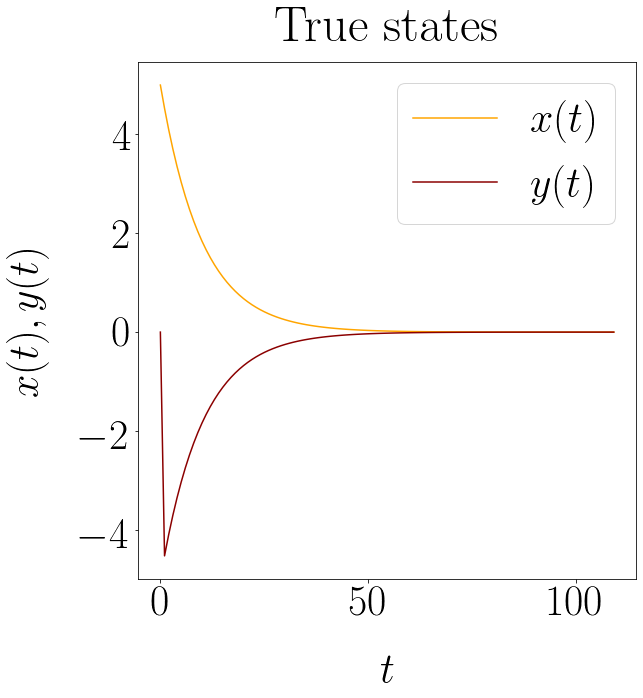

In [ ]:
import numpy as np
from tqdm import tqdm
length_h = 1000
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
     "font.sans-serif": ["Helvetica"]})
plt.rcParams['axes.titlepad'] = 20 
import matplotlib.cm as cm
plt.rcParams['axes.labelpad'] = 30


plt.figure(figsize=(10,10))
plt.plot(S[:,0],color='orange',label=r'$x(t)$')
plt.plot(S[:,1],color='darkred',label=r'$y(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$x(t),y(t)$')
plt.legend(loc='best')
plt.tight_layout()
plt.title('True states')
plt.savefig('stiffSystemInt_true.pdf',dpi=300,bbox_inches='tight')

In [ ]:
S.shape

(110, 2)

In [ ]:
S.shape

(110, 2)

In [ ]:
batch_size      = S.shape[0]
X_train = np.reshape(S,(int(S.shape[0]/batch_size),batch_size,S.shape[1]))
Y_train = np.reshape(S,(int(S.shape[0]/batch_size),batch_size,S.shape[1]))

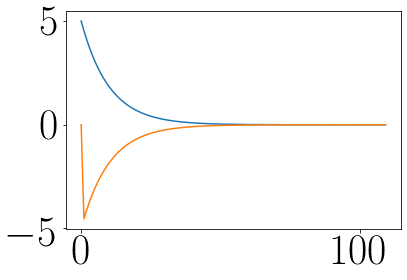

In [ ]:
plt.plot(X_train[0])

In [ ]:
# generating training data
class GD2:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -0.5
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog2, xt2, yo2 = generate_data(GD2)
#AnDA_RMSE(catalog.true_solution,catalog.euler_integration)
#AnDA_RMSE(catalog.true_solution,catalog.num_integration)
#training data
batch_size_lin = catalog2.true_solution[:-10-1,:].shape[0]
X_train_lin = np.reshape(catalog2.true_solution[:-10-1,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))
Grad_t_lin  = np.reshape(np.gradient(catalog2.true_solution[:-10-1,0])/GD.dt_integration,(X_train_lin.shape))
Y_train_lin = np.reshape(catalog2.true_solution[1:-10,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))

In [ ]:
params = {}#NN parameters 
params['order'] = 4
params['transition_layers']=1
params['bi_linear_layers']=2
params['dim_hidden_linear'] = 2
params['dim_input']=2
params['dim_observations'] = 2
params['dim_output']=2
params['dim_hidden']=2
params['dt_integration']=GD.dt_integration
params['ntrain']=[4000,0]
params['lr']=0.001
pretrained = False
path = '/content/drive/MyDrive/Colab Notebooks/RINN-master/Implicit_On_Linear_Stiff.pt'

In [ ]:
def jacobian_in_batch(y, x):
    '''
    Compute the Jacobian matrix in batch form.
    Return (B, D_y, D_x)
    '''

    batch = y.shape[0]
    single_y_size = np.prod(y.shape[1:])
    y = y.view(batch, -1)
    vector = torch.ones(batch).to(y)

    # Compute Jacobian row by row.
    # dy_i / dx -> dy / dx
    # (B, D) -> (B, 1, D) -> (B, D, D)
    jac = [torch.autograd.grad(y[:, i], x, 
                               grad_outputs=vector, 
                               retain_graph=True,
                               create_graph=True,
                               allow_unused=True)[0].view(batch, -1)
                for i in range(single_y_size)]
    jac = torch.stack(jac, dim=1)
    
    return jac
def kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

# Learn dynamical and integration models, stop when loss ~ 0.2

In [ ]:
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
class FC_net_true(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true, self).__init__()
            self.mu = GD.parameters.mu
        def forward(self, inp):
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = inp[:,0]#(1/self.eps)*(self.q*inp[:,1]-inp[:,0]*inp[:,1] +inp[:,0]*(1-inp[:,0]));
            grad[:,1] = -1000*inp[:,0]-1001*inp[:,1]#self.mu*(1-inp[:,0]**2)*inp[:,1] -inp[:,0]#(1/self.eps2)*(-self.q*inp[:,1]-inp[:,1]*inp[:,0]+self.f*inp[:,2]);
            return grad
model_true  = FC_net_true(params)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']) 
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =GD2.parameters.w
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model_lin  = FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model_true#model
            self.Dyn_net_lin = model_lin
            self.Dyn_net_True = model_true
            a = np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = np.random.uniform(size=(1,order))
            c = np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float(),requires_grad = True)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float(),requires_grad = True)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float(),requires_grad = True)
        def lin_flow(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_lin(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_lin(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_True_Model(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp
        def flow_RK45_True_Model(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def flow_RK45(self, inp,dt,order = 4):
            k1    = self.Dyn_net(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def opti_gain_lin(self, h_int, inp, order):
            gain = Variable(torch.zeros(h_int.size()).float())
            for i in range(h_int.shape[0]):
                pred ,tmp, tmpp =self.lin_flow(inp, h_int[i], order)
                gain[i] = tmpp[0]
                del pred, tmp, tmpp
            return gain
        def Linear_newton_method_solver(self,function, initial,inp,dt,order, iteration=20, convergence=0.00000001):
            for i in range(iteration): 
                previous_data = initial.clone()
                value = function(initial,inp,dt,order)
                
                jacs = jacobian_in_batch(self.Dyn_net(inp), inp)#, 2, 3, verbose=1)
                inc = torch.bmm(torch.inverse(torch.eye(initial.shape[-1]).unsqueeze(0).repeat(initial.shape[0],1,1)-dt*kron(self.a.repeat(jacs.shape[0],1,1),jacs)),value.unsqueeze(-1)).squeeze(-1) 
                # update 
                initial = initial + inc
                # zero out current gradient to hold new gradients in next iteration 
                #initial.grad.data.zero_() 
                # Check convergence. 
                # When difference current epoch result and previous one is less than 
                # convergence factor, return result.
                if torch.abs(initial - previous_data).sum() < torch.tensor(convergence):
                    return initial
            return initial # return our final after iteration                
        def newton_method_solver(self,function, initial,inp,dt,order, iteration=20, convergence=0.00000001):
            for i in range(iteration): 
                print('iteration ', i)
                previous_data = initial.clone()
                value = function(initial,inp,dt,order)
                jacs = jacobian_in_batch(value, initial)#, 2, 3, verbose=1)
                # update 
                initial = initial - torch.bmm(torch.inverse(jacs),value.unsqueeze(2)).squeeze(-1)#(value / initial.grad).data
                # zero out current gradient to hold new gradients in next iteration 
                #initial.grad.data.zero_() 
                # Check convergence. 
                # When difference current epoch result and previous one is less than 
                # convergence factor, return result.
                if torch.abs(initial - previous_data).sum() < torch.tensor(convergence):
                    return initial
            return initial # return our final after iteration
        def solve_function(self, kin, inp, dt, order):
            zin = inp.unsqueeze(1).repeat(1, order, 1).reshape(inp.shape[0],-1)
            fin = torch.zeros_like(zin)
            for i in range(order):
                fin[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]] = (self.Dyn_net(kin[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]]))
            all_in = zin - kin + torch.bmm(dt*(kron(self.a,torch.eye(inp.shape[-1]).unsqueeze(0))).repeat(fin.shape[0],1,1),fin.unsqueeze(-1)).squeeze(-1)           
            return all_in
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            #self.a.data[0,:,0] = self.c[0,:] - self.a[:,:,1:].sum(dim = 2)
            k_init = torch.ones_like(torch.stack(k).permute(1,0,2).reshape(inp.shape[0],-1))
            k_opti = self.Linear_newton_method_solver(self.solve_function, k_init,inp,dt,order, iteration=20, convergence=0.0000001)
            #print(k_opti[:,:6])
            pred_sum = torch.autograd.Variable(torch.zeros(inp.size()))
            for i in range(0,order):
                pred_sum = pred_sum+self.Dyn_net(k_opti[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]])*self.b[0,i].expand_as(k_opti[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/inp[0,:]
            return pred ,k_opti, gain 
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
            if hasattr(module, 'a'):
                module.a.data[0,:,0] = module.c.data[0,:] - module.a.data[:,:,1:].sum(dim = 2)


In [ ]:
x = Variable(torch.from_numpy(X_train).float())
y = Variable(torch.from_numpy(Y_train).float())

x_lin = Variable(torch.from_numpy(X_train_lin).float())
y_lin = Variable(torch.from_numpy(Y_train_lin).float())

hi = np.arange(0,5.0+0.000001,0.01)
h_int = Variable(torch.from_numpy(hi).float())
gain_true = Variable(torch.from_numpy(np.ones_like(h_int)).float())

# Construct our model by instantiating the class defined above
    
modelRINN = INT_net(params,params['order'])
    # Construct our loss function and an Optimizer. The call to model.parameters()

if pretrained :
        modelRINN.load_state_dict(torch.load(path))
criterion = torch.nn.MSELoss()
def customized_loss(x, y):
        gain_to_zero = ((x-y))**2
        return torch.mean(gain_to_zero)
optimizer = torch.optim.Adam(modelRINN.parameters(), lr = 0.1)
clipper = applyRK_Constraints()
def gradClamp(parameters, clip=5):
    for p in parameters:
        if p.grad !=None:
            p.grad.data.clamp_(min = -clip,max=clip)
#from visdom import Visdom
#import numpy as np
#import time

#  instantiate the window class 
#viz = Visdom() 




In [ ]:
optimizer = torch.optim.Adam(modelRINN.parameters(), lr = params['lr'])
#Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=100, threshold=0.001, threshold_mode='abs',min_lr=1e-6)

In [ ]:
def burst_sampling(x,dt = 0.1,ns = 8,nb = 20):
    burst_sample = [x[0,:ns,:]]
    for i in range(nb):
        sampling_location = np.random.randint(0, x.shape[1]-ns)
        burst_sample.append(x[0,sampling_location:sampling_location+ns,:])
    burst_sample = torch.stack(burst_sample)
    return burst_sample[:,:-1,:],burst_sample[:,1:,:]
  

In [ ]:
from tqdm import tqdm

ParamsList=[]
LossList=[]
MatricesList=[]
LearningRatesList=[]
SelectedBatchs=[]

print ('Learning dynamical model')
tmpx,tmpy = burst_sampling(x)
Batch=tmpx.shape[0]
Index=[i for i in range(Batch)]

BinaryVar=0
maxLoss=1e9
t=0
for t in tqdm(range(params['ntrain'][0])):

        maxLoss=0
        

        for b in range(tmpx.shape[0]):
            #b = 0
            tmpx.requires_grad = True
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(tmpx[b,:,:],params['dt_integration'],params['order'])
            pred2 ,grad , inp = modelRINN(pred,params['dt_integration'],params['order'])
            pred3 ,grad , inp = modelRINN(pred2,params['dt_integration'],params['order'])
            pred4 ,grad , inp = modelRINN(pred3,params['dt_integration'],params['order'])
            # Compute and print loss
            loss = criterion(pred[np.where(~np.isnan(pred.data.numpy()))], tmpy[b,:,:][np.where(~np.isnan(pred.data.numpy()))])#+criterion(pred2[:-1,:], pred[1:,:])+criterion(pred3[:-1,:], pred2[1:,:])+criterion(pred4[:-1,:], pred3[1:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            gradClamp(modelRINN.parameters())
            optimizer.step()
            modelRINN.apply(clipper)
            
            #torch.save(modelRINN.state_dict(), '/content/drive/MyDrive/Colab Notebooks/RINN-master/Implicit_On_Linear_Stiff_identification.pt')
            print(t,b,loss.detach().numpy())
            #Scheduler.step(loss)

            #if loss.detach().numpy()<1e-3:
              #Index.remove(b)
       
            
            if loss.detach().numpy()>maxLoss:
              maxLoss=loss.detach().numpy()

        #adjust_learning_rate(optimizer,t)
              
        
        LossList.append(maxLoss)
        SelectedBatchs.append(len(Index))
        #print(ParamsList)
        #print(MatricesList)
        if maxLoss<1e-3:
          break
        
        print(t,"maxLoss={}".format(maxLoss))

  0%|          | 0/4000 [00:00<?, ?it/s]

Learning dynamical model
0 0 1957551500000.0
0 1 1.0837217e-06
0 2 0.0024052975
0 3 0.16569735
0 4 9.585443e-09
0 5 0.0006039543
0 6 0.00013523691
0 7 7.0115944e-09
0 8 0.03254304
0 9 3.8315457e-06
0 10 9.168523e-09
0 11 0.00035752953
0 12 1.4399396e-09
0 13 1.4056435e-07
0 14 2.5353795e-09
0 15 1.6776875e-09
0 16 4.0481073e-06
0 17 0.008012148
0 18 2.952447e-07
0 19 0.0008735094


  0%|          | 1/4000 [00:06<7:07:05,  6.41s/it]

0 20 8.722497e-06
0 maxLoss=1957551538176.0
1 0 1283.6953
1 1 1.5633243e-07
1 2 0.0006859593
1 3 0.06746895
1 4 5.0340114e-09
1 5 0.00036470097
1 6 8.921183e-05
1 7 4.9124567e-09
1 8 0.023811044
1 9 2.9222176e-06
1 10 7.2100925e-09
1 11 0.00028804797
1 12 1.1822763e-09
1 13 1.1717902e-07
1 14 2.1401647e-09
1 15 1.4309658e-09
1 16 3.4829457e-06
1 17 0.0069447756
1 18 2.5763623e-07


  0%|          | 2/4000 [00:11<6:45:54,  6.09s/it]

1 19 0.00076665526
1 20 7.694188e-06
1 maxLoss=1283.6953125
2 0 374.41446
2 1 1.3970143e-07
2 2 0.0006173403
2 3 0.061078023
2 4 4.5844977e-09
2 5 0.00033380114
2 6 8.199847e-05
2 7 4.531569e-09
2 8 0.02203318
2 9 2.7117824e-06
2 10 6.706842e-09
2 11 0.0002685538
2 12 1.1043829e-09
2 13 1.09640794e-07
2 14 2.0054518e-09
2 15 1.3426394e-09
2 16 3.2717364e-06
2 17 0.0065303324
2 18 2.4249616e-07


  0%|          | 3/4000 [00:15<5:54:51,  5.33s/it]

2 19 0.0007222178
2 20 7.253723e-06
2 maxLoss=374.4144592285156
3 0 133.01102
3 1 1.32132e-07
3 2 0.00058515405
3 3 0.058002885
3 4 4.3613784e-09
3 5 0.00031804055
3 6 7.823114e-05
3 7 4.3284882e-09
3 8 0.021067157
3 9 2.5953293e-06
3 10 6.4238006e-09
3 11 0.00025742635
3 12 1.0593174e-09
3 13 1.0522875e-07
3 14 1.925746e-09
3 15 1.2898964e-09
3 16 3.1445204e-06
3 17 0.0062787742
3 18 2.3323378e-07
3 19 0.0006948461


  0%|          | 4/4000 [00:19<5:24:29,  4.87s/it]

3 20 6.980801e-06
3 maxLoss=133.01101684570312
4 0 41.768024
4 1 1.2736724e-07
4 2 0.0005647281
4 3 0.05603617
4 4 4.217466e-09
4 5 0.00030779623
4 6 7.576585e-05
4 7 4.194725e-09
4 8 0.02042793
4 9 2.5178233e-06
4 10 6.234496e-09
4 11 0.0002499512
4 12 1.0289286e-09
4 13 1.0224159e-07
4 14 1.8716142e-09
4 15 1.253955e-09
4 16 3.0575795e-06
4 17 0.0061064265
4 18 2.2687678e-07
4 19 0.00067601725


  0%|          | 5/4000 [00:23<5:15:01,  4.73s/it]

4 20 6.7925967e-06
4 maxLoss=41.76802444458008
5 0 8.407159
5 1 1.2405897e-07
5 2 0.0005504812
5 3 0.054659307
5 4 4.116253e-09
5 5 0.00030056605
5 6 7.4018964e-05
5 7 4.0996704e-09
5 8 0.019971862
5 9 2.4624208e-06
5 10 6.098841e-09
5 11 0.00024458164
5 12 1.0070417e-09
5 13 1.00087604e-07
5 14 1.8325252e-09
5 15 1.2279585e-09
5 16 2.9946416e-06
5 17 0.005981461
5 18 2.2225797e-07


  0%|          | 6/4000 [00:26<4:46:30,  4.30s/it]

5 19 0.00066232827
5 20 6.6557736e-06
5 maxLoss=8.407158851623535
6 0 0.5372971
6 1 1.2169575e-07
6 2 0.00054048223
6 3 0.053707514
6 4 4.0473505e-09
6 5 0.00029571194
6 6 7.28618e-05
6 7 4.03745e-09
6 8 0.019676523
6 9 2.4268868e-06
6 10 6.0126575e-09
6 11 0.00024119872
6 12 9.93373e-10
6 13 9.875024e-08
6 14 1.8083897e-09
6 15 1.2120083e-09
6 16 2.956211e-06
6 17 0.005905612
6 18 2.1946781e-07


  0%|          | 7/4000 [00:30<4:29:38,  4.05s/it]

6 19 0.0006540888
6 20 6.5736835e-06
6 maxLoss=0.5372971296310425
7 0 2.7919886
7 1 1.204095e-07
7 2 0.0005355732
7 3 0.053290512
7 4 4.02072e-09
7 5 0.0002940719
7 6 7.252723e-05
7 7 4.022266e-09
7 8 0.019617414
7 9 2.4212236e-06
7 10 6.002214e-09
7 11 0.00024091134
7 12 9.926701e-10
7 13 9.8723476e-08
7 14 1.8086306e-09
7 15 1.212589e-09
7 16 2.9586117e-06
7 17 0.005912072
7 18 2.197612e-07


  0%|          | 8/4000 [00:33<4:11:05,  3.77s/it]

7 19 0.00065511995
7 20 6.585371e-06
7 maxLoss=2.7919886112213135
8 0 2.0320137
8 1 1.2067508e-07
8 2 0.0005368658
8 3 0.053429432
8 4 4.0318002e-09
8 5 0.0002949313
8 6 7.2748306e-05
8 7 4.035021e-09
8 8 0.019681763
8 9 2.4294045e-06
8 10 6.0230287e-09
8 11 0.00024176316
8 12 9.962481e-10
8 13 9.908529e-08
8 14 1.8153805e-09
8 15 1.2171727e-09
8 16 2.9698697e-06
8 17 0.0059348713
8 18 2.2062093e-07
8 19 0.00065769535


  0%|          | 9/4000 [00:36<4:05:33,  3.69s/it]

8 20 6.6114144e-06
8 maxLoss=2.0320136547088623
9 0 0.9979376
9 1 1.2122139e-07
9 2 0.00053955877
9 3 0.05372151
9 4 4.0555124e-09
9 5 0.0002967747
9 6 7.3228824e-05
9 7 4.062965e-09
9 8 0.019823862
9 9 2.44757e-06
9 10 6.0696217e-09
9 11 0.00024368221
9 12 1.0043574e-09
9 13 9.990988e-08
9 14 1.8307812e-09
9 15 1.2276722e-09
9 16 2.9959094e-06
9 17 0.0059876335
9 18 2.2260448e-07


  0%|          | 10/4000 [00:40<4:07:04,  3.72s/it]

9 19 0.0006636751
9 20 6.6721727e-06
9 maxLoss=0.9979376196861267
10 0 0.8138384
10 1 1.2206183e-07
10 2 0.0005421787
10 3 0.05388272
10 4 4.0609742e-09
10 5 0.00029673727
10 6 7.3121766e-05
10 7 4.0521826e-09
10 8 0.019750014
10 9 2.436083e-06
10 10 6.035912e-09
10 11 0.00024214097
10 12 9.973028e-10
10 13 9.91464e-08
10 14 1.8157388e-09
10 15 1.2169662e-09
10 16 2.9684102e-06
10 17 0.005930196
10 18 2.2038623e-07


  0%|          | 11/4000 [00:44<3:59:19,  3.60s/it]

10 19 0.00065684685
10 20 6.6014945e-06
10 maxLoss=0.8138384222984314
11 0 1.3192126
11 1 1.2095687e-07
11 2 0.00053813675
11 3 0.053558625
11 4 4.0417545e-09
11 5 0.00029566514
11 6 7.29327e-05
11 7 4.0453427e-09
11 8 0.019732846
11 9 2.435752e-06
11 10 6.03901e-09
11 11 0.00024240966
11 12 9.98936e-10
11 13 9.935472e-08
11 14 1.8203316e-09
11 15 1.2205145e-09
11 16 2.9781247e-06
11 17 0.0059513184
11 18 2.2123508e-07


  0%|          | 12/4000 [00:47<3:54:19,  3.53s/it]

11 19 0.000659536
11 20 6.630034e-06
11 maxLoss=1.319212555885315
12 0 0.60355985
12 1 1.2155039e-07
12 2 0.0005409764
12 3 0.0538583
12 4 4.0655923e-09
12 5 0.00029749374
12 6 7.340163e-05
12 7 4.072346e-09
12 8 0.019868705
12 9 2.452989e-06
12 10 6.082927e-09
12 11 0.0002442085
12 12 1.0064912e-09
12 13 1.00120495e-07
12 14 1.8345718e-09
12 15 1.2302165e-09
12 16 3.0020074e-06
12 17 0.00599975
12 18 2.2305042e-07


  0%|          | 13/4000 [00:51<3:57:17,  3.57s/it]

12 19 0.0006650028
12 20 6.6853922e-06
12 maxLoss=0.6035598516464233
13 0 1.1943322
13 1 1.2230467e-07
13 2 0.0005432599
13 3 0.05399092
13 4 4.069154e-09
13 5 0.0002973364
13 6 7.327012e-05
13 7 4.060429e-09
13 8 0.019790351
13 9 2.4410986e-06
13 10 6.048294e-09
13 11 0.00024264208
13 12 9.993628e-10
13 13 9.9351325e-08
13 14 1.8194746e-09
13 15 1.219487e-09
13 16 2.9745777e-06
13 17 0.005942531
13 18 2.2084673e-07


  0%|          | 14/4000 [00:54<3:48:43,  3.44s/it]

13 19 0.00065821485
13 20 6.6152506e-06
13 maxLoss=1.194332242012024
14 0 0.8737664
14 1 1.2122612e-07
14 2 0.0005394048
14 3 0.05369054
14 4 4.052141e-09
14 5 0.00029645665
14 6 7.3133684e-05
14 7 4.056902e-09
14 8 0.019790601
14 9 2.4430417e-06
14 10 6.0574457e-09
14 11 0.00024316406
14 12 1.0020862e-09
14 13 9.967427e-08
14 14 1.8262484e-09
14 15 1.2245336e-09
14 16 2.98801e-06
14 17 0.0059713037
14 18 2.2198209e-07
14 19 0.0006617833


  0%|          | 15/4000 [00:57<3:45:26,  3.39s/it]

14 20 6.6527255e-06
14 maxLoss=0.8737664222717285
15 0 0.55939573
15 1 1.2176606e-07
15 2 0.00054112275
15 3 0.053800307
15 4 4.056252e-09
15 5 0.0002964863
15 6 7.30807e-05
15 7 4.0509223e-09
15 8 0.019748395
15 9 2.4364128e-06
15 10 6.0376784e-09
15 11 0.00024225561
15 12 9.979125e-10
15 13 9.921913e-08
15 14 1.8172707e-09
15 15 1.2181252e-09
15 16 2.9715313e-06
15 17 0.0059368713
15 18 2.2065316e-07


  0%|          | 16/4000 [01:01<3:56:39,  3.56s/it]

15 19 0.000657675
15 20 6.610255e-06
15 maxLoss=0.5593957304954529
16 0 0.9595476
16 1 1.2113073e-07
16 2 0.0005389419
16 3 0.053640403
16 4 4.0480943e-09
16 5 0.00029614428
16 6 7.3052724e-05
16 7 4.052182e-09
16 8 0.019766519
16 9 2.4399947e-06
16 10 6.0496594e-09
16 11 0.00024284134
16 12 1.0007394e-09
16 13 9.9536116e-08
16 14 1.8236601e-09
16 15 1.2227735e-09
16 16 2.983635e-06
16 17 0.005962527
16 18 2.2165192e-07
16 19 0.0006607861


  0%|          | 17/4000 [01:05<4:13:31,  3.82s/it]

16 20 6.642597e-06
16 maxLoss=0.9595475792884827
17 0 0.5220131
17 1 1.2167443e-07
17 2 0.0005410979
17 3 0.053830706
17 4 4.0607797e-09
17 5 0.00029696463
17 6 7.323088e-05
17 7 4.060854e-09
17 8 0.019803643
17 9 2.4439764e-06
17 10 6.0583e-09
17 11 0.0002431383
17 12 1.0017845e-09
17 13 9.962414e-08
17 14 1.8250438e-09
17 15 1.2235402e-09
17 16 2.9851476e-06
17 17 0.0059648976
17 18 2.2171896e-07


  0%|          | 18/4000 [01:10<4:32:40,  4.11s/it]

17 19 0.00066093047
17 20 6.643592e-06
17 maxLoss=0.5220131278038025
18 0 0.5225116
18 1 1.2167075e-07
18 2 0.00054101425
18 3 0.05381773
18 4 4.0594763e-09
18 5 0.00029684821
18 6 7.3196585e-05
18 7 4.05869e-09
18 8 0.019792099
18 9 2.4424558e-06
18 10 6.054227e-09
18 11 0.0002429644
18 12 1.0010349e-09
18 13 9.954668e-08
18 14 1.8235599e-09
18 15 1.2224991e-09
18 16 2.9825655e-06
18 17 0.0059596137
18 18 2.2151937e-07


  0%|          | 19/4000 [01:14<4:31:27,  4.09s/it]

18 19 0.00066033
18 20 6.6373746e-06
18 maxLoss=0.5225116014480591
19 0 0.53102964
19 1 1.216166e-07
19 2 0.00054102787
19 3 0.05384115
19 4 4.0627772e-09
19 5 0.00029718992
19 6 7.330401e-05
19 7 4.065776e-09
19 8 0.019831741
19 9 2.4478438e-06
19 10 6.068874e-09
19 11 0.00024360124
19 12 1.0038074e-09
19 13 9.983736e-08
19 14 1.8291381e-09
19 15 1.2264083e-09
19 16 2.9923954e-06
19 17 0.0059799007
19 18 2.2229271e-07
19 19 0.0006626796


  0%|          | 20/4000 [01:18<4:33:15,  4.12s/it]

19 20 6.66159e-06
19 maxLoss=0.5310296416282654
20 0 0.6680353
20 1 1.2188342e-07
20 2 0.0005414827
20 3 0.053822633
20 4 4.0570494e-09
20 5 0.0002964878
20 6 7.30693e-05
20 7 4.04969e-09
20 8 0.019739807
20 9 2.4350652e-06
20 10 6.033697e-09
20 11 0.0002420765
20 12 9.970946e-10
20 13 9.9130276e-08
20 14 1.8155462e-09
20 15 1.2169011e-09
20 16 2.96837e-06
20 17 0.0059303567
20 18 2.2040116e-07
20 19 0.0006569013


  1%|          | 21/4000 [01:23<4:41:24,  4.24s/it]

20 20 6.602263e-06
20 maxLoss=0.6680353283882141
21 0 1.1870083
21 1 1.2094571e-07
21 2 0.0005379699
21 3 0.053530835
21 4 4.0389283e-09
21 5 0.00029541695
21 6 7.2859744e-05
21 7 4.0408135e-09
21 8 0.019708218
21 9 2.4324659e-06
21 10 6.0302123e-09
21 11 0.0002420375
21 12 9.973148e-10
21 13 9.91865e-08
21 14 1.8171373e-09
21 15 1.2182868e-09
21 16 2.9725154e-06
21 17 0.0059398967
21 18 2.208004e-07


  1%|          | 22/4000 [01:27<4:46:30,  4.32s/it]

21 19 0.00065821555
21 20 6.616487e-06
21 maxLoss=1.187008261680603
22 0 0.76933175
22 1 1.2125518e-07
22 2 0.00053947204
22 3 0.053691465
22 4 4.051808e-09
22 5 0.00029640572
22 6 7.311567e-05
22 7 4.055559e-09
22 8 0.01978268
22 9 2.441982e-06
22 10 6.0544467e-09
22 11 0.0002430294
22 12 1.0014968e-09
22 13 9.9610375e-08
22 14 1.8250048e-09
22 15 1.2236757e-09
22 16 2.9858124e-06
22 17 0.005966722
22 18 2.2180843e-07


  1%|          | 23/4000 [01:32<4:45:47,  4.31s/it]

22 19 0.00066125154
22 20 6.6471953e-06
22 maxLoss=0.7693317532539368
23 0 0.5380854
23 1 1.2171623e-07
23 2 0.00054110406
23 3 0.053816084
23 4 4.058616e-09
23 5 0.00029673855
23 6 7.316023e-05
23 7 4.056166e-09
23 8 0.01977773
23 9 2.4404014e-06
23 10 6.048565e-09
23 11 0.00024272199
23 12 9.999531e-10
23 13 9.9432974e-08
23 14 1.8213565e-09
23 15 1.2209787e-09
23 16 2.9786866e-06
23 17 0.0059516067
23 18 2.21214e-07


  1%|          | 24/4000 [01:36<4:44:33,  4.29s/it]

23 19 0.0006593837
23 20 6.627755e-06
23 maxLoss=0.538085401058197
24 0 0.58774763
24 1 1.2144578e-07
24 2 0.0005403042
24 3 0.05377255
24 4 4.057804e-09
24 5 0.00029684012
24 6 7.3221265e-05
24 7 4.0613375e-09
24 8 0.019810665
24 9 2.445361e-06
24 10 6.0628076e-09
24 11 0.00024336367
24 12 1.0028648e-09
24 13 9.974548e-08
24 14 1.8274836e-09
24 15 1.2253071e-09
24 16 2.9897808e-06
24 17 0.0059746937
24 18 2.2210244e-07
24 19 0.0006621235


  1%|          | 25/4000 [01:40<4:40:38,  4.24s/it]

24 20 6.6559955e-06
24 maxLoss=0.5877476334571838
25 0 0.619427
25 1 1.2183645e-07
25 2 0.00054148445
25 3 0.053840518
25 4 4.059536e-09
25 5 0.00029674443
25 6 7.314835e-05
25 7 4.0548827e-09
25 8 0.019768491
25 9 2.4389483e-06
25 10 6.044336e-09
25 11 0.0002425266
25 12 9.990526e-10
25 13 9.9336e-08
25 14 1.8194611e-09
25 15 1.2196272e-09
25 16 2.9751939e-06
25 17 0.00594438
25 18 2.2093218e-07
25 19 0.00065852556


  1%|          | 26/4000 [01:44<4:41:41,  4.25s/it]

25 20 6.6188195e-06
25 maxLoss=0.6194270253181458
26 0 0.71001476
26 1 1.2126495e-07
26 2 0.0005394364
26 3 0.053681273
26 4 4.0506194e-09
26 5 0.0002962879
26 6 7.3080075e-05
26 7 4.053229e-09
26 8 0.01977001
26 9 2.4401998e-06
26 10 6.0497447e-09
26 11 0.00024282774
26 12 1.0006121e-09
26 13 9.9517806e-08
26 14 1.8232426e-09
26 15 1.2224348e-09
26 16 2.9826829e-06
26 17 0.0059603876
26 18 2.2156749e-07


  1%|          | 27/4000 [01:49<4:48:46,  4.36s/it]

26 19 0.00066051085
26 20 6.639718e-06
26 maxLoss=0.7100147604942322
27 0 0.5216013
27 1 1.2162259e-07
27 2 0.00054087926
27 3 0.053810198
27 4 4.059375e-09
27 5 0.00029686678
27 6 7.3208874e-05
27 7 4.0596877e-09
27 8 0.019798487
27 9 2.443371e-06
27 10 6.0568346e-09
27 11 0.00024308427
27 12 1.0015762e-09
27 13 9.960451e-08
27 14 1.8246903e-09
27 15 1.2233005e-09
27 16 2.9846303e-06
27 17 0.0059639374
27 18 2.2168423e-07
27 19 0.0006608277


  1%|          | 28/4000 [01:53<4:40:33,  4.24s/it]

27 20 6.642608e-06
27 maxLoss=0.5216013193130493
28 0 0.5248147
28 1 1.2164915e-07
28 2 0.00054090464
28 3 0.05380576
28 4 4.058557e-09
28 5 0.00029676987
28 6 7.317726e-05
28 7 4.0575605e-09
28 8 0.019786352
28 9 2.4417022e-06
28 10 6.0522356e-09
28 11 0.0002428859
28 12 1.0006945e-09
28 13 9.951278e-08
28 14 1.8229189e-09
28 15 1.2220814e-09
28 16 2.9815117e-06
28 17 0.005957466
28 18 2.2143901e-07


  1%|          | 29/4000 [01:57<4:31:02,  4.10s/it]

28 19 0.0006600811
28 20 6.6349307e-06
28 maxLoss=0.5248147249221802
29 0 0.5298235
29 1 1.2154891e-07
29 2 0.00054064183
29 3 0.05379448
29 4 4.0586574e-09
29 5 0.0002968551
29 6 7.321353e-05
29 7 4.0603783e-09
29 8 0.019803297
29 9 2.4441981e-06
29 10 6.059214e-09
29 11 0.0002431968
29 12 1.0020924e-09
29 13 9.96621e-08
29 14 1.8257921e-09
29 15 1.2241195e-09
29 16 2.9867062e-06
29 17 0.005968214
29 18 2.2185303e-07


  1%|          | 30/4000 [02:00<4:15:04,  3.86s/it]

29 19 0.0006613457
29 20 6.6479893e-06
29 maxLoss=0.5298234820365906
30 0 0.5486966
30 1 1.2171368e-07
30 2 0.0005410446
30 3 0.053806443
30 4 4.057642e-09
30 5 0.00029664728
30 6 7.313343e-05
30 7 4.0545016e-09
30 8 0.019768583
30 9 2.4392302e-06
30 10 6.045318e-09
30 11 0.00024258529
30 12 9.993616e-10
30 13 9.937186e-08
30 14 1.8201958e-09
30 15 1.2201671e-09
30 16 2.9766973e-06
30 17 0.005947425
30 18 2.21056e-07


  1%|          | 31/4000 [02:04<4:13:49,  3.84s/it]

30 19 0.0006589143
30 20 6.6229395e-06
30 maxLoss=0.5486965775489807
31 0 0.6278323
31 1 1.2134767e-07
31 2 0.0005398246
31 3 0.05372117
31 4 4.053708e-09
31 5 0.00029652187
31 6 7.3138675e-05
31 7 4.056572e-09
31 8 0.01978651
31 9 2.4423068e-06
31 10 6.055062e-09
31 11 0.00024304294
31 12 1.0015222e-09
31 13 9.960929e-08
31 14 1.8249281e-09
31 15 1.2235691e-09
31 16 2.9855041e-06
31 17 0.0059660636
31 18 2.2177758e-07


  1%|          | 32/4000 [02:07<4:10:17,  3.78s/it]

31 19 0.0006611509
31 20 6.646088e-06
31 maxLoss=0.627832293510437
32 0 0.54400676
32 1 1.2169151e-07
32 2 0.00054098695
32 3 0.05380484
32 4 4.057756e-09
32 5 0.00029667438
32 6 7.314379e-05
32 7 4.0552455e-09
32 8 0.019772919
32 9 2.4398437e-06
32 10 6.0470997e-09
32 11 0.00024266253
32 12 9.997078e-10
32 13 9.940857e-08
32 14 1.8209038e-09
32 15 1.2206692e-09
32 16 2.9779328e-06
32 17 0.0059501277
32 18 2.2115806e-07


  1%|          | 33/4000 [02:11<4:10:42,  3.79s/it]

32 19 0.0006592213
32 20 6.626105e-06
32 maxLoss=0.5440067648887634
33 0 0.5797218
33 1 1.2140687e-07
33 2 0.00054008875
33 3 0.053747576
33 4 4.0556993e-09
33 5 0.00029666867
33 6 7.317525e-05
33 7 4.0586468e-09
33 8 0.019796863
33 9 2.4435537e-06
33 10 6.058187e-09
33 11 0.00024316882
33 12 1.0020351e-09
33 13 9.9660916e-08
33 14 1.8258743e-09
33 15 1.2242162e-09
33 16 2.9870691e-06
33 17 0.005969264


  1%|          | 34/4000 [02:15<4:16:00,  3.87s/it]

33 18 2.2189442e-07
33 19 0.00066149427
33 20 6.6496145e-06
33 maxLoss=0.5797218084335327
34 0 0.5763963
34 1 1.2173483e-07
34 2 0.0005410956
34 3 0.053808194
34 4 4.057514e-09
34 5 0.00029662074
34 6 7.312396e-05
34 7 4.0537738e-09
34 8 0.019764423
34 9 2.4386043e-06
34 10 6.0436953e-09
34 11 0.00024250963
34 12 9.990354e-10
34 13 9.9337704e-08
34 14 1.8195376e-09
34 15 1.2196909e-09
34 16 2.9754642e-06
34 17 0.005945016
34 18 2.2096503e-07


  1%|          | 35/4000 [02:20<4:28:04,  4.06s/it]

34 19 0.0006586253
34 20 6.619889e-06
34 maxLoss=0.5763962864875793
35 0 0.64717454
35 1 1.2128254e-07
35 2 0.0005395103
35 3 0.053686917
35 4 4.050903e-09
35 5 0.00029630333
35 6 7.308233e-05
35 7 4.0533252e-09
35 8 0.019770069
35 9 2.4401909e-06
35 10 6.0496292e-09
35 11 0.00024281994
35 12 1.0005773e-09
35 13 9.9514075e-08
35 14 1.8231485e-09
35 15 1.2223652e-09
35 16 2.9825064e-06
35 17 0.005959965
35 18 2.2154946e-07


  1%|          | 36/4000 [02:23<4:17:08,  3.89s/it]

35 19 0.0006604552
35 20 6.639125e-06
35 maxLoss=0.6471745371818542
36 0 0.5233993
36 1 1.2160007e-07
36 2 0.00054072984
36 3 0.053792138
36 4 4.0576937e-09
36 5 0.00029672825
36 6 7.3170246e-05
36 7 4.0573833e-09
36 8 0.019786363
36 9 2.4417607e-06
36 10 6.052637e-09
36 11 0.00024290764
36 12 1.0008162e-09
36 13 9.952675e-08
36 14 1.8232101e-09
36 15 1.2223044e-09
36 16 2.9820712e-06
36 17 0.0059587182
36 18 2.2148767e-07
36 19 0.0006602331


  1%|          | 37/4000 [02:27<4:08:07,  3.76s/it]

36 20 6.636535e-06
36 maxLoss=0.523399293422699
37 0 0.521371
37 1 1.2155593e-07
37 2 0.00054056133
37 3 0.053778566
37 4 4.0568575e-09
37 5 0.00029667746
37 6 7.316038e-05
37 7 4.056956e-09
37 8 0.019784968
37 9 2.4416615e-06
37 10 6.0525776e-09
37 11 0.00024291048
37 12 1.0008445e-09
37 13 9.953176e-08
37 14 1.823327e-09
37 15 1.2223991e-09
37 16 2.9823593e-06
37 17 0.0059593176
37 18 2.215144e-07
37 19 0.0006603164


  1%|          | 38/4000 [02:31<4:11:00,  3.80s/it]

37 20 6.6374623e-06
37 maxLoss=0.5213710069656372
38 0 0.5215776
38 1 1.2156883e-07
38 2 0.0005406053
38 3 0.053780444
38 4 4.0569303e-09
38 5 0.00029667746
38 6 7.3158866e-05
38 7 4.056789e-09
38 8 0.019783702
38 9 2.4415062e-06
38 10 6.0520526e-09
38 11 0.00024288511
38 12 1.0007316e-09
38 13 9.9519596e-08
38 14 1.8230875e-09
38 15 1.2222248e-09
38 16 2.9819437e-06
38 17 0.0059584095
38 18 2.2147795e-07


  1%|          | 39/4000 [02:34<4:08:47,  3.77s/it]

38 19 0.0006602086
38 20 6.636343e-06
38 maxLoss=0.5215775966644287
39 0 0.5213598
39 1 1.2155392e-07
39 2 0.00054055435
39 3 0.05377712
39 4 4.05679e-09
39 5 0.00029667345
39 6 7.315934e-05
39 7 4.0569614e-09
39 8 0.019784736
39 9 2.4416674e-06
39 10 6.052472e-09
39 11 0.0002429083
39 12 1.0008406e-09
39 13 9.953099e-08
39 14 1.8233307e-09
39 15 1.2223939e-09
39 16 2.9823757e-06
39 17 0.0059593567
39 18 2.2151445e-07
39 19 0.00066032034


  1%|          | 40/4000 [02:39<4:20:02,  3.94s/it]

39 20 6.6374523e-06
39 maxLoss=0.5213598012924194
40 0 0.5216903
40 1 1.2156902e-07
40 2 0.0005405979
40 3 0.053779807
40 4 4.0568127e-09
40 5 0.00029666597
40 6 7.315539e-05
40 7 4.0566475e-09
40 8 0.01978289
40 9 2.4413675e-06
40 10 6.0516534e-09
40 11 0.00024287231
40 12 1.0006713e-09
40 13 9.951414e-08
40 14 1.8229789e-09
40 15 1.2221408e-09
40 16 2.9817231e-06
40 17 0.005958044
40 18 2.2146183e-07


  1%|          | 41/4000 [02:42<4:09:31,  3.78s/it]

40 19 0.0006601629
40 20 6.635784e-06
40 maxLoss=0.521690309047699
41 0 0.5214159
41 1 1.2154423e-07
41 2 0.00054052053
41 3 0.053775188
41 4 4.0566626e-09
41 5 0.00029666533
41 6 7.31584e-05
41 7 4.056879e-09
41 8 0.01978448
41 9 2.441643e-06
41 10 6.052526e-09
41 11 0.00024291124
41 12 1.0008443e-09
41 13 9.953279e-08
41 14 1.823344e-09
41 15 1.2224165e-09
41 16 2.9824348e-06
41 17 0.005959519
41 18 2.2151815e-07


  1%|          | 42/4000 [02:46<4:02:38,  3.68s/it]

41 19 0.00066033384
41 20 6.637655e-06
41 maxLoss=0.5214158892631531
42 0 0.5220092
42 1 1.2156944e-07
42 2 0.000540601
42 3 0.053779095
42 4 4.056726e-09
42 5 0.0002966575
42 6 7.315229e-05
42 7 4.0564294e-09
42 8 0.019781427
42 9 2.441209e-06
42 10 6.0512915e-09
42 11 0.00024285314
42 12 1.0005813e-09
42 13 9.9504724e-08
42 14 1.8227981e-09
42 15 1.2220239e-09
42 16 2.9814496e-06
42 17 0.0059574316
42 18 2.2143988e-07


  1%|          | 43/4000 [02:49<4:06:55,  3.74s/it]

42 19 0.0006600935
42 20 6.635081e-06
42 maxLoss=0.5220091938972473
43 0 0.5217121
43 1 1.2153367e-07
43 2 0.0005404841
43 3 0.053771492
43 4 4.056486e-09
43 5 0.00029665983
43 6 7.3157345e-05
43 7 4.056854e-09
43 8 0.019784648
43 9 2.4417047e-06
43 10 6.0526593e-09
43 11 0.00024291853
43 12 1.0008934e-09
43 13 9.953738e-08
43 14 1.8234385e-09
43 15 1.2224836e-09
43 16 2.982614e-06
43 17 0.0059598633
43 18 2.2153509e-07


  1%|          | 44/4000 [02:53<4:06:47,  3.74s/it]

43 19 0.00066038704
43 20 6.6381567e-06
43 maxLoss=0.5217121243476868
44 0 0.5229202
44 1 1.2157425e-07
44 2 0.00054060534
44 3 0.053778626
44 4 4.056618e-09
44 5 0.0002966431
44 6 7.314837e-05
44 7 4.056106e-09
44 8 0.019779816
44 9 2.440945e-06
44 10 6.050523e-09
44 11 0.00024282162
44 12 1.0004516e-09
44 13 9.948989e-08
44 14 1.822502e-09
44 15 1.2218194e-09
44 16 2.9809105e-06
44 17 0.005956436
44 18 2.2139936e-07
44 19 0.0006599688


  1%|          | 45/4000 [02:57<4:09:12,  3.78s/it]

44 20 6.633852e-06
44 maxLoss=0.5229201912879944
45 0 0.52287865
45 1 1.2151526e-07
45 2 0.0005404172
45 3 0.053767554
45 4 4.0562926e-09
45 5 0.0002966527
45 6 7.315818e-05
45 7 4.056996e-09
45 8 0.019785589
45 9 2.4418482e-06
45 10 6.05315e-09
45 11 0.00024294318
45 12 1.0010018e-09
45 13 9.954882e-08
45 14 1.8236845e-09
45 15 1.2226495e-09
45 16 2.9830478e-06
45 17 0.0059608286
45 18 2.2157114e-07


  1%|          | 46/4000 [03:01<4:18:28,  3.92s/it]

45 19 0.0006604977
45 20 6.6393322e-06
45 maxLoss=0.5228786468505859
46 0 0.5257099
46 1 1.2158992e-07
46 2 0.0005406464
46 3 0.053780105
46 4 4.0565102e-09
46 5 0.00029662502
46 6 7.314071e-05
46 7 4.055594e-09
46 8 0.019776613
46 9 2.4404962e-06
46 10 6.049305e-09
46 11 0.00024276601
46 12 1.0002105e-09
46 13 9.946403e-08
46 14 1.8220068e-09
46 15 1.2214748e-09
46 16 2.9800362e-06
46 17 0.005954568
46 18 2.2132927e-07


  1%|          | 47/4000 [03:06<4:34:01,  4.16s/it]

46 19 0.00065975887
46 20 6.631645e-06
46 maxLoss=0.5257099270820618
47 0 0.5274843
47 1 1.2148294e-07
47 2 0.00054031814
47 3 0.053760413
47 4 4.0559827e-09
47 5 0.00029664199
47 6 7.3158895e-05
47 7 4.0572514e-09
47 8 0.01978764
47 9 2.4421704e-06
47 10 6.0541616e-09
47 11 0.000242988
47 12 1.0012203e-09
47 13 9.957322e-08
47 14 1.824156e-09
47 15 1.2229963e-09
47 16 2.9839214e-06
47 17 0.005962713
47 18 2.216449e-07
47 19 0.00066072214


  1%|          | 48/4000 [03:10<4:33:30,  4.15s/it]

47 20 6.641535e-06
47 maxLoss=0.5274842977523804
48 0 0.5345016
48 1 1.2161829e-07
48 2 0.0005407158
48 3 0.053781442
48 4 4.056299e-09
48 5 0.00029658698
48 6 7.312632e-05
48 7 4.0544834e-09
48 8 0.019770274
48 9 2.4395902e-06
48 10 6.04674e-09
48 11 0.00024265827
48 12 9.997153e-10
48 13 9.941216e-08
48 14 1.8210018e-09
48 15 1.2207606e-09
48 16 2.978243e-06
48 17 0.005950825
48 18 2.2118762e-07
48 19 0.0006593183


  1%|          | 49/4000 [03:14<4:31:02,  4.12s/it]

48 20 6.6271286e-06
48 maxLoss=0.5345016121864319
49 0 0.5478626
49 1 1.2141676e-07
49 2 0.00054009503
49 3 0.05374496
49 4 4.055276e-09
49 5 0.00029661896
49 6 7.3159594e-05
49 7 4.05758e-09
49 8 0.019790947
49 9 2.442739e-06
49 10 6.0559104e-09
49 11 0.0002430729
49 12 1.0016101e-09
49 13 9.9616095e-08
49 14 1.8250325e-09
49 15 1.2236111e-09
49 16 2.9855578e-06
49 17 0.005966026
49 18 2.2177316e-07
49 19 0.00066112407


  1%|▏         | 50/4000 [03:18<4:20:01,  3.95s/it]

49 20 6.6458697e-06
49 maxLoss=0.5478625893592834
50 0 0.56366765
50 1 1.2167281e-07
50 2 0.00054085994
50 3 0.053788
50 4 4.0561576e-09
50 5 0.00029654094
50 6 7.310653e-05
50 7 4.052995e-09
50 8 0.019761097
50 9 2.438272e-06
50 10 6.0429763e-09
50 11 0.00024249087
50 12 9.989752e-10
50 13 9.933258e-08
50 14 1.8194751e-09
50 15 1.2196839e-09
50 16 2.97547e-06
50 17 0.0059451344
50 18 2.2096783e-07


  1%|▏         | 51/4000 [03:21<4:07:43,  3.76s/it]

50 19 0.00065864157
50 20 6.620233e-06
50 maxLoss=0.5636676549911499
51 0 0.6091971
51 1 1.2129091e-07
51 2 0.00053954794
51 3 0.053691603
51 4 4.0512904e-09
51 5 0.000296334
51 6 7.3090676e-05
51 7 4.0538346e-09
51 8 0.019772528
51 9 2.440536e-06
51 10 6.0503793e-09
51 11 0.00024285351
51 12 1.0007205e-09
51 13 9.952902e-08
51 14 1.8234332e-09
51 15 1.2225441e-09
51 16 2.9829469e-06
51 17 0.005960895
51 18 2.2158585e-07


  1%|▏         | 52/4000 [03:24<3:56:23,  3.59s/it]

51 19 0.00066056167
51 20 6.6402063e-06
51 maxLoss=0.6091970801353455
52 0 0.5352374
52 1 1.2160143e-07
52 2 0.00054065685
52 3 0.05377798
52 4 4.0561976e-09
52 5 0.00029658605
52 6 7.31288e-05
52 7 4.054726e-09
52 8 0.019771872
52 9 2.4398282e-06
52 10 6.0474554e-09
52 11 0.00024268693
52 12 9.998569e-10
52 13 9.9426835e-08
52 14 1.8213162e-09
52 15 1.2209852e-09
52 16 2.9787934e-06
52 17 0.005951914
52 18 2.2122894e-07


  1%|▏         | 53/4000 [03:28<4:09:42,  3.80s/it]

52 19 0.0006594547
52 20 6.6285825e-06
52 maxLoss=0.5352373719215393
53 0 0.53178096
53 1 1.2142687e-07
53 2 0.0005400741
53 3 0.05373623
53 4 4.0542156e-09
53 5 0.00029651696
53 6 7.312831e-05
53 7 4.0555803e-09
53 8 0.019779468
53 9 2.4412025e-06
53 10 6.051773e-09
53 11 0.00024289209
53 12 1.0008222e-09
53 13 9.953413e-08
53 14 1.8234588e-09
53 15 1.2225219e-09
53 16 2.9828113e-06
53 17 0.005960408
53 18 2.2156074e-07
53 19 0.00066046644


  1%|▏         | 54/4000 [03:32<4:10:35,  3.81s/it]

53 20 6.6391253e-06
53 maxLoss=0.5317809581756592
54 0 0.5318282
54 1 1.2158219e-07
54 2 0.000540584
54 3 0.05377179
54 4 4.055798e-09
54 5 0.00029656157
54 6 7.312353e-05
54 7 4.054488e-09
54 8 0.019771118
54 9 2.4397557e-06
54 10 6.0472938e-09
54 11 0.00024268364
54 12 9.998558e-10
54 13 9.942665e-08
54 14 1.8213238e-09
54 15 1.2209941e-09
54 16 2.9788355e-06
54 17 0.005952072
54 18 2.2123547e-07


  1%|▏         | 55/4000 [03:36<4:16:37,  3.90s/it]

54 19 0.0006594726
54 20 6.6287116e-06
54 maxLoss=0.5318282246589661
55 0 0.52987206
55 1 1.2142824e-07
55 2 0.0005400726
55 3 0.05373579
55 4 4.0541104e-09
55 5 0.00029650386
55 6 7.312467e-05
55 7 4.0553036e-09
55 8 0.01977809
55 9 2.4410253e-06
55 10 6.0512564e-09
55 11 0.00024286876
55 12 1.0007206e-09
55 13 9.9523795e-08
55 14 1.8232534e-09
55 15 1.2223823e-09
55 16 2.9824391e-06
55 17 0.005959663
55 18 2.2153124e-07


  1%|▏         | 56/4000 [03:41<4:30:43,  4.12s/it]

55 19 0.0006603861
55 20 6.638263e-06
55 maxLoss=0.5298720598220825
56 0 0.52957696
56 1 1.2156825e-07
56 2 0.000540544
56 3 0.053768557
56 4 4.055628e-09
56 5 0.0002965559
56 6 7.312303e-05
56 7 4.0545283e-09
56 8 0.019771283
56 9 2.4398134e-06
56 10 6.0475815e-09
56 11 0.00024269595
56 12 9.999049e-10
56 13 9.94339e-08
56 14 1.8214656e-09
56 15 1.2210852e-09
56 16 2.9791104e-06
56 17 0.0059525883
56 18 2.2125855e-07
56 19 0.000659539


  1%|▏         | 57/4000 [03:45<4:19:56,  3.96s/it]

56 20 6.6294338e-06
56 maxLoss=0.5295769572257996
57 0 0.5266521
57 1 1.2143691e-07
57 2 0.000540099
57 3 0.053736772
57 4 4.0540944e-09
57 5 0.00029649856
57 6 7.312151e-05
57 7 4.055051e-09
57 8 0.019776633
57 9 2.4407855e-06
57 10 6.0505694e-09
57 11 0.00024284176
57 12 1.000593e-09
57 13 9.951009e-08
57 14 1.8230171e-09
57 15 1.2221958e-09
57 16 2.9819942e-06
57 17 0.005958727
57 18 2.2149447e-07


  1%|▏         | 58/4000 [03:48<4:14:11,  3.87s/it]

57 19 0.0006602753
57 20 6.637049e-06
57 maxLoss=0.5266520977020264
58 0 0.5268108
58 1 1.2155081e-07
58 2 0.00054047344
58 3 0.05376337
58 4 4.0553347e-09
58 5 0.00029654172
58 6 7.312063e-05
58 7 4.054477e-09
58 8 0.019771388
58 9 2.439868e-06
58 10 6.0476952e-09
58 11 0.00024270467
58 12 9.999565e-10
58 13 9.943789e-08
58 14 1.8215628e-09
58 15 1.2211727e-09
58 16 2.9793252e-06
58 17 0.0059531103
58 18 2.2127695e-07


  1%|▏         | 59/4000 [03:52<4:19:57,  3.96s/it]

58 19 0.00065959484
58 20 6.6300445e-06
58 maxLoss=0.5268108248710632
59 0 0.524224
59 1 1.214458e-07
59 2 0.0005401227
59 3 0.053738035
59 4 4.0540926e-09
59 5 0.00029649332
59 6 7.31185e-05
59 7 4.0548005e-09
59 8 0.019775134
59 9 2.4405601e-06
59 10 6.049852e-09
59 11 0.00024280926
59 12 1.0004266e-09
59 13 9.9492254e-08
59 14 1.8226098e-09
59 15 1.2219276e-09
59 16 2.981264e-06
59 17 0.005957187
59 18 2.214366e-07


  2%|▏         | 60/4000 [03:57<4:36:43,  4.21s/it]

59 19 0.0006600954
59 20 6.635161e-06
59 maxLoss=0.5242239832878113
60 0 0.52357066
60 1 1.2152007e-07
60 2 0.00054037163
60 3 0.0537547
60 4 4.0548107e-09
60 5 0.0002965109
60 6 7.311515e-05
60 7 4.054265e-09
60 8 0.019770827
60 9 2.4398626e-06
60 10 6.0478036e-09
60 11 0.00024271199
60 12 9.999975e-10
60 13 9.9445224e-08
60 14 1.821703e-09
60 15 1.2212817e-09
60 16 2.979617e-06
60 17 0.005953673
60 18 2.2130045e-07


  2%|▏         | 61/4000 [04:01<4:30:29,  4.12s/it]

60 19 0.00065967493
60 20 6.6309212e-06
60 maxLoss=0.5235706567764282
61 0 0.52183765
61 1 1.2145597e-07
61 2 0.00054014433
61 3 0.053738665
61 4 4.053986e-09
61 5 0.00029647636
61 6 7.3112686e-05
61 7 4.054328e-09
61 8 0.019772192
61 9 2.4401174e-06
61 10 6.0487513e-09
61 11 0.00024275723
61 12 1.0002222e-09
61 13 9.9469396e-08
61 14 1.8222116e-09
61 15 1.2216372e-09
61 16 2.9805512e-06
61 17 0.005955743
61 18 2.2138072e-07
61 19 0.0006599188


  2%|▏         | 62/4000 [04:05<4:26:16,  4.06s/it]

61 20 6.6334355e-06
61 maxLoss=0.5218376517295837
62 0 0.52180284
62 1 1.2149319e-07
62 2 0.00054026005
62 3 0.053745788
62 4 4.054264e-09
62 5 0.0002964775
62 6 7.310872e-05
62 7 4.054024e-09
62 8 0.019769838
62 9 2.4397527e-06
62 10 6.0476997e-09
62 11 0.00024270962
62 12 9.999982e-10
62 13 9.944601e-08
62 14 1.8217385e-09
62 15 1.2213208e-09
62 16 2.979699e-06
62 17 0.005953975
62 18 2.2131199e-07


  2%|▏         | 63/4000 [04:09<4:15:12,  3.89s/it]

62 19 0.0006597067
62 20 6.63132e-06
62 maxLoss=0.5218028426170349
63 0 0.5210346
63 1 1.2146069e-07
63 2 0.0005401492
63 3 0.05373612
63 4 4.0536876e-09
63 5 0.00029644143
63 6 7.3102136e-05
63 7 4.0537276e-09
63 8 0.019769032
63 9 2.439705e-06
63 10 6.047646e-09
63 11 0.00024271088
63 12 1.0000366e-09
63 13 9.944972e-08
63 14 1.8218345e-09
63 15 1.2213869e-09
63 16 2.9799007e-06
63 17 0.005954433
63 18 2.213318e-07
63 19 0.0006597702


  2%|▏         | 64/4000 [04:13<4:16:43,  3.91s/it]

63 20 6.631929e-06
63 maxLoss=0.5210345983505249
64 0 0.52106506
64 1 1.2146732e-07
64 2 0.00054016244
64 3 0.05373675
64 4 4.053659e-09
64 5 0.00029643739
64 6 7.310052e-05
64 7 4.05357e-09
64 8 0.019767864
64 9 2.4395515e-06
64 10 6.0472076e-09
64 11 0.00024269428
64 12 9.999405e-10
64 13 9.943954e-08
64 14 1.8216555e-09
64 15 1.2212598e-09
64 16 2.9795742e-06
64 17 0.0059537636
64 18 2.2130409e-07


  2%|▏         | 65/4000 [04:17<4:24:21,  4.03s/it]

64 19 0.00065969053
64 20 6.631111e-06
64 maxLoss=0.5210650563240051
65 0 0.5209044
65 1 1.2145178e-07
65 2 0.00054009823
65 3 0.053731196
65 4 4.053274e-09
65 5 0.00029641026
65 6 7.309441e-05
65 7 4.0531876e-09
65 8 0.01976658
65 9 2.4393944e-06
65 10 6.046832e-09
65 11 0.00024267945
65 12 9.998887e-10
65 13 9.943558e-08
65 14 1.8215702e-09
65 15 1.2212016e-09
65 16 2.9794685e-06
65 17 0.0059535215
65 18 2.2129566e-07


  2%|▏         | 66/4000 [04:21<4:33:27,  4.17s/it]

65 19 0.00065966503
65 20 6.630866e-06
65 maxLoss=0.5209044218063354
66 0 0.5208916
66 1 1.2144804e-07
66 2 0.0005400808
66 3 0.053728905
66 4 4.0530805e-09
66 5 0.0002963956
66 6 7.309142e-05
66 7 4.0530326e-09
66 8 0.019765602
66 9 2.4392666e-06
66 10 6.046578e-09
66 11 0.00024266339
66 12 9.998324e-10
66 13 9.94308e-08
66 14 1.8214628e-09
66 15 1.2211224e-09
66 16 2.979265e-06
66 17 0.00595311
66 18 2.2128316e-07
66 19 0.00065962144


  2%|▏         | 67/4000 [04:25<4:12:42,  3.86s/it]

66 20 6.6304956e-06
66 maxLoss=0.5208916068077087
67 0 0.5208578
67 1 1.2143921e-07
67 2 0.00054004986
67 3 0.05372574
67 4 4.052849e-09
67 5 0.00029637624
67 6 7.308605e-05
67 7 4.05274e-09
67 8 0.019764291
67 9 2.4391186e-06
67 10 6.0461103e-09
67 11 0.00024264843
67 12 9.997763e-10
67 13 9.942267e-08
67 14 1.8213437e-09
67 15 1.2210438e-09
67 16 2.979081e-06
67 17 0.0059527652
67 18 2.2126731e-07


  2%|▏         | 68/4000 [04:29<4:30:15,  4.12s/it]

67 19 0.0006595794
67 20 6.6300336e-06
67 maxLoss=0.5208578109741211
68 0 0.5208213
68 1 1.2143322e-07
68 2 0.000540015
68 3 0.05372224
68 4 4.0525774e-09
68 5 0.00029635685
68 6 7.308168e-05
68 7 4.0525197e-09
68 8 0.019763008
68 9 2.4389608e-06
68 10 6.0457563e-09
68 11 0.0002426357
68 12 9.99706e-10
68 13 9.9417875e-08
68 14 1.8212293e-09
68 15 1.2209842e-09
68 16 2.978921e-06
68 17 0.005952376
68 18 2.212555e-07


  2%|▏         | 69/4000 [04:33<4:15:55,  3.91s/it]

68 19 0.0006595428
68 20 6.629616e-06
68 maxLoss=0.5208212733268738
69 0 0.5207943
69 1 1.2142571e-07
69 2 0.0005399826
69 3 0.053718653
69 4 4.0523376e-09
69 5 0.00029634166
69 6 7.3077405e-05
69 7 4.05226e-09
69 8 0.019761814
69 9 2.438781e-06
69 10 6.045401e-09
69 11 0.00024262133
69 12 9.996447e-10
69 13 9.941118e-08
69 14 1.8211093e-09
69 15 1.2208924e-09
69 16 2.9787614e-06
69 17 0.0059520355
69 18 2.2124266e-07


  2%|▏         | 70/4000 [04:36<4:07:33,  3.78s/it]

69 19 0.00065950584
69 20 6.629244e-06
69 maxLoss=0.5207942724227905
70 0 0.52076095
70 1 1.2141828e-07
70 2 0.00053994585
70 3 0.053715676
70 4 4.0521373e-09
70 5 0.000296325
70 6 7.3072915e-05
70 7 4.0520067e-09
70 8 0.01976056
70 9 2.438639e-06
70 10 6.044977e-09
70 11 0.00024260594
70 12 9.995872e-10
70 13 9.940458e-08
70 14 1.8210013e-09
70 15 1.2208222e-09
70 16 2.978531e-06
70 17 0.005951646
70 18 2.2122632e-07
70 19 0.0006594587


  2%|▏         | 71/4000 [04:40<4:02:40,  3.71s/it]

70 20 6.6288226e-06
70 maxLoss=0.5207609534263611
71 0 0.5207318
71 1 1.2141041e-07
71 2 0.00053991773
71 3 0.05371214
71 4 4.0518273e-09
71 5 0.0002963047
71 6 7.306773e-05
71 7 4.0517665e-09
71 8 0.019759348
71 9 2.438502e-06
71 10 6.0445826e-09
71 11 0.0002425888
71 12 9.995208e-10
71 13 9.939847e-08
71 14 1.8208853e-09
71 15 1.2207403e-09
71 16 2.9783623e-06
71 17 0.0059512523
71 18 2.2121435e-07


  2%|▏         | 72/4000 [04:43<3:52:00,  3.54s/it]

71 19 0.0006594178
71 20 6.6283933e-06
71 maxLoss=0.5207318067550659
72 0 0.5206968
72 1 1.2140188e-07
72 2 0.00053988217
72 3 0.05370871
72 4 4.051548e-09
72 5 0.0002962847
72 6 7.306293e-05
72 7 4.0515213e-09
72 8 0.019758195
72 9 2.4383364e-06
72 10 6.0442624e-09
72 11 0.00024257398
72 12 9.994551e-10
72 13 9.93924e-08
72 14 1.8207548e-09
72 15 1.2206721e-09
72 16 2.978152e-06
72 17 0.0059508746
72 18 2.2119681e-07
72 19 0.0006593773


  2%|▏         | 73/4000 [04:47<4:04:02,  3.73s/it]

72 20 6.6279567e-06
72 maxLoss=0.5206968188285828
73 0 0.5206641
73 1 1.2139448e-07
73 2 0.000539843
73 3 0.05370515
73 4 4.05131e-09
73 5 0.0002962662
73 6 7.305845e-05
73 7 4.051196e-09
73 8 0.019756809
73 9 2.438153e-06
73 10 6.0437766e-09
73 11 0.00024255675
73 12 9.993835e-10
73 13 9.938561e-08
73 14 1.820634e-09
73 15 1.2205853e-09
73 16 2.977973e-06
73 17 0.005950458
73 18 2.2118529e-07


  2%|▏         | 74/4000 [04:51<4:06:03,  3.76s/it]

73 19 0.0006593326
73 20 6.627561e-06
73 maxLoss=0.5206640958786011
74 0 0.52063304
74 1 1.2138733e-07
74 2 0.0005398085
74 3 0.05370199
74 4 4.051034e-09
74 5 0.00029624518
74 6 7.30534e-05
74 7 4.0509547e-09
74 8 0.01975528
74 9 2.4380136e-06
74 10 6.043401e-09
74 11 0.00024254216
74 12 9.993332e-10
74 13 9.9379676e-08
74 14 1.8205398e-09
74 15 1.2205025e-09
74 16 2.9777764e-06
74 17 0.005950132
74 18 2.2116977e-07


  2%|▏         | 75/4000 [04:56<4:36:39,  4.23s/it]

74 19 0.00065928884
74 20 6.627089e-06
74 maxLoss=0.5206330418586731
75 0 0.52059114
75 1 1.2137836e-07
75 2 0.0005397707
75 3 0.053698312
75 4 4.05075e-09
75 5 0.0002962274
75 6 7.3048985e-05
75 7 4.0506936e-09
75 8 0.019753989
75 9 2.4378494e-06
75 10 6.043012e-09
75 11 0.00024252532
75 12 9.992583e-10
75 13 9.937298e-08
75 14 1.8203916e-09
75 15 1.2204202e-09
75 16 2.9775454e-06
75 17 0.005949708
75 18 2.2115428e-07
75 19 0.000659242


  2%|▏         | 76/4000 [05:00<4:24:21,  4.04s/it]

75 20 6.626605e-06
75 maxLoss=0.520591139793396
76 0 0.52056134
76 1 1.2136913e-07
76 2 0.00053973304
76 3 0.053694602
76 4 4.0505057e-09
76 5 0.00029620502
76 6 7.304381e-05
76 7 4.050404e-09
76 8 0.019752769
76 9 2.437688e-06
76 10 6.0426295e-09
76 11 0.00024250908
76 12 9.991895e-10
76 13 9.936573e-08
76 14 1.8202799e-09
76 15 1.2203394e-09
76 16 2.9773496e-06
76 17 0.0059493296
76 18 2.2114223e-07
76 19 0.00065919705


  2%|▏         | 77/4000 [05:03<4:08:31,  3.80s/it]

76 20 6.626197e-06
76 maxLoss=0.5205613374710083
77 0 0.5205265
77 1 1.2136208e-07
77 2 0.0005397023
77 3 0.05369058
77 4 4.0502264e-09
77 5 0.00029618441
77 6 7.3038915e-05
77 7 4.0501424e-09
77 8 0.0197515
77 9 2.4375197e-06
77 10 6.0422094e-09
77 11 0.00024249351
77 12 9.99117e-10
77 13 9.93585e-08
77 14 1.8201581e-09
77 15 1.2202707e-09
77 16 2.9771277e-06
77 17 0.005948913
77 18 2.2112476e-07


  2%|▏         | 78/4000 [05:07<4:16:49,  3.93s/it]

77 19 0.00065914786
77 20 6.625716e-06
77 maxLoss=0.5205265283584595
78 0 0.5204887
78 1 1.213538e-07
78 2 0.0005396653
78 3 0.05368728
78 4 4.0499475e-09
78 5 0.00029616538
78 6 7.303363e-05
78 7 4.049873e-09
78 8 0.019749988
78 9 2.4373417e-06
78 10 6.041752e-09
78 11 0.00024247468
78 12 9.99052e-10
78 13 9.9350494e-08
78 14 1.8200266e-09
78 15 1.2201637e-09
78 16 2.9769576e-06
78 17 0.0059484732
78 18 2.2110778e-07


  2%|▏         | 79/4000 [05:11<4:15:17,  3.91s/it]

78 19 0.00065910176
78 20 6.6252746e-06
78 maxLoss=0.5204886794090271
79 0 0.5204472
79 1 1.2134568e-07
79 2 0.0005396227
79 3 0.053683054
79 4 4.0496437e-09
79 5 0.00029614643
79 6 7.302912e-05
79 7 4.0495687e-09
79 8 0.019748759
79 9 2.4371636e-06
79 10 6.041347e-09
79 11 0.00024245676
79 12 9.989856e-10
79 13 9.934519e-08
79 14 1.819903e-09
79 15 1.2200863e-09
79 16 2.976742e-06
79 17 0.0059479955
79 18 2.2109442e-07
79 19 0.00065906026


  2%|▏         | 80/4000 [05:15<4:10:45,  3.84s/it]

79 20 6.624855e-06
79 maxLoss=0.5204471945762634
80 0 0.5204101
80 1 1.2133548e-07
80 2 0.00053958397
80 3 0.053679295
80 4 4.0493338e-09
80 5 0.0002961224
80 6 7.3023766e-05
80 7 4.0492867e-09
80 8 0.019747308
80 9 2.4369851e-06
80 10 6.0409264e-09
80 11 0.00024243789
80 12 9.989016e-10
80 13 9.933662e-08
80 14 1.8197629e-09
80 15 1.219993e-09
80 16 2.976522e-06
80 17 0.00594759
80 18 2.2107487e-07


  2%|▏         | 81/4000 [05:19<4:10:08,  3.83s/it]

80 19 0.00065900886
80 20 6.6243083e-06
80 maxLoss=0.5204101204872131
81 0 0.52037627
81 1 1.213275e-07
81 2 0.00053954223
81 3 0.053675476
81 4 4.0490735e-09
81 5 0.00029610185
81 6 7.301797e-05
81 7 4.0490167e-09
81 8 0.019745732
81 9 2.4368383e-06
81 10 6.0404566e-09
81 11 0.00024242185
81 12 9.988337e-10
81 13 9.93298e-08
81 14 1.81963e-09
81 15 1.2199057e-09
81 16 2.976304e-06
81 17 0.0059471866
81 18 2.2105931e-07
81 19 0.0006589634


  2%|▏         | 82/4000 [05:21<3:50:10,  3.52s/it]

81 20 6.623799e-06
81 maxLoss=0.5203762650489807
82 0 0.5203361
82 1 1.2131794e-07
82 2 0.00053950725
82 3 0.053671576
82 4 4.0487493e-09
82 5 0.00029607807
82 6 7.3012896e-05
82 7 4.0486867e-09
82 8 0.019744338
82 9 2.4366443e-06
82 10 6.0400156e-09
82 11 0.00024240302
82 12 9.987562e-10
82 13 9.932322e-08
82 14 1.8195072e-09
82 15 1.2198124e-09
82 16 2.9760631e-06
82 17 0.005946742
82 18 2.2104594e-07


  2%|▏         | 83/4000 [05:25<3:54:50,  3.60s/it]

82 19 0.0006589126
82 20 6.623293e-06
82 maxLoss=0.5203360915184021
83 0 0.5203023
83 1 1.2130894e-07
83 2 0.0005394659
83 3 0.0536673
83 4 4.0484447e-09
83 5 0.00029605834
83 6 7.300718e-05
83 7 4.048355e-09
83 8 0.019742986
83 9 2.4364394e-06
83 10 6.039617e-09
83 11 0.00024238462
83 12 9.986819e-10
83 13 9.931462e-08
83 14 1.8193782e-09
83 15 1.2197281e-09
83 16 2.9758432e-06
83 17 0.0059463056
83 18 2.2102783e-07
83 19 0.0006588637


  2%|▏         | 84/4000 [05:30<4:11:00,  3.85s/it]

83 20 6.6228686e-06
83 maxLoss=0.5203022956848145
84 0 0.52026284
84 1 1.2130009e-07
84 2 0.00053942413
84 3 0.05366365
84 4 4.0481583e-09
84 5 0.00029603517
84 6 7.300133e-05
84 7 4.048074e-09
84 8 0.01974139
84 9 2.4362578e-06
84 10 6.0391376e-09
84 11 0.00024236782
84 12 9.986066e-10
84 13 9.9307556e-08
84 14 1.8192271e-09
84 15 1.2196294e-09
84 16 2.975606e-06
84 17 0.005945862
84 18 2.2101241e-07
84 19 0.000658813


  2%|▏         | 85/4000 [05:33<4:01:07,  3.70s/it]

84 20 6.6223133e-06
84 maxLoss=0.5202628374099731
85 0 0.5202194
85 1 1.2129185e-07
85 2 0.0005393835
85 3 0.053659525
85 4 4.0478745e-09
85 5 0.0002960135
85 6 7.299598e-05
85 7 4.047768e-09
85 8 0.019739699
85 9 2.436093e-06
85 10 6.038648e-09
85 11 0.00024235
85 12 9.985275e-10
85 13 9.9300784e-08
85 14 1.8190798e-09
85 15 1.219529e-09
85 16 2.9753967e-06
85 17 0.0059453845
85 18 2.2099468e-07


  2%|▏         | 86/4000 [05:38<4:21:31,  4.01s/it]

85 19 0.00065876206
85 20 6.6218176e-06
85 maxLoss=0.5202193856239319
86 0 0.5201808
86 1 1.2128098e-07
86 2 0.0005393399
86 3 0.05365544
86 4 4.04757e-09
86 5 0.0002959887
86 6 7.299043e-05
86 7 4.047428e-09
86 8 0.019738434
86 9 2.4358687e-06
86 10 6.038149e-09
86 11 0.00024232981
86 12 9.984517e-10
86 13 9.9292855e-08
86 14 1.8189394e-09
86 15 1.2194386e-09
86 16 2.9751675e-06
86 17 0.0059448746
86 18 2.2097677e-07


  2%|▏         | 87/4000 [05:42<4:24:08,  4.05s/it]

86 19 0.0006587122
86 20 6.6212965e-06
86 maxLoss=0.5201808214187622
87 0 0.5201407
87 1 1.2127218e-07
87 2 0.0005393026
87 3 0.053650882
87 4 4.0472012e-09
87 5 0.0002959644
87 6 7.298478e-05
87 7 4.047116e-09
87 8 0.019736791
87 9 2.4357275e-06
87 10 6.037701e-09
87 11 0.00024231007
87 12 9.983773e-10
87 13 9.928435e-08
87 14 1.818795e-09
87 15 1.2193421e-09
87 16 2.974935e-06
87 17 0.0059444425
87 18 2.209595e-07


  2%|▏         | 88/4000 [05:45<4:15:04,  3.91s/it]

87 19 0.00065866
87 20 6.62084e-06
87 maxLoss=0.5201407074928284
88 0 0.5200997
88 1 1.2126205e-07
88 2 0.00053925515
88 3 0.053646695
88 4 4.0468753e-09
88 5 0.00029594303
88 6 7.2978415e-05
88 7 4.0468024e-09
88 8 0.019735279
88 9 2.4354927e-06
88 10 6.03723e-09
88 11 0.00024229092
88 12 9.982927e-10
88 13 9.927732e-08
88 14 1.8186502e-09
88 15 1.2192439e-09
88 16 2.9746684e-06
88 17 0.005943942
88 18 2.2094063e-07


  2%|▏         | 89/4000 [05:49<4:05:14,  3.76s/it]

88 19 0.00065860694
88 20 6.620265e-06
88 maxLoss=0.5200996994972229
89 0 0.5200569
89 1 1.2125282e-07
89 2 0.00053921394
89 3 0.053642593
89 4 4.04655e-09
89 5 0.00029592033
89 6 7.2972376e-05
89 7 4.046469e-09
89 8 0.019733649
89 9 2.4353017e-06
89 10 6.0367733e-09
89 11 0.00024227091
89 12 9.982221e-10
89 13 9.926863e-08
89 14 1.8185109e-09
89 15 1.2191517e-09
89 16 2.9744572e-06
89 17 0.005943469
89 18 2.2092387e-07


  2%|▏         | 90/4000 [05:53<4:11:03,  3.85s/it]

89 19 0.0006585498
89 20 6.6196844e-06
89 maxLoss=0.5200569033622742
90 0 0.5200171
90 1 1.2124296e-07
90 2 0.000539166
90 3 0.053638075
90 4 4.046227e-09
90 5 0.0002958924
90 6 7.296703e-05
90 7 4.0461523e-09
90 8 0.019731896
90 9 2.4350904e-06
90 10 6.0362075e-09
90 11 0.0002422509
90 12 9.981209e-10
90 13 9.926009e-08
90 14 1.8183586e-09
90 15 1.2190433e-09
90 16 2.9741846e-06
90 17 0.005943046
90 18 2.2090408e-07


  2%|▏         | 91/4000 [05:57<4:08:25,  3.81s/it]

90 19 0.00065850245
90 20 6.619162e-06
90 maxLoss=0.5200170874595642
91 0 0.5199664
91 1 1.2123355e-07
91 2 0.0005391222
91 3 0.05363335
91 4 4.045887e-09
91 5 0.0002958689
91 6 7.296066e-05
91 7 4.045815e-09
91 8 0.019730344
91 9 2.4349106e-06
91 10 6.0357275e-09
91 11 0.00024223351
91 12 9.980418e-10
91 13 9.925258e-08
91 14 1.8181998e-09
91 15 1.2189382e-09
91 16 2.9739344e-06
91 17 0.005942464
91 18 2.2088862e-07
91 19 0.00065844314


  2%|▏         | 92/4000 [06:01<4:17:30,  3.95s/it]

91 20 6.6186317e-06
91 maxLoss=0.5199664235115051
92 0 0.5199341
92 1 1.212245e-07
92 2 0.00053907797
92 3 0.053629268
92 4 4.045576e-09
92 5 0.00029584477
92 6 7.295445e-05
92 7 4.045471e-09
92 8 0.01972853
92 9 2.4347075e-06
92 10 6.035171e-09
92 11 0.00024220852
92 12 9.979584e-10
92 13 9.924424e-08
92 14 1.8180455e-09
92 15 1.2188431e-09
92 16 2.9737053e-06
92 17 0.0059419004
92 18 2.2087019e-07
92 19 0.00065838813


  2%|▏         | 93/4000 [06:04<4:09:50,  3.84s/it]

92 20 6.618044e-06
92 maxLoss=0.5199341177940369
93 0 0.5198908
93 1 1.2121187e-07
93 2 0.000539037
93 3 0.05362445
93 4 4.045205e-09
93 5 0.00029581875
93 6 7.29481e-05
93 7 4.0451216e-09
93 8 0.019726839
93 9 2.4344847e-06
93 10 6.034677e-09
93 11 0.00024218984
93 12 9.97875e-10
93 13 9.923538e-08
93 14 1.8178837e-09
93 15 1.2187399e-09
93 16 2.9734342e-06
93 17 0.0059414646
93 18 2.2085057e-07


  2%|▏         | 94/4000 [06:09<4:16:50,  3.95s/it]

93 19 0.0006583342
93 20 6.617462e-06
93 maxLoss=0.5198907852172852
94 0 0.51984614
94 1 1.2120219e-07
94 2 0.0005389823
94 3 0.0536197
94 4 4.0448414e-09
94 5 0.0002957945
94 6 7.294234e-05
94 7 4.0447765e-09
94 8 0.019725192
94 9 2.4342785e-06
94 10 6.0342216e-09
94 11 0.00024217015
94 12 9.977893e-10
94 13 9.922615e-08
94 14 1.8177314e-09
94 15 1.2186285e-09
94 16 2.973199e-06
94 17 0.0059409984
94 18 2.2082918e-07


  2%|▏         | 95/4000 [06:12<4:11:10,  3.86s/it]

94 19 0.0006582739
94 20 6.6168477e-06
94 maxLoss=0.5198461413383484
95 0 0.51979846
95 1 1.2119055e-07
95 2 0.00053893926
95 3 0.053615015
95 4 4.0445065e-09
95 5 0.00029576826
95 6 7.2935414e-05
95 7 4.044431e-09
95 8 0.019723477
95 9 2.4340868e-06
95 10 6.033658e-09
95 11 0.00024214997
95 12 9.977021e-10
95 13 9.9217104e-08
95 14 1.8175619e-09
95 15 1.2185274e-09
95 16 2.9729279e-06
95 17 0.005940471
95 18 2.2081106e-07
95 19 0.00065821916


  2%|▏         | 96/4000 [06:17<4:34:23,  4.22s/it]

95 20 6.616336e-06
95 maxLoss=0.5197984576225281
96 0 0.5197493
96 1 1.2118093e-07
96 2 0.00053889205
96 3 0.053610522
96 4 4.0441503e-09
96 5 0.00029574364
96 6 7.292971e-05
96 7 4.044069e-09
96 8 0.019721823
96 9 2.4338478e-06
96 10 6.033073e-09
96 11 0.00024212789
96 12 9.976165e-10
96 13 9.920826e-08
96 14 1.817401e-09
96 15 1.2184154e-09
96 16 2.9726828e-06
96 17 0.00593989
96 18 2.2079045e-07


  2%|▏         | 97/4000 [06:22<4:38:11,  4.28s/it]

96 19 0.0006581592
96 20 6.6157804e-06
96 maxLoss=0.5197492837905884
97 0 0.5197071
97 1 1.2117053e-07
97 2 0.0005388424
97 3 0.05360515
97 4 4.0438035e-09
97 5 0.00029571643
97 6 7.2922085e-05
97 7 4.0437107e-09
97 8 0.019720048
97 9 2.4336514e-06
97 10 6.032535e-09
97 11 0.00024210424
97 12 9.975196e-10
97 13 9.920035e-08
97 14 1.8172448e-09
97 15 1.2182989e-09
97 16 2.9723944e-06
97 17 0.005939362
97 18 2.2077192e-07
97 19 0.0006581008


  2%|▏         | 98/4000 [06:26<4:27:50,  4.12s/it]

97 20 6.6151083e-06
97 maxLoss=0.5197070837020874
98 0 0.5196547
98 1 1.2115895e-07
98 2 0.000538797
98 3 0.053600404
98 4 4.043389e-09
98 5 0.00029568616
98 6 7.2916155e-05
98 7 4.0432946e-09
98 8 0.019718263
98 9 2.4334108e-06
98 10 6.031955e-09
98 11 0.00024208495
98 12 9.974268e-10
98 13 9.919131e-08
98 14 1.8170796e-09
98 15 1.2181957e-09
98 16 2.9721245e-06
98 17 0.00593879
98 18 2.2075213e-07
98 19 0.0006580426


  2%|▏         | 99/4000 [06:29<4:12:25,  3.88s/it]

98 20 6.6145362e-06
98 maxLoss=0.5196546912193298
99 0 0.5196072
99 1 1.2114701e-07
99 2 0.00053874735
99 3 0.053595904
99 4 4.0430623e-09
99 5 0.00029566066
99 6 7.290954e-05
99 7 4.0429633e-09
99 8 0.019716319
99 9 2.4331678e-06
99 10 6.0314513e-09
99 11 0.00024206085
99 12 9.973425e-10
99 13 9.9182195e-08
99 14 1.8168981e-09
99 15 1.2180826e-09
99 16 2.9718365e-06
99 17 0.0059382888
99 18 2.2072922e-07


  2%|▎         | 100/4000 [06:34<4:28:56,  4.14s/it]

99 19 0.0006579837
99 20 6.6139546e-06
99 maxLoss=0.5196071863174438
100 0 0.5195643
100 1 1.2113668e-07
100 2 0.0005386948
100 3 0.053590562
100 4 4.042688e-09
100 5 0.00029563459
100 6 7.2902556e-05
100 7 4.042567e-09
100 8 0.01971454
100 9 2.43296e-06
100 10 6.0308953e-09
100 11 0.00024203646
100 12 9.972478e-10
100 13 9.917191e-08
100 14 1.8167441e-09
100 15 1.2179731e-09
100 16 2.971566e-06
100 17 0.005937726
100 18 2.2070883e-07


  3%|▎         | 101/4000 [06:37<4:15:11,  3.93s/it]

100 19 0.00065791066
100 20 6.613281e-06
100 maxLoss=0.5195642709732056
101 0 0.51951736
101 1 1.2112548e-07
101 2 0.0005386481
101 3 0.053586632
101 4 4.042316e-09
101 5 0.00029560583
101 6 7.289578e-05
101 7 4.0421884e-09
101 8 0.019712629
101 9 2.4327405e-06
101 10 6.030358e-09
101 11 0.00024201673
101 12 9.971575e-10
101 13 9.9163614e-08
101 14 1.816576e-09
101 15 1.2178598e-09
101 16 2.9712605e-06
101 17 0.0059371623
101 18 2.2068787e-07
101 19 0.0006578526


  3%|▎         | 102/4000 [06:41<4:22:08,  4.04s/it]

101 20 6.612684e-06
101 maxLoss=0.5195173621177673
102 0 0.5194709
102 1 1.2111441e-07
102 2 0.00053859584
102 3 0.05358104
102 4 4.0419277e-09
102 5 0.0002955771
102 6 7.288895e-05
102 7 4.041825e-09
102 8 0.019710917
102 9 2.432492e-06
102 10 6.0297403e-09
102 11 0.00024199153
102 12 9.970613e-10
102 13 9.9154356e-08
102 14 1.8164105e-09
102 15 1.2177389e-09
102 16 2.9710159e-06
102 17 0.0059365975
102 18 2.2066861e-07
102 19 0.00065779506


  3%|▎         | 103/4000 [06:44<4:04:51,  3.77s/it]

102 20 6.612047e-06
102 maxLoss=0.5194708704948425
103 0 0.5194171
103 1 1.2110169e-07
103 2 0.00053853943
103 3 0.05357552
103 4 4.041539e-09
103 5 0.00029554762
103 6 7.288179e-05
103 7 4.0413943e-09
103 8 0.019708827
103 9 2.4322696e-06
103 10 6.0291643e-09
103 11 0.00024196881
103 12 9.96965e-10
103 13 9.914421e-08
103 14 1.8162085e-09
103 15 1.2176162e-09
103 16 2.9707421e-06
103 17 0.0059360107
103 18 2.2064705e-07
103 19 0.0006577275


  3%|▎         | 104/4000 [06:48<4:00:33,  3.70s/it]

103 20 6.6113635e-06
103 maxLoss=0.5194171071052551
104 0 0.51936543
104 1 1.2109076e-07
104 2 0.00053848804
104 3 0.053570308
104 4 4.041118e-09
104 5 0.00029552096
104 6 7.287493e-05
104 7 4.040991e-09
104 8 0.019706953
104 9 2.432034e-06
104 10 6.028549e-09
104 11 0.00024194444
104 12 9.968671e-10
104 13 9.9134084e-08
104 14 1.8160425e-09
104 15 1.2174989e-09
104 16 2.9704154e-06
104 17 0.0059353733
104 18 2.2062555e-07


  3%|▎         | 105/4000 [06:52<3:57:36,  3.66s/it]

104 19 0.00065766275
104 20 6.6107787e-06
104 maxLoss=0.5193654298782349
105 0 0.5193121
105 1 1.2107886e-07
105 2 0.00053843396
105 3 0.053564917
105 4 4.0407255e-09
105 5 0.00029549052
105 6 7.286721e-05
105 7 4.040605e-09
105 8 0.019704955
105 9 2.4317644e-06
105 10 6.027998e-09
105 11 0.00024191954
105 12 9.967696e-10
105 13 9.912452e-08
105 14 1.8158761e-09
105 15 1.2173759e-09
105 16 2.9701228e-06
105 17 0.005934854
105 18 2.2060189e-07


  3%|▎         | 106/4000 [06:55<4:01:58,  3.73s/it]

105 19 0.00065759465
105 20 6.6100906e-06
105 maxLoss=0.5193120837211609
106 0 0.51926535
106 1 1.210666e-07
106 2 0.00053838216
106 3 0.053559463
106 4 4.040296e-09
106 5 0.00029546086
106 6 7.286017e-05
106 7 4.0402157e-09
106 8 0.019703057
106 9 2.431528e-06
106 10 6.027328e-09
106 11 0.00024189691
106 12 9.966585e-10
106 13 9.9113926e-08
106 14 1.8156749e-09
106 15 1.2172527e-09
106 16 2.9698342e-06
106 17 0.005934247
106 18 2.2058236e-07
106 19 0.0006575378


  3%|▎         | 107/4000 [07:00<4:21:56,  4.04s/it]

106 20 6.6094517e-06
106 maxLoss=0.519265353679657
107 0 0.5192091
107 1 1.2105467e-07
107 2 0.0005383251
107 3 0.0535539
107 4 4.0398924e-09
107 5 0.00029543237
107 6 7.285214e-05
107 7 4.0398045e-09
107 8 0.019701002
107 9 2.431303e-06
107 10 6.0267324e-09
107 11 0.00024187131
107 12 9.965582e-10
107 13 9.910527e-08
107 14 1.8155094e-09
107 15 1.2171352e-09
107 16 2.9695436e-06
107 17 0.005933635
107 18 2.2055802e-07


  3%|▎         | 108/4000 [07:05<4:37:54,  4.28s/it]

107 19 0.0006574643
107 20 6.608781e-06
107 maxLoss=0.519209086894989
108 0 0.5191566
108 1 1.2104113e-07
108 2 0.0005382733
108 3 0.05354869
108 4 4.039508e-09
108 5 0.00029539992
108 6 7.284526e-05
108 7 4.039385e-09
108 8 0.019699072
108 9 2.4310448e-06
108 10 6.0260628e-09
108 11 0.00024184737
108 12 9.964664e-10
108 13 9.909367e-08
108 14 1.8153016e-09
108 15 1.2170048e-09
108 16 2.969205e-06
108 17 0.005933013
108 18 2.2053499e-07
108 19 0.00065740134


  3%|▎         | 109/4000 [07:10<4:42:44,  4.36s/it]

108 20 6.6079947e-06
108 maxLoss=0.5191565752029419
109 0 0.51910347
109 1 1.2102906e-07
109 2 0.00053821655
109 3 0.05354343
109 4 4.039063e-09
109 5 0.00029537213
109 6 7.2837676e-05
109 7 4.0389483e-09
109 8 0.019696888
109 9 2.4307778e-06
109 10 6.0254854e-09
109 11 0.00024182293
109 12 9.963637e-10
109 13 9.908481e-08
109 14 1.8151195e-09
109 15 1.2168747e-09
109 16 2.9689047e-06
109 17 0.0059324247
109 18 2.2051202e-07


  3%|▎         | 110/4000 [07:14<4:42:50,  4.36s/it]

109 19 0.000657334
109 20 6.6073594e-06
109 maxLoss=0.519103467464447
110 0 0.51905125
110 1 1.2101694e-07
110 2 0.000538166
110 3 0.053536944
110 4 4.0386756e-09
110 5 0.00029533886
110 6 7.282966e-05
110 7 4.038536e-09
110 8 0.019694751
110 9 2.430524e-06
110 10 6.0248304e-09
110 11 0.00024179599
110 12 9.962482e-10
110 13 9.907435e-08
110 14 1.8149269e-09
110 15 1.2167506e-09
110 16 2.968595e-06
110 17 0.005931802
110 18 2.2048935e-07


  3%|▎         | 111/4000 [07:18<4:26:48,  4.12s/it]

110 19 0.0006572596
110 20 6.606707e-06
110 maxLoss=0.5190512537956238
111 0 0.51899904
111 1 1.2100327e-07
111 2 0.0005381077
111 3 0.053531934
111 4 4.0382298e-09
111 5 0.00029530842
111 6 7.2822695e-05
111 7 4.0381063e-09
111 8 0.019692775
111 9 2.4302371e-06
111 10 6.024248e-09
111 11 0.00024177064
111 12 9.96144e-10
111 13 9.906256e-08
111 14 1.8147442e-09
111 15 1.2166176e-09
111 16 2.9682662e-06
111 17 0.005931084
111 18 2.2046427e-07
111 19 0.000657185


  3%|▎         | 112/4000 [07:22<4:26:57,  4.12s/it]

111 20 6.60594e-06
111 maxLoss=0.5189990401268005
112 0 0.51894087
112 1 1.2099063e-07
112 2 0.0005380442
112 3 0.05352577
112 4 4.037792e-09
112 5 0.00029527576
112 6 7.2813986e-05
112 7 4.0376418e-09
112 8 0.019690484
112 9 2.4299723e-06
112 10 6.0235874e-09
112 11 0.00024174414
112 12 9.96032e-10
112 13 9.9052514e-08
112 14 1.8145394e-09
112 15 1.2164924e-09
112 16 2.9679325e-06
112 17 0.0059305085
112 18 2.2044189e-07


  3%|▎         | 113/4000 [07:26<4:35:57,  4.26s/it]

112 19 0.0006571129
112 20 6.6052635e-06
112 maxLoss=0.5189408659934998
113 0 0.5188849
113 1 1.2097686e-07
113 2 0.0005379868
113 3 0.053520087
113 4 4.0373775e-09
113 5 0.0002952428
113 6 7.2806244e-05
113 7 4.037239e-09
113 8 0.019688461
113 9 2.4297497e-06
113 10 6.022895e-09
113 11 0.00024171777
113 12 9.95931e-10
113 13 9.9040726e-08
113 14 1.814332e-09
113 15 1.216356e-09
113 16 2.9676173e-06
113 17 0.005929868
113 18 2.2041745e-07


  3%|▎         | 114/4000 [07:29<4:03:53,  3.77s/it]

113 19 0.0006570467
113 20 6.604583e-06
113 maxLoss=0.5188848972320557
114 0 0.5188232
114 1 1.2096339e-07
114 2 0.00053793396
114 3 0.053514127
114 4 4.0368904e-09
114 5 0.0002952099
114 6 7.279789e-05
114 7 4.0367563e-09
114 8 0.019686228
114 9 2.4294625e-06
114 10 6.0221765e-09
114 11 0.00024169046
114 12 9.958118e-10
114 13 9.902926e-08
114 14 1.8141378e-09
114 15 1.2162271e-09
114 16 2.967301e-06
114 17 0.0059291753
114 18 2.2039107e-07
114 19 0.00065696606


  3%|▎         | 115/4000 [07:32<3:51:40,  3.58s/it]

114 20 6.6038124e-06
114 maxLoss=0.5188232064247131
115 0 0.51876724
115 1 1.2095072e-07
115 2 0.0005378654
115 3 0.05350854
115 4 4.036449e-09
115 5 0.0002951741
115 6 7.2790055e-05
115 7 4.036327e-09
115 8 0.019684043
115 9 2.429185e-06
115 10 6.0216143e-09
115 11 0.0002416641
115 12 9.957104e-10
115 13 9.901873e-08
115 14 1.8139287e-09
115 15 1.2160798e-09
115 16 2.9669711e-06
115 17 0.005928534
115 18 2.203672e-07
115 19 0.0006568962


  3%|▎         | 116/4000 [07:35<3:50:05,  3.55s/it]

115 20 6.603072e-06
115 maxLoss=0.518767237663269
116 0 0.51871395
116 1 1.2093767e-07
116 2 0.0005377997
116 3 0.05350208
116 4 4.035967e-09
116 5 0.0002951421
116 6 7.278205e-05
116 7 4.0359143e-09
116 8 0.019681823
116 9 2.4289163e-06
116 10 6.020863e-09
116 11 0.0002416362
116 12 9.955926e-10
116 13 9.900726e-08
116 14 1.8137113e-09
116 15 1.21594e-09
116 16 2.9666185e-06
116 17 0.0059278267
116 18 2.2034251e-07
116 19 0.00065682083


  3%|▎         | 117/4000 [07:39<3:49:33,  3.55s/it]

116 20 6.602337e-06
116 maxLoss=0.5187139511108398
117 0 0.5186524
117 1 1.2092354e-07
117 2 0.00053774496
117 3 0.05349642
117 4 4.03556e-09
117 5 0.00029511
117 6 7.2773735e-05
117 7 4.0353862e-09
117 8 0.019679582
117 9 2.4286467e-06
117 10 6.0202017e-09
117 11 0.00024160906
117 12 9.95481e-10
117 13 9.899656e-08
117 14 1.8135096e-09
117 15 1.2158068e-09
117 16 2.9662951e-06
117 17 0.005927185
117 18 2.2031702e-07


  3%|▎         | 118/4000 [07:43<3:56:22,  3.65s/it]

117 19 0.0006567434
117 20 6.6015064e-06
117 maxLoss=0.5186523795127869
118 0 0.51859045
118 1 1.209095e-07
118 2 0.0005376823
118 3 0.05348992
118 4 4.0350874e-09
118 5 0.00029507474
118 6 7.276539e-05
118 7 4.0349195e-09
118 8 0.019677272
118 9 2.428343e-06
118 10 6.0195413e-09
118 11 0.0002415798
118 12 9.953595e-10
118 13 9.8984266e-08
118 14 1.8133086e-09
118 15 1.2156606e-09
118 16 2.9659202e-06
118 17 0.0059264577
118 18 2.202906e-07
118 19 0.0006566705


  3%|▎         | 119/4000 [07:46<3:51:49,  3.58s/it]

118 20 6.6007387e-06
118 maxLoss=0.5185904502868652
119 0 0.51853323
119 1 1.2089441e-07
119 2 0.00053762033
119 3 0.053484153
119 4 4.0345878e-09
119 5 0.00029504354
119 6 7.275657e-05
119 7 4.0344332e-09
119 8 0.019674988
119 9 2.42807e-06
119 10 6.0187255e-09
119 11 0.00024155117
119 12 9.952483e-10
119 13 9.8973395e-08
119 14 1.8130885e-09
119 15 1.2155156e-09
119 16 2.9655948e-06
119 17 0.0059257546
119 18 2.2026549e-07
119 19 0.00065658934


  3%|▎         | 120/4000 [07:50<3:53:50,  3.62s/it]

119 20 6.6000143e-06
119 maxLoss=0.5185332298278809
120 0 0.5184726
120 1 1.2088006e-07
120 2 0.0005375583
120 3 0.05347716
120 4 4.0341237e-09
120 5 0.00029500577
120 6 7.2747855e-05
120 7 4.034018e-09
120 8 0.019672545
120 9 2.4277795e-06
120 10 6.018104e-09
120 11 0.00024152185
120 12 9.951276e-10
120 13 9.896143e-08
120 14 1.8128671e-09
120 15 1.215375e-09
120 16 2.9652144e-06
120 17 0.0059250616
120 18 2.2023944e-07


  3%|▎         | 121/4000 [07:54<4:04:27,  3.78s/it]

120 19 0.00065651484
120 20 6.5991794e-06
120 maxLoss=0.5184726119041443
121 0 0.51840615
121 1 1.208654e-07
121 2 0.000537495
121 3 0.053470396
121 4 4.0336436e-09
121 5 0.00029497003
121 6 7.273939e-05
121 7 4.0334864e-09
121 8 0.01967035
121 9 2.4274775e-06
121 10 6.0172995e-09
121 11 0.00024149171
121 12 9.950052e-10
121 13 9.895018e-08
121 14 1.8126702e-09
121 15 1.2152244e-09
121 16 2.9648716e-06
121 17 0.005924332
121 18 2.2021274e-07
121 19 0.00065642875


  3%|▎         | 122/4000 [07:58<4:09:50,  3.87s/it]

121 20 6.598422e-06
121 maxLoss=0.5184061527252197
122 0 0.5183505
122 1 1.2085158e-07
122 2 0.0005374266
122 3 0.05346462
122 4 4.033124e-09
122 5 0.000294937
122 6 7.2730625e-05
122 7 4.0329975e-09
122 8 0.01966786
122 9 2.4271826e-06
122 10 6.016566e-09
122 11 0.00024146373
122 12 9.948857e-10
122 13 9.8937456e-08
122 14 1.8124433e-09
122 15 1.2150897e-09
122 16 2.9645269e-06
122 17 0.0059235548
122 18 2.2018541e-07


  3%|▎         | 123/4000 [08:01<3:54:46,  3.63s/it]

122 19 0.0006563523
122 20 6.5976096e-06
122 maxLoss=0.5183504819869995
123 0 0.5182832
123 1 1.2083723e-07
123 2 0.0005373584
123 3 0.053457282
123 4 4.032627e-09
123 5 0.00029489817
123 6 7.272159e-05
123 7 4.032519e-09
123 8 0.019665306
123 9 2.4268804e-06
123 10 6.0159064e-09
123 11 0.00024143406
123 12 9.947614e-10
123 13 9.8925774e-08
123 14 1.8121978e-09
123 15 1.2149322e-09
123 16 2.9641412e-06
123 17 0.0059229275
123 18 2.2015941e-07


  3%|▎         | 124/4000 [08:06<4:22:30,  4.06s/it]

123 19 0.0006562696
123 20 6.5968115e-06
123 maxLoss=0.5182831883430481
124 0 0.51821893
124 1 1.2082246e-07
124 2 0.00053729594
124 3 0.05345112
124 4 4.0321404e-09
124 5 0.00029486156
124 6 7.271198e-05
124 7 4.0320045e-09
124 8 0.019662868
124 9 2.4265867e-06
124 10 6.0151235e-09
124 11 0.00024140369
124 12 9.946312e-10
124 13 9.891268e-08
124 14 1.8119656e-09
124 15 1.2147728e-09
124 16 2.9637752e-06
124 17 0.0059221173
124 18 2.201299e-07


  3%|▎         | 125/4000 [08:10<4:18:57,  4.01s/it]

124 19 0.0006561846
124 20 6.5959507e-06
124 maxLoss=0.5182189345359802
125 0 0.51815575
125 1 1.2080618e-07
125 2 0.0005372268
125 3 0.053444237
125 4 4.0316657e-09
125 5 0.0002948246
125 6 7.270288e-05
125 7 4.0315102e-09
125 8 0.019660443
125 9 2.4262768e-06
125 10 6.014381e-09
125 11 0.00024137073
125 12 9.945121e-10
125 13 9.8899626e-08
125 14 1.8117449e-09
125 15 1.214618e-09
125 16 2.963404e-06
125 17 0.0059213853
125 18 2.201003e-07


  3%|▎         | 126/4000 [08:14<4:15:17,  3.95s/it]

125 19 0.00065610243
125 20 6.595081e-06
125 maxLoss=0.5181557536125183
126 0 0.51808864
126 1 1.2079053e-07
126 2 0.0005371551
126 3 0.05343788
126 4 4.031112e-09
126 5 0.00029478697
126 6 7.269352e-05
126 7 4.030992e-09
126 8 0.019657971
126 9 2.4259414e-06
126 10 6.0135306e-09
126 11 0.00024134186
126 12 9.943801e-10
126 13 9.88877e-08
126 14 1.811517e-09
126 15 1.2144614e-09
126 16 2.963047e-06
126 17 0.005920634
126 18 2.2007607e-07


  3%|▎         | 127/4000 [08:18<4:04:48,  3.79s/it]

126 19 0.0006560183
126 20 6.594245e-06
126 maxLoss=0.5180886387825012
127 0 0.5180198
127 1 1.2077487e-07
127 2 0.00053709355
127 3 0.053430498
127 4 4.0306047e-09
127 5 0.00029474797
127 6 7.2684175e-05
127 7 4.03044e-09
127 8 0.019655364
127 9 2.4256426e-06
127 10 6.0128515e-09
127 11 0.00024131077
127 12 9.942478e-10
127 13 9.8873855e-08
127 14 1.8112875e-09
127 15 1.2143e-09
127 16 2.962612e-06
127 17 0.0059198975
127 18 2.2004507e-07


  3%|▎         | 128/4000 [08:22<4:09:03,  3.86s/it]

127 19 0.0006559314
127 20 6.5933514e-06
127 maxLoss=0.5180197954177856
128 0 0.5179581
128 1 1.207598e-07
128 2 0.0005370158
128 3 0.053423546
128 4 4.030057e-09
128 5 0.00029470766
128 6 7.267488e-05
128 7 4.0299124e-09
128 8 0.019652814
128 9 2.4253277e-06
128 10 6.011985e-09
128 11 0.00024127886
128 12 9.941182e-10
128 13 9.886153e-08
128 14 1.8110501e-09
128 15 1.2141316e-09
128 16 2.9622229e-06
128 17 0.0059190816
128 18 2.2001561e-07


  3%|▎         | 129/4000 [08:26<4:24:34,  4.10s/it]

128 19 0.00065585086
128 20 6.5924737e-06
128 maxLoss=0.5179581046104431
129 0 0.51788986
129 1 1.2074354e-07
129 2 0.00053694734
129 3 0.053416837
129 4 4.029523e-09
129 5 0.0002946696
129 6 7.266517e-05
129 7 4.0294066e-09
129 8 0.019650249
129 9 2.425029e-06
129 10 6.011254e-09
129 11 0.00024124535
129 12 9.939896e-10
129 13 9.8849e-08
129 14 1.8108034e-09
129 15 1.2139869e-09
129 16 2.9618275e-06
129 17 0.0059183235
129 18 2.1998729e-07


  3%|▎         | 130/4000 [08:30<4:27:35,  4.15s/it]

129 19 0.0006557605
129 20 6.5916256e-06
129 maxLoss=0.5178898572921753
130 0 0.5178153
130 1 1.2072829e-07
130 2 0.0005368727
130 3 0.053409327
130 4 4.0290056e-09
130 5 0.00029463324
130 6 7.2655595e-05
130 7 4.0287937e-09
130 8 0.019647652
130 9 2.424693e-06
130 10 6.010358e-09
130 11 0.00024121445
130 12 9.93857e-10
130 13 9.883452e-08
130 14 1.8105732e-09
130 15 1.2138143e-09
130 16 2.9614603e-06
130 17 0.00591747
130 18 2.1995753e-07
130 19 0.0006556739


  3%|▎         | 131/4000 [08:35<4:25:49,  4.12s/it]

130 20 6.590741e-06
130 maxLoss=0.5178152918815613
131 0 0.51775026
131 1 1.2071077e-07
131 2 0.00053680514
131 3 0.05340234
131 4 4.0284447e-09
131 5 0.000294589
131 6 7.2645584e-05
131 7 4.028313e-09
131 8 0.01964492
131 9 2.4243363e-06
131 10 6.00955e-09
131 11 0.00024117932
131 12 9.937247e-10
131 13 9.882098e-08
131 14 1.8103005e-09
131 15 1.2136506e-09
131 16 2.9610358e-06
131 17 0.005916689
131 18 2.1992678e-07


  3%|▎         | 132/4000 [08:38<4:06:55,  3.83s/it]

131 19 0.00065558264
131 20 6.5898794e-06
131 maxLoss=0.5177502632141113
132 0 0.51767725
132 1 1.2069533e-07
132 2 0.0005367267
132 3 0.053394888
132 4 4.027882e-09
132 5 0.00029455172
132 6 7.26349e-05
132 7 4.027726e-09
132 8 0.019642193
132 9 2.4240342e-06
132 10 6.008763e-09
132 11 0.00024114875
132 12 9.935858e-10
132 13 9.8807014e-08
132 14 1.8100621e-09
132 15 1.2134883e-09
132 16 2.9606376e-06
132 17 0.0059158583
132 18 2.1989753e-07


  3%|▎         | 133/4000 [08:42<4:08:27,  3.86s/it]

132 19 0.0006555001
132 20 6.588922e-06
132 maxLoss=0.5176772475242615
133 0 0.51760674
133 1 1.2067886e-07
133 2 0.00053665444
133 3 0.05338757
133 4 4.027336e-09
133 5 0.00029451013
133 6 7.262522e-05
133 7 4.0271977e-09
133 8 0.019639494
133 9 2.4236745e-06
133 10 6.00791e-09
133 11 0.00024111259
133 12 9.934493e-10
133 13 9.8794025e-08
133 14 1.8098053e-09
133 15 1.2133226e-09
133 16 2.9602147e-06
133 17 0.0059150374
133 18 2.1986595e-07


  3%|▎         | 134/4000 [08:45<4:00:32,  3.73s/it]

133 19 0.00065539445
133 20 6.5880035e-06
133 maxLoss=0.5176067352294922
134 0 0.5175334
134 1 1.2066134e-07
134 2 0.0005365843
134 3 0.053380225
134 4 4.0267754e-09
134 5 0.0002944676
134 6 7.261497e-05
134 7 4.026603e-09
134 8 0.01963671
134 9 2.4233311e-06
134 10 6.00708e-09
134 11 0.00024108155
134 12 9.933074e-10
134 13 9.877972e-08
134 14 1.8095573e-09
134 15 1.2131445e-09
134 16 2.9598161e-06
134 17 0.0059142015
134 18 2.1983588e-07
134 19 0.0006553065


  3%|▎         | 135/4000 [08:48<3:52:03,  3.60s/it]

134 20 6.58707e-06
134 maxLoss=0.5175334215164185
135 0 0.5174627
135 1 1.206443e-07
135 2 0.00053650554
135 3 0.05337251
135 4 4.02619e-09
135 5 0.00029442622
135 6 7.260509e-05
135 7 4.02603e-09
135 8 0.019633735
135 9 2.4229846e-06
135 10 6.006205e-09
135 11 0.00024104519
135 12 9.931654e-10
135 13 9.8765625e-08
135 14 1.8092801e-09
135 15 1.2129664e-09
135 16 2.9593753e-06
135 17 0.0059134043
135 18 2.1980533e-07


  3%|▎         | 136/4000 [08:52<3:51:39,  3.60s/it]

135 19 0.00065521814
135 20 6.5861473e-06
135 maxLoss=0.5174626708030701
136 0 0.5173899
136 1 1.2062638e-07
136 2 0.0005364316
136 3 0.053364854
136 4 4.0256007e-09
136 5 0.00029438088
136 6 7.259449e-05
136 7 4.0254684e-09
136 8 0.01963103
136 9 2.4226395e-06
136 10 6.0053686e-09
136 11 0.00024101205
136 12 9.930207e-10
136 13 9.8752466e-08
136 14 1.8090299e-09
136 15 1.2127951e-09
136 16 2.9589478e-06
136 17 0.0059124855
136 18 2.1977192e-07


  3%|▎         | 137/4000 [08:55<3:37:30,  3.38s/it]

136 19 0.00065512036
136 20 6.5851186e-06
136 maxLoss=0.5173898935317993
137 0 0.5173171
137 1 1.2060828e-07
137 2 0.00053635234
137 3 0.05335698
137 4 4.0250363e-09
137 5 0.00029434374
137 6 7.258363e-05
137 7 4.024866e-09
137 8 0.019628102
137 9 2.4222759e-06
137 10 6.0044507e-09
137 11 0.00024097427
137 12 9.928656e-10
137 13 9.873678e-08
137 14 1.8087702e-09
137 15 1.2126163e-09
137 16 2.9585115e-06
137 17 0.005911716
137 18 2.1974022e-07


  3%|▎         | 138/4000 [08:58<3:35:10,  3.34s/it]

137 19 0.0006550244
137 20 6.5841987e-06
137 maxLoss=0.5173171162605286
138 0 0.5172394
138 1 1.2059104e-07
138 2 0.00053627073
138 3 0.053348776
138 4 4.0243995e-09
138 5 0.0002942981
138 6 7.257271e-05
138 7 4.0242822e-09
138 8 0.019625327
138 9 2.4219191e-06
138 10 6.0035226e-09
138 11 0.0002409405
138 12 9.927226e-10
138 13 9.8721785e-08
138 14 1.8084886e-09
138 15 1.2124431e-09
138 16 2.958081e-06
138 17 0.0059107305
138 18 2.1970529e-07
138 19 0.0006549269


  3%|▎         | 139/4000 [09:02<3:48:30,  3.55s/it]

138 20 6.5832196e-06
138 maxLoss=0.5172393918037415
139 0 0.517165
139 1 1.2057235e-07
139 2 0.00053619675
139 3 0.053341296
139 4 4.0238355e-09
139 5 0.0002942515
139 6 7.2562056e-05
139 7 4.023666e-09
139 8 0.0196224
139 9 2.4215722e-06
139 10 6.002626e-09
139 11 0.00024090536
139 12 9.925734e-10
139 13 9.8707616e-08
139 14 1.8082211e-09
139 15 1.2122469e-09
139 16 2.9576408e-06
139 17 0.005909827
139 18 2.1967242e-07
139 19 0.000654825


  4%|▎         | 140/4000 [09:06<3:52:47,  3.62s/it]

139 20 6.582181e-06
139 maxLoss=0.5171650052070618
140 0 0.51708174
140 1 1.2055482e-07
140 2 0.0005361099
140 3 0.053332876
140 4 4.023209e-09
140 5 0.0002942092
140 6 7.255139e-05
140 7 4.0230757e-09
140 8 0.019619351
140 9 2.4211972e-06
140 10 6.0017777e-09
140 11 0.00024086777
140 12 9.924278e-10
140 13 9.8693036e-08
140 14 1.8079499e-09
140 15 1.2120683e-09
140 16 2.9572002e-06
140 17 0.005908975
140 18 2.1964108e-07


  4%|▎         | 141/4000 [09:10<3:57:37,  3.69s/it]

140 19 0.00065472815
140 20 6.5812446e-06
140 maxLoss=0.5170817375183105
141 0 0.51700646
141 1 1.2053685e-07
141 2 0.00053602614
141 3 0.053324882
141 4 4.0226067e-09
141 5 0.00029416545
141 6 7.254001e-05
141 7 4.022458e-09
141 8 0.019616276
141 9 2.4208252e-06
141 10 6.0008185e-09
141 11 0.00024083178
141 12 9.922696e-10
141 13 9.867661e-08
141 14 1.8076663e-09
141 15 1.2118886e-09
141 16 2.956715e-06
141 17 0.005907998
141 18 2.1960624e-07


  4%|▎         | 142/4000 [09:13<3:58:21,  3.71s/it]

141 19 0.00065462757
141 20 6.580221e-06
141 maxLoss=0.5170064568519592
142 0 0.51692545
142 1 1.2051866e-07
142 2 0.0005359455
142 3 0.05331677
142 4 4.0219854e-09
142 5 0.00029412
142 6 7.252841e-05
142 7 4.0218e-09
142 8 0.019613322
142 9 2.4204494e-06
142 10 5.9999223e-09
142 11 0.00024079278
142 12 9.92111e-10
142 13 9.8662646e-08
142 14 1.8073945e-09
142 15 1.2116941e-09
142 16 2.9562573e-06
142 17 0.0059071784
142 18 2.1957386e-07
142 19 0.0006545283


  4%|▎         | 143/4000 [09:16<3:41:33,  3.45s/it]

142 20 6.5792087e-06
142 maxLoss=0.5169254541397095
143 0 0.51684815
143 1 1.2050148e-07
143 2 0.0005358639
143 3 0.053308304
143 4 4.0213473e-09
143 5 0.0002940717
143 6 7.251747e-05
143 7 4.0212007e-09
143 8 0.019610252
143 9 2.420064e-06
143 10 5.998955e-09
143 11 0.00024075489
143 12 9.919626e-10
143 13 9.864645e-08
143 14 1.8070934e-09
143 15 1.2115022e-09
143 16 2.9557937e-06
143 17 0.0059061577
143 18 2.1953757e-07
143 19 0.0006544171


  4%|▎         | 144/4000 [09:20<3:48:05,  3.55s/it]

143 20 6.5781455e-06
143 maxLoss=0.5168481469154358
144 0 0.51675636
144 1 1.2048126e-07
144 2 0.00053577486
144 3 0.053300124
144 4 4.020714e-09
144 5 0.00029402526
144 6 7.250534e-05
144 7 4.020584e-09
144 8 0.019607242
144 9 2.4196968e-06
144 10 5.9980287e-09
144 11 0.00024071806
144 12 9.918036e-10
144 13 9.863112e-08
144 14 1.8068503e-09
144 15 1.2113189e-09
144 16 2.9553082e-06
144 17 0.005905263
144 18 2.1950403e-07


  4%|▎         | 145/4000 [09:24<3:51:21,  3.60s/it]

144 19 0.00065431686
144 20 6.577127e-06
144 maxLoss=0.5167563557624817
145 0 0.516689
145 1 1.2046131e-07
145 2 0.00053569156
145 3 0.053291272
145 4 4.02007e-09
145 5 0.00029397797
145 6 7.249411e-05
145 7 4.0198977e-09
145 8 0.019604003
145 9 2.4193007e-06
145 10 5.99699e-09
145 11 0.00024067835
145 12 9.916347e-10
145 13 9.861476e-08
145 14 1.8065267e-09
145 15 1.2111042e-09
145 16 2.9548294e-06
145 17 0.0059042634
145 18 2.1946498e-07


  4%|▎         | 146/4000 [09:28<4:04:41,  3.81s/it]

145 19 0.000654207
145 20 6.576017e-06
145 maxLoss=0.5166890025138855
146 0 0.516584
146 1 1.2044005e-07
146 2 0.0005355977
146 3 0.05328247
146 4 4.019401e-09
146 5 0.00029393082
146 6 7.2482675e-05
146 7 4.019263e-09
146 8 0.019600913
146 9 2.418896e-06
146 10 5.996082e-09
146 11 0.00024064048
146 12 9.914884e-10
146 13 9.8599834e-08
146 14 1.8062575e-09
146 15 1.2109306e-09
146 16 2.9544183e-06
146 17 0.005903389
146 18 2.1943323e-07


  4%|▎         | 147/4000 [09:32<3:58:04,  3.71s/it]

146 19 0.00065411016
146 20 6.5750246e-06
146 maxLoss=0.5165839791297913
147 0 0.51653296
147 1 1.2042219e-07
147 2 0.00053552195
147 3 0.053274035
147 4 4.018743e-09
147 5 0.00029388236
147 6 7.247062e-05
147 7 4.0186245e-09
147 8 0.01959738
147 9 2.4184833e-06
147 10 5.9949925e-09
147 11 0.00024059622
147 12 9.913175e-10
147 13 9.858166e-08
147 14 1.805918e-09
147 15 1.2106962e-09
147 16 2.9538426e-06
147 17 0.005902328
147 18 2.1939329e-07


  4%|▎         | 148/4000 [09:35<3:46:37,  3.53s/it]

147 19 0.0006539881
147 20 6.5738236e-06
147 maxLoss=0.5165329575538635
148 0 0.51640445
148 1 1.204012e-07
148 2 0.0005354249
148 3 0.05326454
148 4 4.0180756e-09
148 5 0.00029383405
148 6 7.245856e-05
148 7 4.0179393e-09
148 8 0.019594472
148 9 2.4181134e-06
148 10 5.9941416e-09
148 11 0.00024056339
148 12 9.911723e-10
148 13 9.8567725e-08
148 14 1.8056676e-09
148 15 1.2105336e-09
148 16 2.9534335e-06
148 17 0.0059015057
148 18 2.1936174e-07


  4%|▎         | 149/4000 [09:39<4:05:45,  3.83s/it]

148 19 0.00065389194
148 20 6.5729278e-06
148 maxLoss=0.5164044499397278
149 0 0.5163926
149 1 1.203849e-07
149 2 0.00053534744
149 3 0.05325663
149 4 4.017412e-09
149 5 0.00029378457
149 6 7.244626e-05
149 7 4.017198e-09
149 8 0.019590804
149 9 2.4176768e-06
149 10 5.992891e-09
149 11 0.00024051208
149 12 9.909636e-10
149 13 9.854743e-08
149 14 1.805272e-09
149 15 1.2102753e-09
149 16 2.952806e-06
149 17 0.005900205
149 18 2.193149e-07
149 19 0.0006537605


  4%|▍         | 150/4000 [09:43<3:57:17,  3.70s/it]

149 20 6.5714776e-06
149 maxLoss=0.5163925886154175
150 0 0.5162108
150 1 1.2035834e-07
150 2 0.0005352372
150 3 0.053246386
150 4 4.0167456e-09
150 5 0.0002937345
150 6 7.243514e-05
150 7 4.0166026e-09
150 8 0.019588107
150 9 2.417314e-06
150 10 5.992169e-09
150 11 0.0002404825
150 12 9.908562e-10
150 13 9.853574e-08
150 14 1.8050844e-09
150 15 1.210144e-09
150 16 2.9525047e-06
150 17 0.005899646
150 18 2.1929209e-07
150 19 0.0006536982


  4%|▍         | 151/4000 [09:46<3:48:55,  3.57s/it]

150 20 6.570867e-06
150 maxLoss=0.5162107944488525
151 0 0.5163185
151 1 1.2034661e-07
151 2 0.0005351644
151 3 0.053238925
151 4 4.016057e-09
151 5 0.0002936851
151 6 7.242004e-05
151 7 4.015812e-09
151 8 0.019583758
151 9 2.4167955e-06
151 10 5.9907275e-09
151 11 0.00024042721
151 12 9.905892e-10
151 13 9.851023e-08
151 14 1.8045946e-09
151 15 1.2098278e-09
151 16 2.951659e-06
151 17 0.005897984
151 18 2.1923053e-07


  4%|▍         | 152/4000 [09:50<3:58:49,  3.72s/it]

151 19 0.0006535067
151 20 6.568955e-06
151 maxLoss=0.5163185000419617
152 0 0.5160503
152 1 1.203117e-07
152 2 0.0005350413
152 3 0.053226955
152 4 4.015367e-09
152 5 0.00029363224
152 6 7.2411145e-05
152 7 4.015273e-09
152 8 0.019581739
152 9 2.416558e-06
152 10 5.9903313e-09
152 11 0.00024040883
152 12 9.905452e-10
152 13 9.850659e-08
152 14 1.8045437e-09
152 15 1.2097825e-09
152 16 2.951598e-06
152 17 0.0058978274
152 18 2.1923071e-07


  4%|▍         | 153/4000 [09:53<3:51:53,  3.62s/it]

152 19 0.00065350573
152 20 6.569051e-06
152 maxLoss=0.5160502791404724
153 0 0.5165049
153 1 1.2030935e-07
153 2 0.00053498667
153 3 0.053220596
153 4 4.0145642e-09
153 5 0.00029357264
153 6 7.23925e-05
153 7 4.0142e-09
153 8 0.019575804
153 9 2.4157869e-06
153 10 5.9882486e-09
153 11 0.00024032497
153 12 9.901592e-10
153 13 9.84675e-08
153 14 1.8038026e-09
153 15 1.209278e-09
153 16 2.9503415e-06
153 17 0.00589533
153 18 2.191312e-07
153 19 0.0006532061


  4%|▍         | 154/4000 [09:57<3:43:16,  3.48s/it]

153 20 6.5659183e-06
153 maxLoss=0.5165048837661743
154 0 0.5162853
154 1 1.2025751e-07
154 2 0.0005348281
154 3 0.05320584
154 4 4.0139225e-09
154 5 0.00029353003
154 6 7.238796e-05
154 7 4.0139985e-09
154 8 0.019576132
154 9 2.415862e-06
154 10 5.988731e-09
154 11 0.0002403463
154 12 9.903087e-10
154 13 9.848095e-08
154 14 1.8041437e-09
154 15 1.2095127e-09
154 16 2.9509938e-06
154 17 0.0058965907
154 18 2.1918586e-07
154 19 0.00065337255


  4%|▍         | 155/4000 [10:00<3:51:15,  3.61s/it]

154 20 6.5676936e-06
154 maxLoss=0.5162853002548218
155 0 0.5182321
155 1 1.2027502e-07
155 2 0.0005347964
155 3 0.05319808
155 4 4.0126187e-09
155 5 0.00029341137
155 6 7.234884e-05
155 7 4.0116475e-09
155 8 0.019562367
155 9 2.4140338e-06
155 10 5.9836993e-09
155 11 0.00024013566
155 12 9.893617e-10
155 13 9.838401e-08
155 14 1.8022377e-09
155 15 1.2082173e-09
155 16 2.9476848e-06
155 17 0.005889836
155 18 2.1892679e-07


  4%|▍         | 156/4000 [10:05<4:15:26,  3.99s/it]

155 19 0.0006525891
155 20 6.5596205e-06
155 maxLoss=0.5182321071624756
156 0 0.5243778
156 1 1.2017969e-07
156 2 0.00053459324
156 3 0.053187955
156 4 4.012967e-09
156 5 0.0002934805
156 6 7.238234e-05
156 7 4.0139216e-09
156 8 0.019577159
156 9 2.4161047e-06
156 10 5.989681e-09
156 11 0.00024038892
156 12 9.905448e-10
156 13 9.8506476e-08
156 14 1.8046619e-09
156 15 1.2098811e-09
156 16 2.9520397e-06
156 17 0.0058987066
156 18 2.1926901e-07
156 19 0.0006536344


  4%|▍         | 157/4000 [10:10<4:25:10,  4.14s/it]

156 20 6.570443e-06
156 maxLoss=0.5243778228759766
157 0 0.54778606
157 1 1.2028356e-07
157 2 0.00053465745
157 3 0.053168863
157 4 4.0093364e-09
157 5 0.0002931038
157 6 7.2256065e-05
157 7 4.005666e-09
157 8 0.01952964
157 9 2.4096414e-06
157 10 5.97189e-09
157 11 0.00023962981
157 12 9.871666e-10
157 13 9.8156214e-08
157 14 1.7978605e-09
157 15 1.2051788e-09
157 16 2.940052e-06
157 17 0.005874216
157 18 2.1832723e-07
157 19 0.0006507672


  4%|▍         | 158/4000 [10:13<3:57:57,  3.72s/it]

157 20 6.5410177e-06
157 maxLoss=0.5477860569953918
158 0 0.66966254
158 1 1.1985819e-07
158 2 0.0005332391
158 3 0.053069096
158 4 4.0046686e-09
158 5 0.00029294007
158 6 7.2257586e-05
158 7 4.0077537e-09
158 8 0.019548504
158 9 2.4129201e-06
158 10 5.9821184e-09
158 11 0.00024011564
158 12 9.894502e-10
158 13 9.840802e-08
158 14 1.8029116e-09
158 15 1.2088067e-09
158 16 2.9494383e-06
158 17 0.005893969
158 18 2.1909624e-07


  4%|▍         | 159/4000 [10:16<3:44:56,  3.51s/it]

158 19 0.00065314694
158 20 6.565621e-06
158 maxLoss=0.6696625351905823
159 0 0.558215
159 1 1.2021323e-07
159 2 0.0005344061
159 3 0.0531491
159 4 4.0082497e-09
159 5 0.0002930495
159 6 7.22488e-05
159 7 4.0055648e-09
159 8 0.019530792
159 9 2.409884e-06
159 10 5.9728857e-09
159 11 0.00023968099
159 12 9.874225e-10
159 13 9.818615e-08
159 14 1.7984929e-09
159 15 1.2056328e-09
159 16 2.9412708e-06
159 17 0.005876813
159 18 2.1843032e-07


  4%|▍         | 160/4000 [10:19<3:41:58,  3.47s/it]

159 19 0.00065109023
159 20 6.5443674e-06
159 maxLoss=0.5582150220870972
160 0 0.5531469
160 1 1.1989246e-07
160 2 0.0005332845
160 3 0.05306473
160 4 4.0037476e-09
160 5 0.00029284155
160 6 7.22255e-05
160 7 4.0056527e-09
160 8 0.019536862
160 9 2.4113185e-06
160 10 5.977843e-09
160 11 0.0002399344
160 12 9.886457e-10
160 13 9.832538e-08
160 14 1.8013477e-09
160 15 1.2077189e-09
160 16 2.9467249e-06
160 17 0.005888312
160 18 2.1888313e-07
160 19 0.0006525041


  4%|▍         | 161/4000 [10:22<3:36:50,  3.39s/it]

160 20 6.5590434e-06
160 maxLoss=0.5531468987464905
161 0 0.5344997
161 1 1.2011527e-07
161 2 0.00053405174
161 3 0.053121023
161 4 4.0066097e-09
161 5 0.00029296175
161 6 7.22358e-05
161 7 4.0051567e-09
161 8 0.019530201
161 9 2.4100136e-06
161 10 5.9735563e-09
161 11 0.00023972143
161 12 9.87641e-10
161 13 9.821189e-08
161 14 1.799045e-09
161 15 1.2060523e-09
161 16 2.9423795e-06
161 17 0.005879227
161 18 2.1852807e-07
161 19 0.0006513918


  4%|▍         | 162/4000 [10:26<3:38:25,  3.41s/it]

161 20 6.5475638e-06
161 maxLoss=0.5344997048377991
162 0 0.5209011
162 1 1.1993347e-07
162 2 0.0005333924
162 3 0.053069122
162 4 4.0036023e-09
162 5 0.00029280205
162 6 7.220872e-05
162 7 4.00441e-09
162 8 0.01952939
162 9 2.410229e-06
162 10 5.974812e-09
162 11 0.00023980087
162 12 9.880615e-10
162 13 9.826209e-08
162 14 1.8001091e-09
162 15 1.2068577e-09
162 16 2.944522e-06
162 17 0.0058838422
162 18 2.1871021e-07
162 19 0.00065196044


  4%|▍         | 163/4000 [10:30<3:51:18,  3.62s/it]

162 20 6.553586e-06
162 maxLoss=0.520901083946228
163 0 0.51925176
163 1 1.2002525e-07
163 2 0.0005337077
163 3 0.053091604
163 4 4.004766e-09
163 5 0.00029284586
163 6 7.221057e-05
163 7 4.004049e-09
163 8 0.019525798
163 9 2.4096225e-06
163 10 5.9727543e-09
163 11 0.00023969992
163 12 9.875845e-10
163 13 9.821006e-08
163 14 1.7990531e-09
163 15 1.2061029e-09
163 16 2.9425275e-06
163 17 0.0058796364
163 18 2.1854703e-07


  4%|▍         | 164/4000 [10:34<3:56:30,  3.70s/it]

163 19 0.0006514667
163 20 6.5483255e-06
163 maxLoss=0.5192517638206482
164 0 0.5149606
164 1 1.1994172e-07
164 2 0.0005333909
164 3 0.05306483
164 4 4.0031063e-09
164 5 0.00029275016
164 6 7.219275e-05
164 7 4.0033385e-09
164 8 0.01952343
164 9 2.4094427e-06
164 10 5.972571e-09
164 11 0.00023970415
164 12 9.876334e-10
164 13 9.821821e-08
164 14 1.7992914e-09
164 15 1.2062803e-09
164 16 2.9430535e-06
164 17 0.00588077
164 18 2.1859387e-07


  4%|▍         | 165/4000 [10:38<4:11:08,  3.93s/it]

164 19 0.0006516204
164 20 6.5499976e-06
164 maxLoss=0.5149605870246887
165 0 0.515504
165 1 1.1996501e-07
165 2 0.0005334623
165 3 0.05306902
165 4 4.003157e-09
165 5 0.0002927391
165 6 7.2186755e-05
165 7 4.002849e-09
165 8 0.019520318
165 9 2.408961e-06
165 10 5.9713265e-09
165 11 0.00023964852
165 12 9.873798e-10
165 13 9.8190235e-08
165 14 1.7987168e-09
165 15 1.2058828e-09
165 16 2.9420682e-06
165 17 0.0058787507
165 18 2.1851633e-07
165 19 0.0006513687


  4%|▍         | 166/4000 [10:43<4:30:43,  4.24s/it]

165 20 6.5475783e-06
165 maxLoss=0.515504002571106
166 0 0.5143343
166 1 1.1992257e-07
166 2 0.00053329644
166 3 0.05305429
166 4 4.0022035e-09
166 5 0.00029267932
166 6 7.217314e-05
166 7 4.002224e-09
166 8 0.019517528
166 9 2.4086778e-06
166 10 5.970715e-09
166 11 0.00023962348
166 12 9.87307e-10
166 13 9.8183996e-08
166 14 1.7986468e-09
166 15 1.2058398e-09
166 16 2.9419755e-06
166 17 0.005878595
166 18 2.1851238e-07


  4%|▍         | 167/4000 [10:47<4:32:47,  4.27s/it]

166 19 0.00065136486
166 20 6.5474915e-06
166 maxLoss=0.5143343210220337
167 0 0.514665
167 1 1.1991962e-07
167 2 0.00053327007
167 3 0.053050674
167 4 4.001821e-09
167 5 0.00029264553
167 6 7.216492e-05
167 7 4.001646e-09
167 8 0.019514414
167 9 2.4082892e-06
167 10 5.9695564e-09
167 11 0.00023957835
167 12 9.87097e-10
167 13 9.816392e-08
167 14 1.7982424e-09
167 15 1.2055595e-09
167 16 2.9412738e-06
167 17 0.0058772233
167 18 2.1845774e-07


  4%|▍         | 168/4000 [10:52<4:31:20,  4.25s/it]

167 19 0.00065120397
167 20 6.545792e-06
167 maxLoss=0.5146650075912476
168 0 0.51421756
168 1 1.1988779e-07
168 2 0.0005331313
168 3 0.053037297
168 4 4.000904e-09
168 5 0.00029257388
168 6 7.214743e-05
168 7 4.0007095e-09
168 8 0.019510161
168 9 2.4077326e-06
168 10 5.968327e-09
168 11 0.00023952666
168 12 9.868851e-10
168 13 9.8142365e-08
168 14 1.7978772e-09
168 15 1.2053095e-09
168 16 2.9406779e-06
168 17 0.0058760317
168 18 2.1841542e-07


  4%|▍         | 169/4000 [10:56<4:34:21,  4.30s/it]

168 19 0.0006510716
168 20 6.544481e-06
168 maxLoss=0.5142175555229187
169 0 0.5141088
169 1 1.1986329e-07
169 2 0.0005330347
169 3 0.05302762
169 4 4.0000967e-09
169 5 0.000292521
169 6 7.213373e-05
169 7 3.9998924e-09
169 8 0.019506495
169 9 2.4072567e-06
169 10 5.9671996e-09
169 11 0.00023948138
169 12 9.867043e-10
169 13 9.8123785e-08
169 14 1.7975398e-09
169 15 1.2050837e-09
169 16 2.940133e-06
169 17 0.005874905
169 18 2.1837293e-07
169 19 0.00065095635


  4%|▍         | 170/4000 [10:59<4:10:14,  3.92s/it]

169 20 6.543268e-06
169 maxLoss=0.5141087770462036
170 0 0.514033
170 1 1.1984146e-07
170 2 0.0005329323
170 3 0.053016733
170 4 3.9993293e-09
170 5 0.0002924643
170 6 7.212046e-05
170 7 3.9991463e-09
170 8 0.019502576
170 9 2.4068047e-06
170 10 5.966068e-09
170 11 0.00023943569
170 12 9.865142e-10
170 13 9.810431e-08
170 14 1.7971848e-09
170 15 1.2048468e-09
170 16 2.9395549e-06
170 17 0.0058736806
170 18 2.183311e-07
170 19 0.0006508211


  4%|▍         | 171/4000 [11:03<4:14:09,  3.98s/it]

170 20 6.541919e-06
170 maxLoss=0.5140330195426941
171 0 0.51392746
171 1 1.1981692e-07
171 2 0.00053282164
171 3 0.05300644
171 4 3.998548e-09
171 5 0.00029240455
171 6 7.210562e-05
171 7 3.998365e-09
171 8 0.019498682
171 9 2.4063172e-06
171 10 5.964875e-09
171 11 0.00023938564
171 12 9.863154e-10
171 13 9.8085096e-08
171 14 1.7968304e-09
171 15 1.2046062e-09
171 16 2.9389685e-06
171 17 0.0058725807
171 18 2.1828694e-07
171 19 0.00065069314


  4%|▍         | 172/4000 [11:07<4:04:41,  3.84s/it]

171 20 6.5406507e-06
171 maxLoss=0.5139274597167969
172 0 0.5138169
172 1 1.1979313e-07
172 2 0.0005327219
172 3 0.05299602
172 4 3.9977275e-09
172 5 0.0002923472
172 6 7.20909e-05
172 7 3.9975396e-09
172 8 0.019494766
172 9 2.4058195e-06
172 10 5.9635967e-09
172 11 0.00023933708
172 12 9.861181e-10
172 13 9.806483e-08
172 14 1.7964386e-09
172 15 1.204363e-09
172 16 2.9383748e-06
172 17 0.0058713667
172 18 2.1824299e-07


  4%|▍         | 173/4000 [11:10<3:51:48,  3.63s/it]

172 19 0.00065056427
172 20 6.539274e-06
172 maxLoss=0.5138168931007385
173 0 0.5137204
173 1 1.1976958e-07
173 2 0.00053261063
173 3 0.05298478
173 4 3.9969272e-09
173 5 0.00029228567
173 6 7.207697e-05
173 7 3.9967345e-09
173 8 0.019490832
173 9 2.405351e-06
173 10 5.962385e-09
173 11 0.0002392895
173 12 9.859124e-10
173 13 9.804561e-08
173 14 1.7960822e-09
173 15 1.2041197e-09
173 16 2.9377609e-06
173 17 0.00587017
173 18 2.1819729e-07


  4%|▍         | 174/4000 [11:12<3:33:22,  3.35s/it]

173 19 0.00065041654
173 20 6.537953e-06
173 maxLoss=0.5137203931808472
174 0 0.51360524
174 1 1.1974406e-07
174 2 0.00053249876
174 3 0.05297372
174 4 3.9960963e-09
174 5 0.0002922242
174 6 7.206194e-05
174 7 3.995892e-09
174 8 0.01948696
174 9 2.4048459e-06
174 10 5.961208e-09
174 11 0.0002392371
174 12 9.857034e-10
174 13 9.8024564e-08
174 14 1.7957076e-09
174 15 1.2038591e-09
174 16 2.9371383e-06
174 17 0.005868933
174 18 2.1815265e-07


  4%|▍         | 175/4000 [11:16<3:31:41,  3.32s/it]

174 19 0.00065028813
174 20 6.536593e-06
174 maxLoss=0.5136052370071411
175 0 0.5135022
175 1 1.197193e-07
175 2 0.00053239014
175 3 0.05296329
175 4 3.9952446e-09
175 5 0.00029216122
175 6 7.204638e-05
175 7 3.9950487e-09
175 8 0.019482791
175 9 2.4043075e-06
175 10 5.9598753e-09
175 11 0.00023918573
175 12 9.854977e-10
175 13 9.8002864e-08
175 14 1.7953228e-09
175 15 1.203607e-09
175 16 2.9365142e-06
175 17 0.0058677136
175 18 2.1810573e-07


  4%|▍         | 176/4000 [11:20<3:53:12,  3.66s/it]

175 19 0.000650154
175 20 6.5352456e-06
175 maxLoss=0.5135021805763245
176 0 0.51339257
176 1 1.1969315e-07
176 2 0.0005322726
176 3 0.052951507
176 4 3.9944053e-09
176 5 0.00029210025
176 6 7.2030445e-05
176 7 3.994201e-09
176 8 0.019478614
176 9 2.4038088e-06
176 10 5.9586256e-09
176 11 0.00023913647
176 12 9.852881e-10
176 13 9.798264e-08
176 14 1.7949441e-09
176 15 1.203346e-09
176 16 2.9358637e-06
176 17 0.005866397
176 18 2.1805809e-07


  4%|▍         | 177/4000 [11:24<4:00:38,  3.78s/it]

176 19 0.00065001746
176 20 6.5337767e-06
176 maxLoss=0.5133925676345825
177 0 0.51328254
177 1 1.1966789e-07
177 2 0.0005321598
177 3 0.052940153
177 4 3.9935517e-09
177 5 0.00029203997
177 6 7.201529e-05
177 7 3.993329e-09
177 8 0.019474382
177 9 2.403316e-06
177 10 5.9572622e-09
177 11 0.00023908414
177 12 9.850748e-10
177 13 9.796154e-08
177 14 1.7945382e-09
177 15 1.2030856e-09
177 16 2.9352584e-06
177 17 0.005865128
177 18 2.1801019e-07


  4%|▍         | 178/4000 [11:28<3:59:22,  3.76s/it]

177 19 0.0006498699
177 20 6.532317e-06
177 maxLoss=0.5132825374603271
178 0 0.513168
178 1 1.1964165e-07
178 2 0.0005320414
178 3 0.05292843
178 4 3.992647e-09
178 5 0.00029197012
178 6 7.199921e-05
178 7 3.992476e-09
178 8 0.019470016
178 9 2.4027415e-06
178 10 5.9560668e-09
178 11 0.00023903199
178 12 9.848576e-10
178 13 9.794079e-08
178 14 1.7941539e-09
178 15 1.2028156e-09
178 16 2.9345863e-06
178 17 0.005863857
178 18 2.1796326e-07
178 19 0.0006497317


  4%|▍         | 179/4000 [11:32<3:57:00,  3.72s/it]

178 20 6.5309428e-06
178 maxLoss=0.5131679773330688
179 0 0.51305115
179 1 1.196162e-07
179 2 0.00053192495
179 3 0.052916635
179 4 3.991761e-09
179 5 0.00029190825
179 6 7.198348e-05
179 7 3.9915515e-09
179 8 0.01946551
179 9 2.4022404e-06
179 10 5.954712e-09
179 11 0.00023897797
179 12 9.846391e-10
179 13 9.79184e-08
179 14 1.7937586e-09
179 15 1.202549e-09
179 16 2.9339406e-06
179 17 0.0058624744
179 18 2.1791402e-07


  4%|▍         | 180/4000 [11:35<3:46:52,  3.56s/it]

179 19 0.00064958184
179 20 6.529491e-06
179 maxLoss=0.5130511522293091
180 0 0.51293516
180 1 1.1958741e-07
180 2 0.0005317984
180 3 0.052904975
180 4 3.9908516e-09
180 5 0.000291845
180 6 7.196771e-05
180 7 3.9906394e-09
180 8 0.01946132
180 9 2.4017031e-06
180 10 5.9533787e-09
180 11 0.00023892206
180 12 9.844136e-10
180 13 9.7896006e-08
180 14 1.793335e-09
180 15 1.2022775e-09
180 16 2.9332864e-06
180 17 0.005861158
180 18 2.1786484e-07
180 19 0.00064943143


  5%|▍         | 181/4000 [11:39<3:50:16,  3.62s/it]

180 20 6.527987e-06
180 maxLoss=0.5129351615905762
181 0 0.51282007
181 1 1.1956142e-07
181 2 0.0005316836
181 3 0.05289213
181 4 3.989989e-09
181 5 0.00029177178
181 6 7.195038e-05
181 7 3.9897246e-09
181 8 0.01945673
181 9 2.4011274e-06
181 10 5.9519842e-09
181 11 0.00023886978
181 12 9.841887e-10
181 13 9.787224e-08
181 14 1.7929259e-09
181 15 1.2019966e-09
181 16 2.9325895e-06
181 17 0.0058598137
181 18 2.1781425e-07


  5%|▍         | 182/4000 [11:42<3:38:50,  3.44s/it]

181 19 0.0006492835
181 20 6.526534e-06
181 maxLoss=0.5128200650215149
182 0 0.51270074
182 1 1.1953377e-07
182 2 0.00053156476
182 3 0.05288025
182 4 3.9890002e-09
182 5 0.0002917073
182 6 7.1933355e-05
182 7 3.9888257e-09
182 8 0.0194522
182 9 2.4005622e-06
182 10 5.950542e-09
182 11 0.00023881366
182 12 9.839655e-10
182 13 9.784975e-08
182 14 1.7925207e-09
182 15 1.201726e-09
182 16 2.9319183e-06
182 17 0.0058584674
182 18 2.177622e-07


  5%|▍         | 183/4000 [11:45<3:31:30,  3.32s/it]

182 19 0.00064912514
182 20 6.5249774e-06
182 maxLoss=0.5127007365226746
183 0 0.51258177
183 1 1.1950576e-07
183 2 0.00053143414
183 3 0.052868012
183 4 3.9881063e-09
183 5 0.00029163758
183 6 7.1916336e-05
183 7 3.9878887e-09
183 8 0.019447714
183 9 2.4000087e-06
183 10 5.949169e-09
183 11 0.0002387565
183 12 9.837255e-10
183 13 9.782813e-08
183 14 1.7920866e-09
183 15 1.201426e-09
183 16 2.9312175e-06
183 17 0.0058571
183 18 2.1771e-07
183 19 0.0006489746


  5%|▍         | 184/4000 [11:49<3:42:54,  3.50s/it]

183 20 6.52347e-06
183 maxLoss=0.5125817656517029
184 0 0.5124622
184 1 1.1947614e-07
184 2 0.00053130894
184 3 0.052855488
184 4 3.987143e-09
184 5 0.00029157056
184 6 7.189971e-05
184 7 3.9869437e-09
184 8 0.019442962
184 9 2.3994291e-06
184 10 5.947737e-09
184 11 0.00023869869
184 12 9.834915e-10
184 13 9.780358e-08
184 14 1.7916593e-09
184 15 1.2011379e-09
184 16 2.9305343e-06
184 17 0.005855702
184 18 2.1766026e-07
184 19 0.0006488205


  5%|▍         | 185/4000 [11:53<3:54:04,  3.68s/it]

184 20 6.521862e-06
184 maxLoss=0.5124621987342834
185 0 0.5123358
185 1 1.1944705e-07
185 2 0.00053118577
185 3 0.052843098
185 4 3.9861585e-09
185 5 0.0002914994
185 6 7.188254e-05
185 7 3.98598e-09
185 8 0.019438377
185 9 2.3988343e-06
185 10 5.946356e-09
185 11 0.00023864214
185 12 9.832462e-10
185 13 9.77795e-08
185 14 1.7912348e-09
185 15 1.2008553e-09
185 16 2.9298049e-06


  5%|▍         | 186/4000 [11:56<3:57:28,  3.74s/it]

185 17 0.005854248
185 18 2.176038e-07
185 19 0.0006486624
185 20 6.5202817e-06
185 maxLoss=0.5123357772827148
186 0 0.5122132
186 1 1.19419e-07
186 2 0.00053105457
186 3 0.05282968
186 4 3.985223e-09
186 5 0.0002914283
186 6 7.1865565e-05
186 7 3.9849852e-09
186 8 0.019433567
186 9 2.3982568e-06
186 10 5.944847e-09
186 11 0.00023858283
186 12 9.830055e-10
186 13 9.775581e-08
186 14 1.7907761e-09
186 15 1.200549e-09
186 16 2.9290725e-06
186 17 0.0058527626
186 18 2.1755265e-07
186 19 0.00064850325


  5%|▍         | 187/4000 [12:00<3:58:27,  3.75s/it]

186 20 6.518675e-06
186 maxLoss=0.5122131705284119
187 0 0.51208365
187 1 1.1938886e-07
187 2 0.0005309205
187 3 0.052816626
187 4 3.9842067e-09
187 5 0.00029135373
187 6 7.184709e-05
187 7 3.9839807e-09
187 8 0.019428713
187 9 2.3976722e-06
187 10 5.9433303e-09
187 11 0.00023852369
187 12 9.827634e-10
187 13 9.7729874e-08
187 14 1.7903188e-09
187 15 1.2002432e-09
187 16 2.9283347e-06
187 17 0.0058513544
187 18 2.175008e-07
187 19 0.0006483356


  5%|▍         | 188/4000 [12:04<3:52:19,  3.66s/it]

187 20 6.517027e-06
187 maxLoss=0.5120836496353149
188 0 0.51195675
188 1 1.1935937e-07
188 2 0.0005307874
188 3 0.052802682
188 4 3.983184e-09
188 5 0.00029127992
188 6 7.182849e-05
188 7 3.9829784e-09
188 8 0.019423846
188 9 2.3970413e-06
188 10 5.9417857e-09
188 11 0.00023846456
188 12 9.825112e-10
188 13 9.770748e-08
188 14 1.789896e-09
188 15 1.1999477e-09
188 16 2.9275977e-06
188 17 0.0058498564
188 18 2.1744209e-07


  5%|▍         | 189/4000 [12:08<3:58:02,  3.75s/it]

188 19 0.00064817345
188 20 6.515375e-06
188 maxLoss=0.5119567513465881
189 0 0.51182234
189 1 1.1932741e-07
189 2 0.00053065
189 3 0.052789543
189 4 3.982174e-09
189 5 0.00029120484
189 6 7.1810086e-05
189 7 3.981935e-09
189 8 0.01941877
189 9 2.396428e-06
189 10 5.940301e-09
189 11 0.00023840107
189 12 9.822662e-10
189 13 9.768153e-08
189 14 1.7894192e-09
189 15 1.1996432e-09
189 16 2.9268358e-06
189 17 0.0058483086
189 18 2.1738562e-07


  5%|▍         | 190/4000 [12:11<3:56:49,  3.73s/it]

189 19 0.0006480071
189 20 6.5136783e-06
189 maxLoss=0.5118223428726196
190 0 0.51169306
190 1 1.1929758e-07
190 2 0.0005305182
190 3 0.05277593
190 4 3.9811274e-09
190 5 0.00029112975
190 6 7.179073e-05
190 7 3.9809156e-09
190 8 0.019413756
190 9 2.3957843e-06
190 10 5.9388072e-09
190 11 0.00023833993
190 12 9.820059e-10
190 13 9.765522e-08
190 14 1.7889341e-09
190 15 1.1993296e-09
190 16 2.926062e-06
190 17 0.005846816
190 18 2.1732906e-07
190 19 0.0006478362


  5%|▍         | 191/4000 [12:15<3:53:28,  3.68s/it]

190 20 6.5119457e-06
190 maxLoss=0.5116930603981018
191 0 0.5115587
191 1 1.1926713e-07
191 2 0.00053037185
191 3 0.05276199
191 4 3.980096e-09
191 5 0.00029105414
191 6 7.1772214e-05
191 7 3.979893e-09
191 8 0.019408694
191 9 2.3951743e-06
191 10 5.9371805e-09
191 11 0.00023827636
191 12 9.81748e-10
191 13 9.762901e-08
191 14 1.7884687e-09
191 15 1.1990193e-09
191 16 2.9252856e-06
191 17 0.005845276
191 18 2.172713e-07
191 19 0.00064766157


  5%|▍         | 192/4000 [12:18<3:52:02,  3.66s/it]

191 20 6.510236e-06
191 maxLoss=0.5115587115287781
192 0 0.51141816
192 1 1.1923676e-07
192 2 0.00053022883
192 3 0.052747965
192 4 3.9790287e-09
192 5 0.00029097707
192 6 7.1753435e-05
192 7 3.978775e-09
192 8 0.019403417
192 9 2.3945488e-06
192 10 5.935629e-09
192 11 0.00023821251
192 12 9.814837e-10
192 13 9.7602786e-08
192 14 1.7879881e-09
192 15 1.1986848e-09
192 16 2.9244907e-06
192 17 0.005843681
192 18 2.1721617e-07
192 19 0.0006474961


  5%|▍         | 193/4000 [12:21<3:38:18,  3.44s/it]

192 20 6.5084314e-06
192 maxLoss=0.5114181637763977
193 0 0.5112792
193 1 1.1920264e-07
193 2 0.00053008547
193 3 0.052733656
193 4 3.977919e-09
193 5 0.00029089622
193 6 7.173327e-05
193 7 3.9777235e-09
193 8 0.019398062
193 9 2.3938667e-06
193 10 5.933998e-09
193 11 0.00023814697
193 12 9.812179e-10
193 13 9.7577704e-08
193 14 1.7874883e-09
193 15 1.1983581e-09
193 16 2.9237024e-06
193 17 0.0058420813
193 18 2.1715333e-07


  5%|▍         | 194/4000 [12:26<3:54:39,  3.70s/it]

193 19 0.00064731453
193 20 6.5066897e-06
193 maxLoss=0.5112792253494263
194 0 0.5111363
194 1 1.19170224e-07
194 2 0.0005299411
194 3 0.052718986
194 4 3.976866e-09
194 5 0.0002908172
194 6 7.171473e-05
194 7 3.9766164e-09
194 8 0.01939278
194 9 2.3931939e-06
194 10 5.9323666e-09
194 11 0.00023808212
194 12 9.809394e-10
194 13 9.755059e-08
194 14 1.7870226e-09
194 15 1.1980257e-09
194 16 2.9228875e-06
194 17 0.005840399


  5%|▍         | 195/4000 [12:30<4:12:21,  3.98s/it]

194 18 2.1709364e-07
194 19 0.0006471359
194 20 6.504905e-06
194 maxLoss=0.5111362934112549
195 0 0.5109992
195 1 1.19137944e-07
195 2 0.0005297927
195 3 0.05270458
195 4 3.9757895e-09
195 5 0.00029073367
195 6 7.169389e-05
195 7 3.9754515e-09
195 8 0.01938721
195 9 2.3925545e-06
195 10 5.9307075e-09
195 11 0.00023801127
195 12 9.806527e-10
195 13 9.7522715e-08
195 14 1.7865106e-09
195 15 1.1976884e-09
195 16 2.922066e-06
195 17 0.005838797
195 18 2.170322e-07
195 19 0.0006469487


  5%|▍         | 196/4000 [12:34<4:02:56,  3.83s/it]

195 20 6.5030627e-06
195 maxLoss=0.5109992027282715
196 0 0.5108524
196 1 1.191032e-07
196 2 0.00052965246
196 3 0.052689526
196 4 3.974629e-09
196 5 0.00029065533
196 6 7.167382e-05
196 7 3.9743644e-09
196 8 0.01938182
196 9 2.391853e-06
196 10 5.929004e-09
196 11 0.00023794579
196 12 9.803858e-10
196 13 9.749396e-08
196 14 1.7859897e-09
196 15 1.1973521e-09
196 16 2.9212185e-06
196 17 0.00583716
196 18 2.1697214e-07


  5%|▍         | 197/4000 [12:38<4:18:08,  4.07s/it]

196 19 0.0006467661
196 20 6.501245e-06
196 maxLoss=0.5108523964881897
197 0 0.51070195
197 1 1.19068986e-07
197 2 0.00052949315
197 3 0.052674234
197 4 3.973446e-09
197 5 0.00029056842
197 6 7.1653405e-05
197 7 3.9732035e-09
197 8 0.019376127
197 9 2.3911696e-06
197 10 5.927317e-09
197 11 0.00023787632
197 12 9.800986e-10
197 13 9.74668e-08
197 14 1.785487e-09
197 15 1.1970015e-09
197 16 2.9203907e-06
197 17 0.0058354298
197 18 2.1690535e-07
197 19 0.00064657844


  5%|▍         | 198/4000 [12:43<4:30:09,  4.26s/it]

197 20 6.499308e-06
197 maxLoss=0.5107019543647766
198 0 0.5105569
198 1 1.190363e-07
198 2 0.0005293392
198 3 0.05265916
198 4 3.9723287e-09
198 5 0.00029048443
198 6 7.1632596e-05
198 7 3.9720924e-09
198 8 0.019370424
198 9 2.3904815e-06
198 10 5.9255147e-09
198 11 0.00023780695
198 12 9.798131e-10
198 13 9.74377e-08
198 14 1.7849459e-09
198 15 1.1966487e-09
198 16 2.9195369e-06
198 17 0.005833723
198 18 2.1684185e-07


  5%|▍         | 199/4000 [12:47<4:30:10,  4.26s/it]

198 19 0.00064638664
198 20 6.497346e-06
198 maxLoss=0.5105568766593933
199 0 0.51040167
199 1 1.1899855e-07
199 2 0.000529184
199 3 0.052643258
199 4 3.9711474e-09
199 5 0.0002903974
199 6 7.161065e-05
199 7 3.970863e-09
199 8 0.019364718
199 9 2.3897487e-06
199 10 5.9237677e-09
199 11 0.00023773666
199 12 9.795208e-10
199 13 9.740798e-08
199 14 1.78443e-09
199 15 1.1962973e-09
199 16 2.9186865e-06
199 17 0.005832017
199 18 2.1677941e-07


  5%|▌         | 200/4000 [12:51<4:15:57,  4.04s/it]

199 19 0.0006461948
199 20 6.4954374e-06
199 maxLoss=0.5104016661643982
200 0 0.5102487
200 1 1.1896294e-07
200 2 0.00052902685
200 3 0.052627217
200 4 3.9699772e-09
200 5 0.00029031123
200 6 7.158889e-05
200 7 3.969695e-09
200 8 0.01935899
200 9 2.3890009e-06
200 10 5.9219856e-09
200 11 0.00023766336
200 12 9.792264e-10
200 13 9.737811e-08
200 14 1.7838911e-09
200 15 1.1959289e-09
200 16 2.9177768e-06
200 17 0.005830173
200 18 2.1671337e-07


  5%|▌         | 201/4000 [12:55<4:16:51,  4.06s/it]

200 19 0.00064599473
200 20 6.4934716e-06
200 maxLoss=0.5102487206459045
201 0 0.51009166
201 1 1.18926316e-07
201 2 0.00052886544
201 3 0.05261248
201 4 3.968743e-09
201 5 0.000290222
201 6 7.1567665e-05
201 7 3.968422e-09
201 8 0.01935291
201 9 2.388319e-06
201 10 5.9201097e-09
201 11 0.00023758993
201 12 9.789198e-10
201 13 9.7349776e-08
201 14 1.7833199e-09
201 15 1.1955538e-09
201 16 2.9168582e-06
201 17 0.0058284765
201 18 2.1664633e-07


  5%|▌         | 202/4000 [12:59<4:08:11,  3.92s/it]

201 19 0.00064580556
201 20 6.491415e-06
201 maxLoss=0.5100916624069214
202 0 0.50993305
202 1 1.18891364e-07
202 2 0.0005286961
202 3 0.05259543
202 4 3.967506e-09
202 5 0.00029012826
202 6 7.154561e-05
202 7 3.967241e-09
202 8 0.019346891
202 9 2.3875452e-06
202 10 5.9183494e-09
202 11 0.00023751633
202 12 9.786156e-10
202 13 9.731764e-08
202 14 1.7827625e-09
202 15 1.1951826e-09
202 16 2.9159676e-06
202 17 0.005826511
202 18 2.1657787e-07
202 19 0.00064559316


  5%|▌         | 203/4000 [13:03<4:16:20,  4.05s/it]

202 20 6.4894202e-06
202 maxLoss=0.5099330544471741
203 0 0.5097835
203 1 1.1885404e-07
203 2 0.000528533
203 3 0.052578755
203 4 3.9662673e-09
203 5 0.0002900382
203 6 7.152218e-05
203 7 3.965952e-09
203 8 0.01934071
203 9 2.386785e-06
203 10 5.9165015e-09
203 11 0.00023744135
203 12 9.783017e-10
203 13 9.7287526e-08
203 14 1.7822198e-09
203 15 1.1947969e-09
203 16 2.9150617e-06
203 17 0.0058246837
203 18 2.1650744e-07


  5%|▌         | 204/4000 [13:07<4:10:27,  3.96s/it]

203 19 0.0006453866
203 20 6.4873884e-06
203 maxLoss=0.5097835063934326
204 0 0.50961095
204 1 1.1881432e-07
204 2 0.0005283636
204 3 0.05256194
204 4 3.964973e-09
204 5 0.00028994735
204 6 7.149884e-05
204 7 3.964682e-09
204 8 0.019334465
204 9 2.3860136e-06
204 10 5.9145218e-09
204 11 0.00023736399
204 12 9.779856e-10
204 13 9.7256034e-08
204 14 1.7816324e-09
204 15 1.1944195e-09
204 16 2.9140742e-06
204 17 0.00582283
204 18 2.1643879e-07
204 19 0.0006451799


  5%|▌         | 205/4000 [13:10<4:00:45,  3.81s/it]

204 20 6.4852934e-06
204 maxLoss=0.5096109509468079
205 0 0.5094422
205 1 1.18774786e-07
205 2 0.0005281932
205 3 0.052544862
205 4 3.9636743e-09
205 5 0.0002898527
205 6 7.147614e-05
205 7 3.9633408e-09
205 8 0.019328175
205 9 2.3852583e-06
205 10 5.9125838e-09
205 11 0.0002372881
205 12 9.776715e-10
205 13 9.722377e-08
205 14 1.7810545e-09
205 15 1.1940199e-09
205 16 2.9131695e-06
205 17 0.005820855
205 18 2.1636833e-07


  5%|▌         | 206/4000 [13:15<4:14:30,  4.02s/it]

205 19 0.0006449702
205 20 6.4831374e-06
205 maxLoss=0.5094422101974487
206 0 0.5092816
206 1 1.1873787e-07
206 2 0.00052802044
206 3 0.052527267
206 4 3.962394e-09
206 5 0.00028975742
206 6 7.145196e-05
206 7 3.9620867e-09
206 8 0.019321982
206 9 2.384466e-06
206 10 5.9106147e-09
206 11 0.00023720751
206 12 9.773454e-10
206 13 9.7192576e-08
206 14 1.7804345e-09
206 15 1.1936273e-09
206 16 2.9121636e-06
206 17 0.005818974
206 18 2.1629533e-07
206 19 0.00064475404


  5%|▌         | 207/4000 [13:18<4:05:35,  3.88s/it]

206 20 6.4810474e-06
206 maxLoss=0.509281575679779
207 0 0.50910544
207 1 1.1869713e-07
207 2 0.00052784325
207 3 0.05250973
207 4 3.961061e-09
207 5 0.0002896573
207 6 7.1428214e-05
207 7 3.960713e-09
207 8 0.019315263
207 9 2.383664e-06
207 10 5.9086216e-09
207 11 0.00023712667
207 12 9.770116e-10
207 13 9.7158804e-08
207 14 1.7798456e-09
207 15 1.193236e-09
207 16 2.9111893e-06
207 17 0.005816979
207 18 2.1622179e-07


  5%|▌         | 208/4000 [13:23<4:13:31,  4.01s/it]

207 19 0.0006445252
207 20 6.478784e-06
207 maxLoss=0.5091054439544678
208 0 0.5089315
208 1 1.1865614e-07
208 2 0.0005276621
208 3 0.052491624
208 4 3.9597445e-09
208 5 0.0002895592
208 6 7.140353e-05
208 7 3.9594097e-09
208 8 0.019308647
208 9 2.3828213e-06
208 10 5.9065663e-09
208 11 0.00023704811
208 12 9.766732e-10
208 13 9.7125984e-08
208 14 1.7792396e-09
208 15 1.1928109e-09
208 16 2.9101861e-06
208 17 0.0058149933
208 18 2.1614593e-07
208 19 0.0006443129


  5%|▌         | 209/4000 [13:27<4:14:06,  4.02s/it]

208 20 6.476492e-06
208 maxLoss=0.5089315176010132
209 0 0.50875837
209 1 1.1861501e-07
209 2 0.0005274726
209 3 0.052473553
209 4 3.9583172e-09
209 5 0.00028945904
209 6 7.137917e-05
209 7 3.958005e-09
209 8 0.019302001
209 9 2.381979e-06
209 10 5.9045298e-09
209 11 0.00023696307
209 12 9.763325e-10
209 13 9.7090926e-08
209 14 1.7785984e-09
209 15 1.1923964e-09
209 16 2.9091677e-06
209 17 0.005813037
209 18 2.1607113e-07


  5%|▌         | 210/4000 [13:30<3:51:50,  3.67s/it]

209 19 0.0006440853
209 20 6.4742712e-06
209 maxLoss=0.5087583661079407
210 0 0.5085819
210 1 1.1857435e-07
210 2 0.00052728766
210 3 0.052454736
210 4 3.956948e-09
210 5 0.0002893562
210 6 7.135358e-05
210 7 3.9565995e-09
210 8 0.019295165
210 9 2.381161e-06
210 10 5.9024208e-09
210 11 0.00023687656
210 12 9.759826e-10
210 13 9.705743e-08
210 14 1.7779799e-09
210 15 1.1919694e-09
210 16 2.908121e-06
210 17 0.0058108694
210 18 2.1599571e-07


  5%|▌         | 211/4000 [13:34<4:00:54,  3.81s/it]

210 19 0.0006438621
210 20 6.47197e-06
210 maxLoss=0.5085818767547607
211 0 0.5083956
211 1 1.1853113e-07
211 2 0.00052710215
211 3 0.052436147
211 4 3.9555075e-09
211 5 0.00028925095
211 6 7.1328424e-05
211 7 3.955196e-09
211 8 0.019288037
211 9 2.3803027e-06
211 10 5.900282e-09
211 11 0.0002367934
211 12 9.756311e-10
211 13 9.7022124e-08
211 14 1.7773347e-09
211 15 1.19154e-09
211 16 2.9070802e-06
211 17 0.0058088233
211 18 2.1591595e-07
211 19 0.00064362225


  5%|▌         | 212/4000 [13:37<3:54:00,  3.71s/it]

211 20 6.4696333e-06
211 maxLoss=0.5083956122398376
212 0 0.5082082
212 1 1.18488934e-07
212 2 0.00052691466
212 3 0.052417368
212 4 3.9540224e-09
212 5 0.00028914696
212 6 7.1302835e-05
212 7 3.9537476e-09
212 8 0.019281004
212 9 2.3794348e-06
212 10 5.89812e-09
212 11 0.00023670754
212 12 9.752696e-10
212 13 9.698637e-08
212 14 1.776665e-09
212 15 1.19111e-09
212 16 2.9060004e-06
212 17 0.005806592
212 18 2.1583756e-07


  5%|▌         | 213/4000 [13:41<3:52:13,  3.68s/it]

212 19 0.0006433917
212 20 6.467245e-06
212 maxLoss=0.5082082152366638
213 0 0.50802153
213 1 1.1844435e-07
213 2 0.0005267187
213 3 0.05239796
213 4 3.9525965e-09
213 5 0.00028904108
213 6 7.1275244e-05
213 7 3.9522474e-09
213 8 0.019274581
213 9 2.3786495e-06
213 10 5.8963505e-09
213 11 0.00023663636
213 12 9.750107e-10
213 13 9.6959035e-08
213 14 1.7762402e-09
213 15 1.1907977e-09
213 16 2.905301e-06
213 17 0.0058052586
213 18 2.1578933e-07


  5%|▌         | 214/4000 [13:45<4:04:58,  3.88s/it]

213 19 0.0006432413
213 20 6.465863e-06
213 maxLoss=0.5080215334892273
214 0 0.50791806
214 1 1.18428694e-07
214 2 0.0005266433
214 3 0.052392893
214 4 3.9522585e-09
214 5 0.0002890299
214 6 7.1273054e-05
214 7 3.9523065e-09
214 8 0.01927402
214 9 2.3786179e-06
214 10 5.896203e-09
214 11 0.00023663616
214 12 9.749758e-10
214 13 9.695878e-08
214 14 1.7761801e-09
214 15 1.1907904e-09
214 16 2.9052328e-06
214 17 0.0058052256
214 18 2.1578444e-07


  5%|▌         | 215/4000 [13:48<3:48:01,  3.61s/it]

214 19 0.00064324273
214 20 6.4657465e-06
214 maxLoss=0.5079180598258972
215 0 0.50791717
215 1 1.1842648e-07
215 2 0.00052663335
215 3 0.052392352
215 4 3.9522092e-09
215 5 0.0002890204
215 6 7.127161e-05
215 7 3.9521795e-09
215 8 0.019273506
215 9 2.3785633e-06
215 10 5.896058e-09
215 11 0.00023662928
215 12 9.749525e-10
215 13 9.695648e-08
215 14 1.7761472e-09
215 15 1.1907514e-09
215 16 2.9051819e-06
215 17 0.00580511
215 18 2.1577792e-07


  5%|▌         | 216/4000 [13:53<4:04:41,  3.88s/it]

215 19 0.00064321776
215 20 6.4655555e-06
215 maxLoss=0.5079171657562256
216 0 0.50789773
216 1 1.1842348e-07
216 2 0.0005266195
216 3 0.052391086
216 4 3.952088e-09
216 5 0.0002890173
216 6 7.1270406e-05
216 7 3.9520587e-09
216 8 0.019272897
216 9 2.3785153e-06
216 10 5.895873e-09
216 11 0.00023662273
216 12 9.749241e-10
216 13 9.6954e-08
216 14 1.7760833e-09
216 15 1.1907453e-09
216 16 2.905093e-06
216 17 0.005804911
216 18 2.1577398e-07


  5%|▌         | 217/4000 [13:57<4:05:24,  3.89s/it]

216 19 0.00064320845
216 20 6.465427e-06
216 maxLoss=0.5078977346420288
217 0 0.50789136
217 1 1.1842019e-07
217 2 0.00052660855
217 3 0.052389536
217 4 3.9520067e-09
217 5 0.00028901064
217 6 7.1268194e-05
217 7 3.9520454e-09
217 8 0.019272598
217 9 2.3784755e-06
217 10 5.895823e-09
217 11 0.00023662008
217 12 9.749079e-10
217 13 9.695261e-08
217 14 1.7760542e-09
217 15 1.1907071e-09
217 16 2.9050364e-06
217 17 0.005804789
217 18 2.1576908e-07


  5%|▌         | 218/4000 [14:00<3:57:37,  3.77s/it]

217 19 0.0006431896
217 20 6.4652168e-06
217 maxLoss=0.5078913569450378
218 0 0.5078762
218 1 1.1841656e-07
218 2 0.0005265897
218 3 0.052388195
218 4 3.951934e-09
218 5 0.0002890013
218 6 7.126631e-05
218 7 3.9519685e-09
218 8 0.019272253
218 9 2.3784155e-06
218 10 5.895587e-09
218 11 0.00023661095
218 12 9.748854e-10
218 13 9.6949066e-08
218 14 1.7760178e-09
218 15 1.1906752e-09
218 16 2.9049363e-06


In [ ]:
print(len(ParamsList))
print(len(LossList))
#import pickle
#with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/ParamsList_checked', 'wb') as f1:
    # pickle.dump(ParamsList,f1)
#with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/LossList_checked', 'wb') as f2:
   #  pickle.dump(LossList,f2)  




In [ ]:

torch.save(modelRINN.state_dict(), '/content/drive/MyDrive/Colab Notebooks/RINN-master/Implicit_On_Linear_Stiff.pt')

 

NameError: name 'modelRINN' is not defined

In [ ]:
modelRINN.b.sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [ ]:

import pickle
with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/ParamsList_checked', 'rb') as f1:
     ParamsList=pickle.load(f1)
with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/LossList_checked', 'rb') as f2:
     LossList=pickle.load(f2)      

In [ ]:
def pred(n):
  #net=INT_net(params,params['order'])
  #net.a=torch.nn.Parameter(ParamsList[n][0])
  #net.b=torch.nn.Parameter(ParamsList[n][1])
  #net.c=torch.nn.Parameter(ParamsList[n][2])
  nb_steps_pred = 100
  t_pred = nb_steps_pred * GD.dt_integration
  y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
  tmp = np.reshape(X_train[0,0,:],(1,params['dim_output']))
  tmp = Variable(torch.from_numpy(tmp).float())
  y_pred_init[0,:] = X_train[0,0,:]
  for i in range(1,nb_steps_pred):
      tmp.requires_grad = True
      y_pred_init[i,:] = modelRINN(tmp,params['dt_integration'],params['order'])[0].data.numpy()
      tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())
  return y_pred_init

Prediction=pred(100)
#plt.plot(pred(2000))

In [ ]:
import numpy as np
from tqdm import tqdm
length_h = 1000
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
     "font.sans-serif": ["Helvetica"]})
plt.rcParams['axes.titlepad'] = 20 
import matplotlib.cm as cm
plt.rcParams['axes.labelpad'] = 30





plt.figure(figsize=(10,10))
plt.plot(Prediction[:,0],color='orange',label=r'$x(t)$')
plt.plot(Prediction[:,1],color='darkred',label=r'$y(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$x(t),y(t)$')
plt.legend(loc='best')
plt.tight_layout()
plt.title('Prediction')
plt.savefig('stiffSystemInt_pred.pdf',dpi=300,bbox_inches='tight')

plt.figure(figsize=(10,10))
plt.plot(LossList,color='dodgerblue')
plt.xlabel(r'$\mathrm{epochs}$')
plt.ylabel(r'$MSE$ (in log scale)')
plt.legend(loc='best')
plt.tight_layout()
plt.title('Mean squared error')
plt.yscale('log')
plt.savefig('stiffSystemInt_MSE.pdf',dpi=300,bbox_inches='tight')


In [ ]:


def plt_u_0(n):
    Y=pred(n)
    plt.figure(figsize=(14,10))
    plt.subplot(221)
    plt.title(r'Résultats pour $t={},\rho={}$'.format(n,params['lr']),fontsize=15)
    plt.ylabel(r"$\hat{X_i}(t)$ et $X_i(t)$", fontsize=15)
    plt.xlabel(r'$t$',fontsize=15)
    plt.plot(S[:50,0],color='blue',label=r'$X_1(t)$ (odeint)',linestyle='--')
    plt.plot(S[:50,1],color='red',label=r'$X_2(t)$ (odeint)',linestyle='--')
    plt.plot(Y[:50,0],color='blue',label=r'$\hat{X}_1(t)$ (RINN)')
    plt.plot(Y[:50,1],color='red',label=r'$\hat{X}_2(t)$ (RINN)')
    plt.legend(loc='best')
    plt.subplot(222)
    plt.ylabel(r"$max(MSE)$", fontsize=15)
    plt.xlabel(r'$n$',fontsize=15)
  
    plt.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='blue',label=r'$max(MSE)$',linewidth=0.5)
    plt.scatter(n,LossList[n],color='red',label=r'Erreur actuelle ($n={}$)'.format(n))
    plt.legend(loc='best')
    plt.ylim(0,LossList[n]*10)
    plt.title("Erreur (zoom)",fontsize=15)
    plt.subplot(223)
    plt.plot(X_train[0,:,0],X_train[0,:,1],label=r'Portrait de phase odeint $X_2(t)=f(X_1(t))$',color='orange',linestyle='--')
    plt.plot(Y[:,0],Y[:,1],label=r'Portrait de phase RINN $\hat{X}_2(t)=f(\hat{X}_1(t))$',color='brown')
    plt.xlabel(r'$\hat{X}_1(t)$ et $X_1(t)$',fontsize=15)
    plt.ylabel(r'$\hat{X}_2(t)$ et $X_2(t)$',fontsize=15)
    plt.legend(loc='best')
    plt.subplot(224)
    plt.ylabel(r"$max(MSE)$", fontsize=15)
    plt.xlabel(r'$n$',fontsize=15)
    plt.ylim(0,100)
    plt.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='blue',label=r'$max(MSE)$',linewidth=0.5)
    plt.scatter(n,LossList[n],color='red',label=r'Erreur actuelle ($n={}$)'.format(n))
    plt.legend(loc='best')
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RINN-master/graphes/resultsRINN',dpi=300)

In [ ]:
interact_manual(plt_u_0, n=(0,len(LossList)-1))

In [ ]:
y=pred(len(LossList)-1)
plt.figure(figsize=(25,10))
plt.subplot(121)
plt.plot(X_train[0,:,0],color='blue',label=r'$X_1(t)$',linestyle='--')
plt.plot(X_train[0,:,1],color='red',label=r'$X_2(t)$',linestyle='--')
plt.plot(y[:,0],color='b')
plt.plot(y[:,1],color='b')
plt.xlabel(r'$t$')
plt.ylabel(r'$X_1(t),X_2(t)$')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(X_train[0,:,0],X_train[0,:,1],label=r'$X_2(t)=f(X_1(t))$',color='orange',linestyle='--')
plt.plot(y[:,0],y[:,1],label=r'$X_2(t)=f(X_1(t))$',color='brown')
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/RINN-master/graphes/VDO_solution_RINN',dpi=300)

In [ ]:
rz = np.arange(-10,10,0.1)
iz = np.arange(-10,10,0.1)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j
print(z)


a=modelRINN.a.detach().clone().data.numpy()[0,:,:]
b=modelRINN.b.detach().clone().data.numpy()[0,:]
c=modelRINN.c.detach().clone().data.numpy()[0,:]

In [ ]:
#import pickle

#with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/ParamsList', 'rb') as f1:
     #ParamsListSaved=pickle.load(f1)
#LastParams=ParamsListSaved[-1]
#print(ParamsListSaved)
#a=LastParams.a.detach().clone().data.numpy()[0,:,:]
#b=LastParams.b.detach().clone().data.numpy()[0,:]
#c=LastParams.c.detach().clone().data.numpy()[0,:]


In [ ]:
import sympy as sp
lamh = sp.symbols('h\lambda')
b = sp.Matrix(b)

from tqdm import tqdm
import pickle

In [ ]:
ones_b = sp.ones(b.shape[0])[:,0]


In [ ]:
!pip install -q latextable

In [ ]:
print(c)
from tabulate import tabulate
from texttable import Texttable

import latextable

rows = a

table = Texttable()
table.set_cols_align(["c"] * 4)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)



print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))



[0.         0.20284419 0.5182793  1.        ]


ModuleNotFoundError: No module named 'tabulate'

In [ ]:
#Implicit RINN


GRINN = np.zeros_like(z)*np.nan
list_x = []
list_y = []

GRINNImShow=np.zeros((rz.shape[0],iz.shape[0]),dtype=np.complex)*np.nan



from tqdm import tqdm
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = 1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b))
        if np.abs(tmp)<1:
            GRINN[i,j] = 1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)


In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_x', 'wb') as f1:
     pickle.dump(list_x,f1)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_y', 'wb') as f2:
     pickle.dump(list_y,f2)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_g', 'wb') as f3:
     pickle.dump(list_g,f3)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_gImShow', 'wb') as f4:
     pickle.dump(GRINN,f4)

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_g', 'rb') as f1:
     list_g=pickle.load(f1)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_x', 'rb') as f1:
     list_x=pickle.load(f1)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_y', 'rb') as f1:
     list_y=pickle.load(f1)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_gImShow', 'rb') as f4:
     list_g=pickle.load(f4)



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_g'

In [ ]:
#Gain EULER

GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j])
        if tmp<1:
            GE[i,j] = tmp
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_xE', 'wb') as f1:
     pickle.dump(list_xE,f1)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_yE', 'wb') as f2:
     pickle.dump(list_yE,f2)

with open('/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_gE', 'wb') as f3:
     pickle.dump(list_gE,f3)




  0%|          | 0/201 [00:00<?, ?it/s]


100%|██████████| 201/201 [00:00<00:00, 1809.69it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/RINN-master/Lorenz_63/LearnedParameters/list_xE'

In [ ]:
#RK4
from tqdm import tqdm
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4)))
        if tmp<1:
            GRK4[i,j] = tmp
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

with open('/Lorenz_63/LearnedParameters/list_gRK4', 'wb') as f1:
     pickle.dump(list_gRK4,f1)

with open('/Lorenz_63/LearnedParameters/list_xRK4', 'wb') as f2:
     pickle.dump(list_xRK4,f2)

with open('/Lorenz_63/LearnedParameters/list_YRK4', 'wb') as f3:
     pickle.dump(list_yRK4,f3)




  0%|          | 0/201 [00:00<?, ?it/s]


  4%|▍         | 9/201 [00:00<00:02, 87.72it/s]


 10%|▉         | 20/201 [00:00<00:01, 91.94it/s]


 15%|█▌        | 31/201 [00:00<00:01, 96.27it/s]


 21%|██        | 42/201 [00:00<00:01, 98.51it/s]


 26%|██▋       | 53/201 [00:00<00:01, 99.66it/s]


 31%|███▏      | 63/201 [00:00<00:01, 99.51it/s]


 37%|███▋      | 74/201 [00:00<00:01, 102.04it/s]


 42%|████▏     | 85/201 [00:00<00:01, 103.57it/s]


 48%|████▊     | 96/201 [00:00<00:01, 103.90it/s]


 53%|█████▎    | 107/201 [00:01<00:00, 103.86it/s]


 59%|█████▊    | 118/201 [00:01<00:00, 105.52it/s]


 64%|██████▍   | 129/201 [00:01<00:00, 105.75it/s]


 70%|██████▉   | 140/201 [00:01<00:00, 103.17it/s]


 75%|███████▌  | 151/201 [00:01<00:00, 104.90it/s]


 81%|████████  | 162/201 [00:01<00:00, 105.12it/s]


 86%|████████▌ | 173/201 [00:01<00:00, 104.56it/s]


 92%|█████████▏| 184/201 [00:01<00:00, 102.60it/s]


100%|██████████| 201/201 [00:01<00:00, 103.46it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Lorenz_63/LearnedParameters/list_gRK4'

In [ ]:
# RINN Explicit
import pickle
with open('Lorenz_63/LearnedParameters/a', 'rb') as f1:
     aRINNEx=pickle.load(f1)
with open('Lorenz_63/LearnedParameters/b', 'rb') as f2:
     bRINNEx=pickle.load(f2)
with open('Lorenz_63/LearnedParameters/c', 'rb') as f3:
     cRINNEx=pickle.load(f3)
aRinnEx=aRINNEx.clone().data.numpy()[0,:,:]
bRinnEx=bRINNEx.clone().data.numpy()[0,:]
cRinnEx=cRINNEx.clone().data.numpy()[0,:]



aRinnEx[:,0] = cRinnEx[:] - aRinnEx[:,:].sum(axis = 1)
GRINNEX = np.zeros_like(z)*np.nan
GRINNEXImShow = np.zeros_like(z)*np.nan
list_gRINNEX = []
list_xRINNEX = []
list_yRINNEX = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(bRinnEx.T,np.linalg.inv(np.eye(aRinnEx.shape[0])-z[i,j]*aRinnEx)),np.ones_like(bRinnEx)))
        if tmp<1:
            GRINNEX[i,j] = 1+z[i,j]*np.dot(np.dot(bRinnEx.T,np.linalg.inv(np.eye(aRinnEx.shape[0])-z[i,j]*aRinnEx)),np.ones_like(bRinnEx))
            GRINNEXImShow[i,j]=GRINNEX[i,j]
            list_gRINNEX.append(GRINNEX[i,j].real)
            list_xRINNEX.append(z[i,j].real)
            list_yRINNEX.append(z[i,j].imag)

with open('Lorenz_63/LearnedParameters/list_xRINNEX', 'wb') as f1:
     pickle.dump(list_xRINNEX,f1)

with open('Lorenz_63/LearnedParameters/list_yRINNEX', 'wb') as f2:
     pickle.dump(list_yRINNEX,f2)

with open('Lorenz_63/LearnedParameters/list_gRINNEX', 'wb') as f3:
     pickle.dump(list_gRINNEX,f3)





  0%|          | 0/201 [00:00<?, ?it/s]


  2%|▏         | 5/201 [00:00<00:04, 47.63it/s]


  6%|▋         | 13/201 [00:00<00:03, 53.23it/s]


 10%|█         | 21/201 [00:00<00:03, 59.12it/s]


 14%|█▍        | 29/201 [00:00<00:02, 63.90it/s]


 18%|█▊        | 37/201 [00:00<00:02, 67.93it/s]


 22%|██▏       | 45/201 [00:00<00:02, 70.70it/s]


 26%|██▋       | 53/201 [00:00<00:02, 71.83it/s]


 30%|███       | 61/201 [00:00<00:01, 71.43it/s]


 34%|███▍      | 68/201 [00:00<00:01, 70.08it/s]


 37%|███▋      | 75/201 [00:01<00:01, 69.08it/s]


 41%|████      | 82/201 [00:01<00:01, 68.23it/s]


 44%|████▍     | 89/201 [00:01<00:01, 66.54it/s]


 48%|████▊     | 96/201 [00:01<00:01, 66.59it/s]


 51%|█████     | 103/201 [00:01<00:01, 66.14it/s]


 55%|█████▍    | 110/201 [00:01<00:01, 65.56it/s]


 58%|█████▊    | 117/201 [00:01<00:01, 65.02it/s]


 62%|██████▏   | 124/201 [00:01<00:01, 64.98it/s]


 65%|██████▌   | 131/201 [00:01<00:01, 62.93it/s]


 69%|██████▊   | 138/201 [00:02<0

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['axes.titlepad'] = 20 
import matplotlib.cm as cm
plt.rcParams['axes.labelpad'] = 30



plt.figure(figsize=(15,15))
plt.xlabel(r'$\mathrm{Re}(h\lambda)$')
plt.ylabel(r'$\mathrm{Im}(h\lambda)$')
plt.xlim([50,150])
plt.ylim([50,150])
plt.xticks([50,100,150],[-10,0,10])
plt.yticks([50,100,150],[-10,0,10])

plt.title("Stabilty region, Explicit RINN 11")
plt.tight_layout()

im1=plt.imshow(
    np.abs(GRINNEX),
           cmap='magma',interpolation='gaussian')
plt.colorbar(im1)
plt.axhline(100, color='black')
plt.axvline(100, color='black')
plt.savefig('StabilityRegionOfExplicitRinnIntegrationOnly.png',dpi=300)


plt.figure(figsize=(15,15))
plt.xlabel(r'$\mathrm{Re}(h\lambda)$')
plt.ylabel(r'$\mathrm{Im}(h\lambda)$')
plt.xlim([50,150])
plt.ylim([50,150])
plt.xticks([50,100,150],[-10,0,10])
plt.yticks([50,100,150],[-10,0,10])

plt.title("Phase plot, Explicit RINN 11")
plt.tight_layout()

im1=plt.imshow(
    np.angle(GRINNEX),
           cmap='magma',interpolation='gaussian')
cbar = plt.colorbar(im1,ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],orientation="vertical")
cbar.ax.set_yticklabels([r'$-\pi$',r'$-\frac{\pi}{2}$',0,r'$\frac{\pi}{2}$',r'$\pi$'])  # vertically oriented colorbar
plt.axhline(100, color='black')
plt.axvline(100, color='black')
plt.savefig('PhasePlotOfExplicitRinnIntegrationOnly.png',dpi=300)


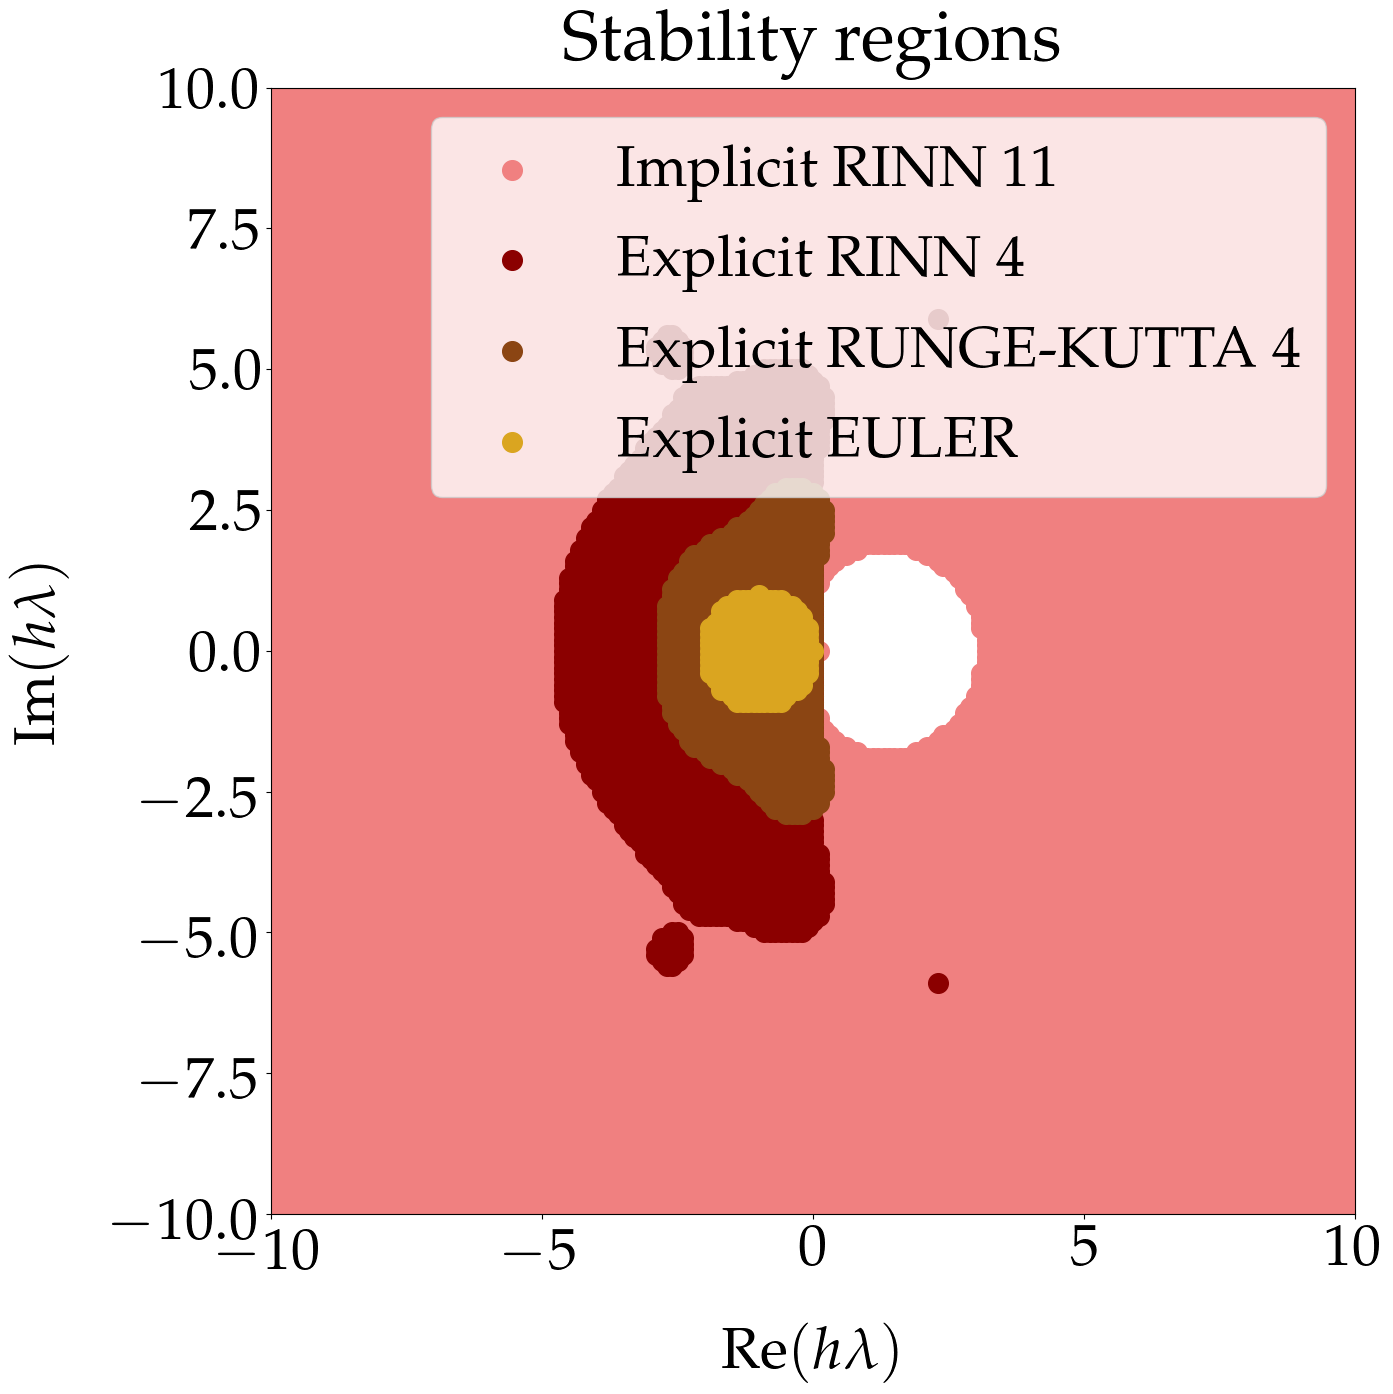

In [ ]:


length_h = 1000



plt.figure(figsize=(15,15))
plt.scatter(np.array(list_x),np.array(list_y),label='Implicit RINN 11',alpha=1,color='lightcoral',s=200)
plt.scatter(np.array(list_xRINNEX),np.array(list_yRINNEX), label = 'Explicit RINN 4',color='darkred',s=200)
plt.scatter(np.array(list_xRK4),np.array(list_yRK4), label = 'Explicit RUNGE-KUTTA 4',color='saddlebrown',s=200)
plt.scatter(np.array(list_xE),np.array(list_yE), label = 'Explicit EULER',color='goldenrod',s=200)



plt.xlabel(r'$\mathrm{Re}(h\lambda)$')
plt.ylabel(r'$\mathrm{Im}(h\lambda)$')
plt.axhline(100, color='black')
plt.axvline(100, color='black')
plt.title("Stability regions")
plt.legend(loc=1)
plt.tight_layout()
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.savefig('ComparaisonOfStbailityRegions',dpi=300)
plt.tight_layout()
plt.show()





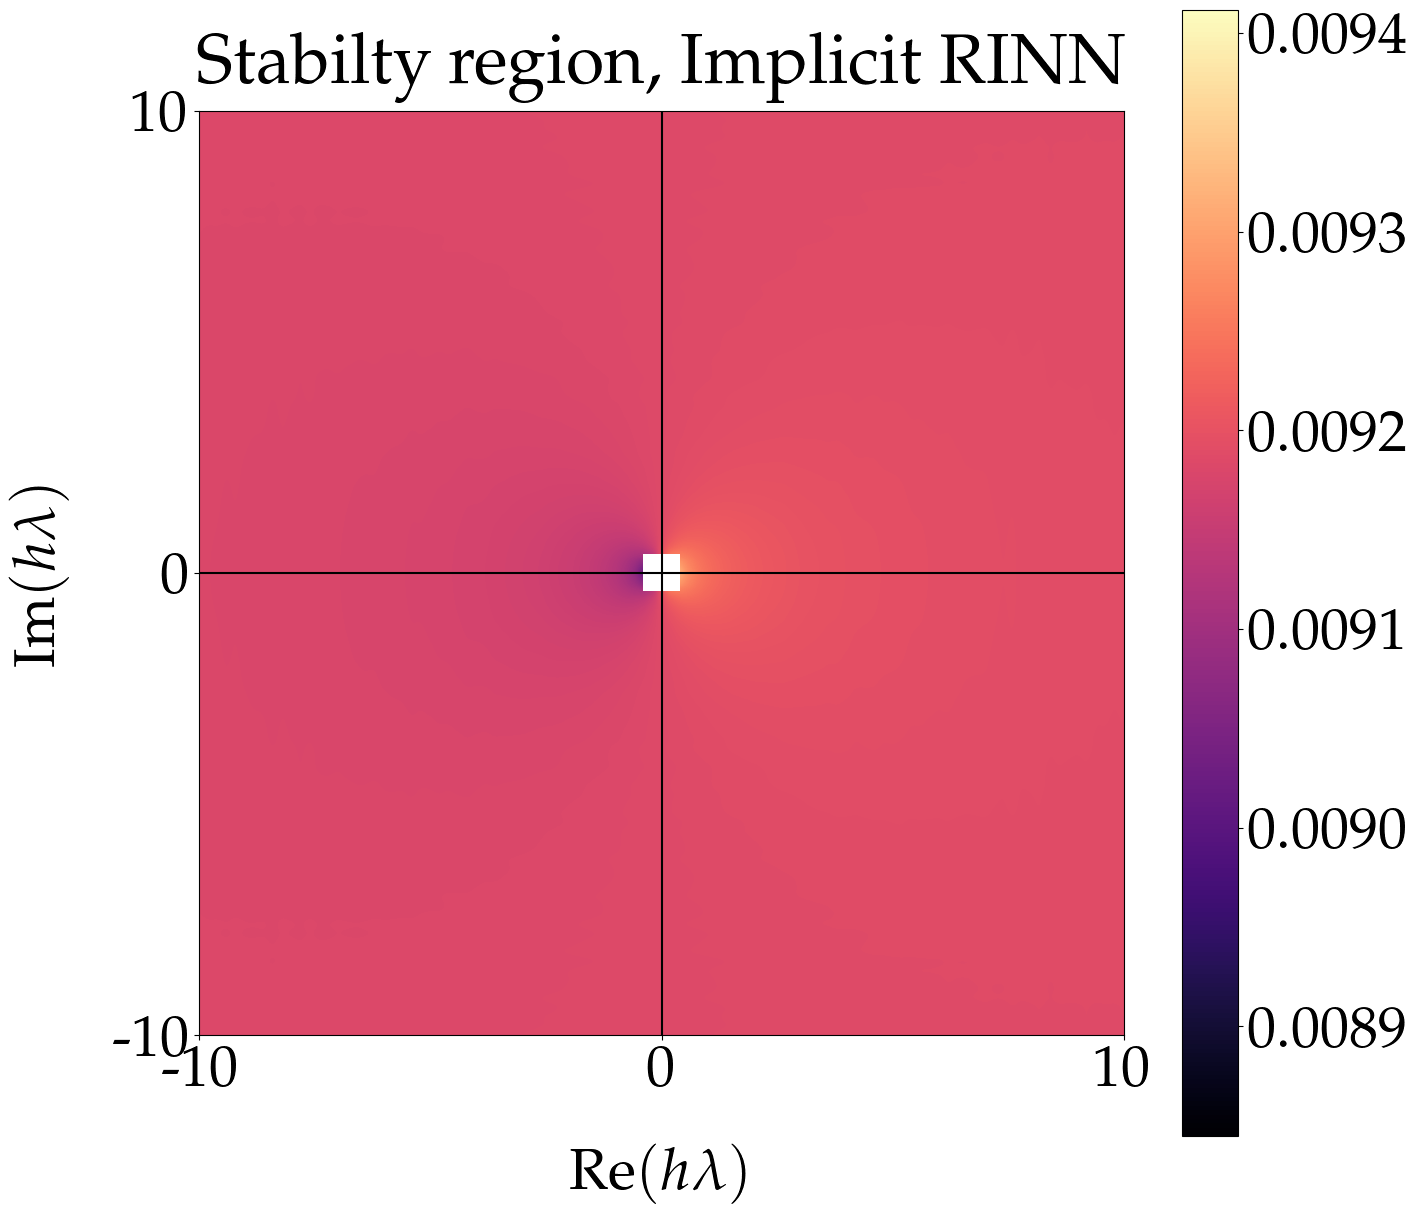

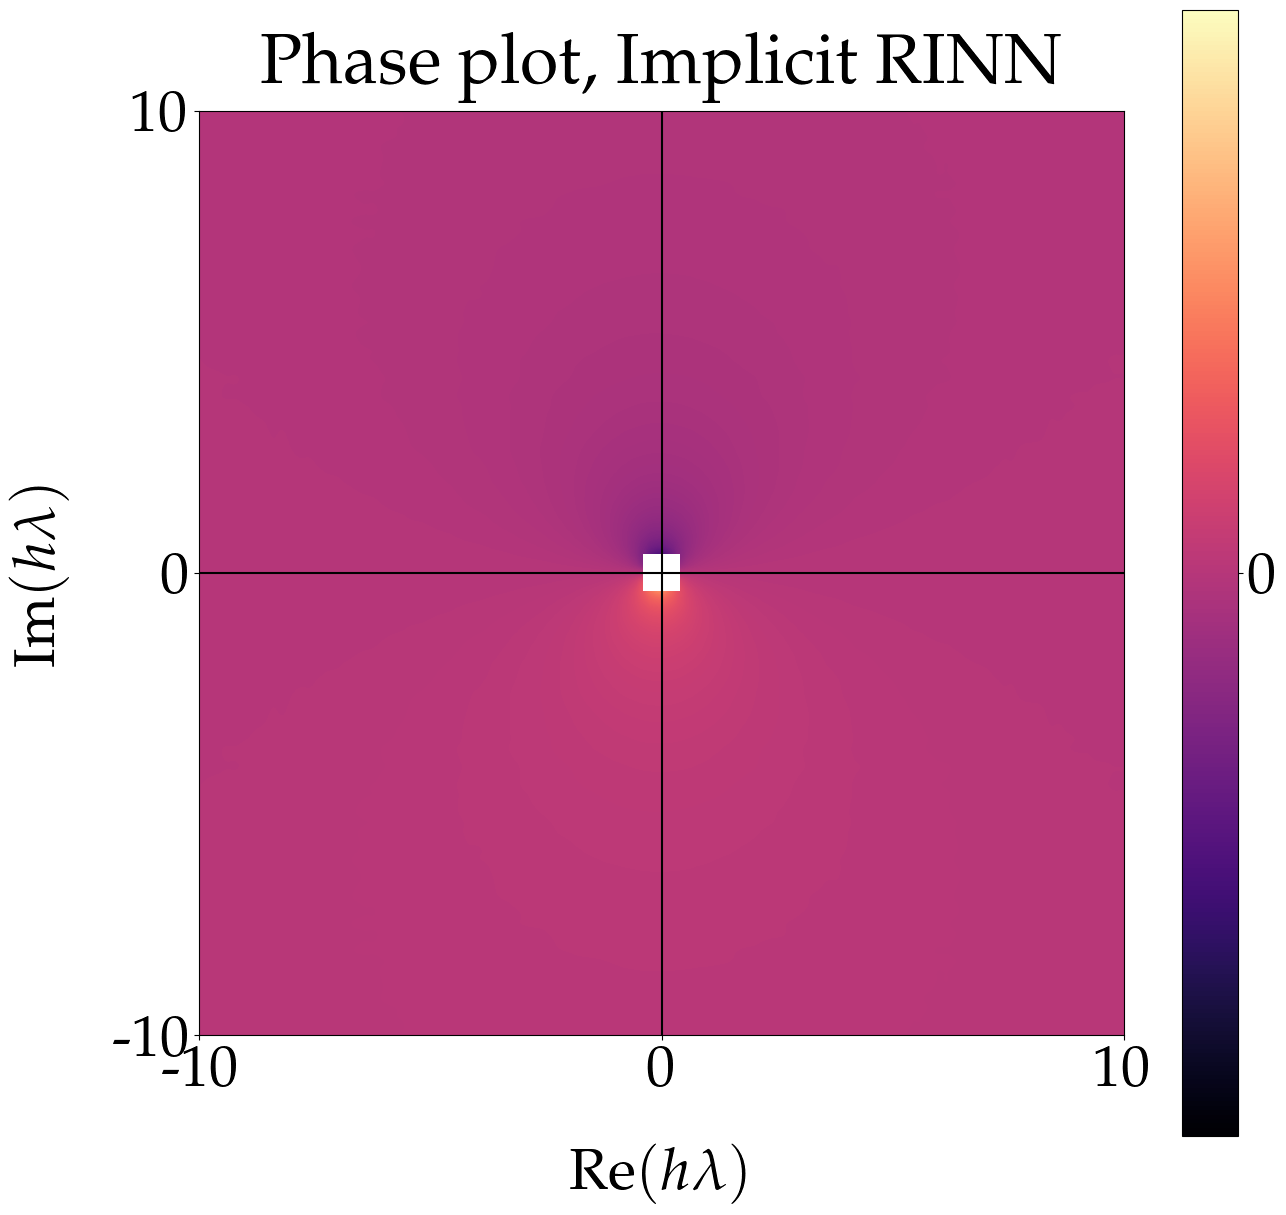

In [ ]:




import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['axes.titlepad'] = 20 
import matplotlib.cm as cm
plt.rcParams['axes.labelpad'] = 30



plt.figure(figsize=(15,15))
plt.xlabel(r'$\mathrm{Re}(h\lambda)$')
plt.ylabel(r'$\mathrm{Im}(h\lambda)$')
plt.xlim([50,150])
plt.ylim([50,150])
plt.xticks([50,100,150],[-10,0,10])
plt.yticks([50,100,150],[-10,0,10])

plt.title("Stabilty region, Implicit RINN")
plt.tight_layout()

im1=plt.imshow(
    np.abs(GRINN),
           cmap='magma',interpolation='gaussian')
plt.colorbar(im1)
plt.axhline(100, color='black')
plt.axvline(100, color='black')
plt.savefig('StabilityRegionOfImplicitRinnIntegrationOnly.png',dpi=300)


plt.figure(figsize=(15,15))
plt.xlabel(r'$\mathrm{Re}(h\lambda)$')
plt.ylabel(r'$\mathrm{Im}(h\lambda)$')
plt.xlim([50,150])
plt.ylim([50,150])
plt.xticks([50,100,150],[-10,0,10])
plt.yticks([50,100,150],[-10,0,10])

plt.title("Phase plot, Implicit RINN")
plt.tight_layout()

im1=plt.imshow(
    np.angle(GRINN),
           cmap='magma',interpolation='gaussian')
cbar = plt.colorbar(im1,ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],orientation="vertical")
cbar.ax.set_yticklabels([r'$-\pi$',r'$-\frac{\pi}{2}$',0,r'$\frac{\pi}{2}$',r'$\pi$'])  # vertically oriented colorbar
plt.axhline(100, color='black')
plt.axvline(100, color='black')
plt.savefig('PhasePlotOfImplicitRinnIntegrationOnly.png',dpi=300)



In [ ]:
from tqdm import tqdm
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
        if tmp<1:
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

In [ ]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_x),np.array(list_y),color='blue')
plt.xlabel(r'$Real(h\lambda)$')
plt.ylabel(r'$Imag(h\lambda)$')
plt.title("Région de stabilité")
plt.legend(loc='best')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/RINN-master/graphes/rds',dpi=300)
#plt.plot(-hi[:399]*0.5,np.zeros_like(gainE[:length_h][np.where(gainE[:length_h]<1)]),lw = 3)
#plt.xlim(-7,0)
#plt.ylim(-3,3)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

plt.figure(figsize=(40,20))
plt.subplot(121)
plt.xlabel(r'$Real(h\lambda)$')
plt.ylabel(r'$Imag(h\lambda)$')
plt.title("RDS RINN implicite")
plt.scatter(list_x,list_y,c=list_g,cmap='magma')
plt.xlim([-10,10])
plt.ylim([-10,10])

plt.subplot(122)
plt.xlabel(r'$Real(h\lambda)$')
plt.ylabel(r'$Imag(h\lambda)$')
plt.title("RDS RINN implicite")
plt.scatter(list_xRINNEX,list_yRINNEX,c=list_gRINNEX,cmap='magma')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/RINN-master/graphes/RDS_RINN_colorbar',dpi=300)
plt.show()